In [1]:
import muon as mu
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys

# Import Custom scripts
sys.path.append("./scripts/")
from scripts.sc_rna_helper.sc_diff_gex import PseudoBulk

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu("../data/annotations/121c_consensus_celltype.h5mu")
print(mdata["gex"].n_vars, "total genes")
print(mdata["gex"].n_obs, "total cells")

4000 total genes
11246 total cells


In [3]:
rna_adata = mdata["gex"].copy()

### Drop Genes that aren't biologically relevant

In [4]:
to_drop = ["XIST", "TSIX", "RPS26"] # These are X-chromosome genes
rna_adata = rna_adata[:, ~rna_adata.var_names.isin(to_drop)]

In [5]:
cell_type_dict = {
    "T cells": ['gdT', 'CD4 Memory', 'CD8 Memory', 'CD4 Naive', 'CD8 Proliferating', 'CD8 Naive', 'CD4 Proliferating', 'Treg'],
    "Monocytes": ['CD14 Mono', 'CD16 Mono'],
    "NK cells": ['NK', 'NK_CD56bright', 'NK Proliferating'],
    "Dendritic cells": ['cDC2', 'cDC1', 'pDC'],
    "B cells": ['B intermediate', 'Plasmablast'],
}


def l1_to_l2_naming(cell_type_dict, l1_name):

    for parent, children in cell_type_dict.items():
        if l1_name in children:
            return parent
    return l1_name

rna_adata.obs["consensus_l2_celltype"] = rna_adata.obs["consensus_celltype"].map(lambda x: l1_to_l2_naming(cell_type_dict, x))

/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_960/4084378183.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_adata.obs["consensus_l2_celltype"] = rna_adata.obs["consensus_celltype"].map(lambda x: l1_to_l2_naming(cell_type_dict, x))


## Generate Pseudobulks

* For each patient we create 1 pseudobulk sample per cell type by aggregating the cell from each subpopulation and taking the mean gene expression within that subpopulation.
* If the data you are working with does not have replicates, it could be beneficial to create multiple (e.g. 2-3) pseudobulks per patient to account for patient variability. 

### Quick View of Cell Type Distribution
- Red highlights indicate cells below min cell cut-off you provide.

In [6]:
# Change Me
min_num_cells = 10

def color_below_threshold(val, threshold, def_color="black", highlight_color="red"):
    color = highlight_color if val < threshold else def_color
    return f'color: {color}'

df = rna_adata.obs.groupby(["ID", "day_label", "consensus_l2_celltype"], as_index=False).size()
df.sort_values(["ID", "day_label"], ascending=False, inplace=True)

df = df.pivot(columns=["ID", "day_label"], values="size", index="consensus_l2_celltype").T
df.columns.name = None
df.index.names = [None, None]

df.style.applymap(lambda x: color_below_threshold(x, min_num_cells))

In [7]:
rna_adata.obs["gvhd_lbl"] = rna_adata.obs["aghvd"].map({"yes": "GVHD", "no": "CONT"}).astype(str)  + " : " + rna_adata.obs["day_label"].astype(str)

In [8]:
rna_adata.obs

Cell_Type_Experimental      Sample_Tag     Sample_Name  \
57                T_gamma_delta  SampleTag03_hs  SampleTag03_hs   
408          Monocyte_classical  SampleTag10_hs  SampleTag10_hs   
461                T_CD4_memory  SampleTag12_hs  SampleTag12_hs   
467          Monocyte_classical  SampleTag04_hs  SampleTag04_hs   
860              Natural_killer  SampleTag04_hs  SampleTag04_hs   
...                         ...             ...             ...   
14042536     Monocyte_classical  SampleTag03_hs  SampleTag03_hs   
14042585           T_CD8_memory  SampleTag01_hs  SampleTag01_hs   
14044069              Dendritic  SampleTag02_hs  SampleTag02_hs   
14044456     Monocyte_classical  SampleTag10_hs  SampleTag10_hs   
14044868              Dendritic  SampleTag12_hs  SampleTag12_hs   

          SampleTag01_hs_Read_Count  SampleTag02_hs_Read_Count  \
57                              128                         27   
408                              13                        103   
461                               6                          1   
467                              10                         38   
860                              11                         36   
...                             ...                        ...   
14042536                          2                         44   
14042585                       2309                          9   
14044069                         12                       8038   
14044456                         30                        132   
14044868                          4                          9   

          SampleTag03_hs_Read_Count  SampleTag04_hs_Read_Count  \
57                             7286                         39   
408                              24                         60   
461                               0                         44   
467                              55                      24086   
860                              17                      12456   
...                             ...                        ...   
14042536                       3548                          8   
14042585                         11                         16   
14044069                         21                         19   
14044456                         49                         72   
14044868                          8                         11   

          SampleTag05_hs_Read_Count  SampleTag06_hs_Read_Count  \
57                               17                         18   
408                              25                         20   
461                               4                          8   
467                              46                         38   
860                               1                         37   
...                             ...                        ...   
14042536                         20                         88   
14042585                          5                         20   
14044069                         47                         29   
14044456                         33                         51   
14044868                          1                         31   

          SampleTag07_hs_Read_Count  ...  ct_high_predicted_labels  \
57                               17  ...                  Mono-mac   
408                              42  ...                 Monocytes   
461                              23  ...                  Mono-mac   
467                              46  ...                 Monocytes   
860                              66  ...                       ILC   
...                             ...  ...                       ...   
14042536                         29  ...                 Monocytes   
14042585                          9  ...                   T cells   
14044069                         12  ...               Macrophages   
14044456                         63  ...                 Monocytes   
14044868                         12  ...               

In [9]:
obs_cols = ["day_label"] # To add other variables from .obs
# obs_cols = None

pseudo = PseudoBulk(rna_adata, sample_key="gvhd_lbl", cell_id_key="consensus_l2_celltype")
pseudo.set_min_number_cells(min_num_cells)
cell_type = "T cells"

# # Run this if don't need pseudo replicates
# adata_pb = pseudo.generate_pseudo_bulk(condition_key="aghvd", cell_type=cell_type, raw_data_layer="raw", cols_to_keep=obs_cols)

# Run this if wanting to generate pseudo replicates
pseudo.set_replicates_per_sample(5)
adata_pb = pseudo.generate_pseudo_dbulk_psuedo_rep(condition_key="aghvd", cell_type=cell_type , raw_data_layer="raw", cols_to_keep=obs_cols)

adata_pb.obs

day_label aghvd          sample  replicate cell_type  \
GVHD : D21/42_1     D21/42   yes   GVHD : D21/42          1   T cells   
GVHD : D21/42_2     D21/42   yes   GVHD : D21/42          2   T cells   
GVHD : D21/42_3     D21/42   yes   GVHD : D21/42          3   T cells   
GVHD : D21/42_4     D21/42   yes   GVHD : D21/42          4   T cells   
GVHD : D21/42_5     D21/42   yes   GVHD : D21/42          5   T cells   
CONT : D90/120_1   D90/120    no  CONT : D90/120          1   T cells   
CONT : D90/120_2   D90/120    no  CONT : D90/120          2   T cells   
CONT : D90/120_3   D90/120    no  CONT : D90/120          3   T cells   
CONT : D90/120_4   D90/120    no  CONT : D90/120          4   T cells   
CONT : D90/120_5   D90/120    no  CONT : D90/120          5   T cells   
GVHD : D90/120_1   D90/120   yes  GVHD : D90/120          1   T cells   
GVHD : D90/120_2   D90/120   yes  GVHD : D90/120          2   T cells   
GVHD : D90/120_3   D90/120   yes  GVHD : D90/120          3   T cells   
GVHD : D90/120_4   D90/120   yes  GVHD : D90/120          4   T cells   
GVHD : D90/120_5   D90/120   yes  GVHD : D90/120          5   T cells   
CONT : D21/42_1     D21/42    no   CONT : D21/42          1   T cells   
CONT : D21/42_2     D21/42    no   CONT : D21/42          2   T cells   
CONT : D21/42_3     D21/42    no   CONT : D21/42          3   T cells   
CONT : D21/42_4     D21/42    no   CONT : D21/42          4   T cells   
CONT : D21/42_5     D21/42    no   CONT : D21/42          5   T cells   
CONT : donor_1       donor    no    CONT : donor          1   T cells   
CONT : donor_2       donor    no    CONT : donor          2   T cells   
CONT : donor_3       donor    no    CONT : donor          3   T cells   
CONT : donor_4       donor    no    CONT : donor          4   T cells   
CONT : donor_5       donor    no    CONT : donor          5   T cells   
GVHD : donor_1       donor   yes    GVHD : donor          1   T cells   
GVHD : donor_2       donor   yes    GVHD : donor          2   T cells   
GVHD : donor_3       donor   yes    GVHD : donor          3   T cells   
GVHD : donor_4       donor   yes    GVHD : donor          4   T cells   
GVHD : donor_5       donor   yes    GVHD : donor          5   T cells   
GVHD : graft_1       graft   yes    GVHD : graft          1   T cells   
GVHD : graft_2       graft   yes    GVHD : graft          2   T cells   
GVHD : graft_3       graft   yes    GVHD : graft          3   T cells   
GVHD : graft_4       graft   yes    GVHD : graft          4   T cells   
GVHD : graft_5       graft   yes    GVHD : graft          5   T cells   

                  num_cells  
GVHD : D21/42_1         307  
GVHD : D21/42_2         307  
GVHD : D21/42_3         307  
GVHD : D21/42_4         306  
GVHD : D21/42_5         306  
CONT : D90/120_1        114  
CONT : D90/120_2        114  
CONT : D90/120_3        114  
CONT : D90/120_4        114  
CONT : D90/120_5        113  
GVHD : D90/120_1        101  
GVHD : D90/120_2        100  
GVHD : D90/120_3        100  
GVHD : D90/120_4        100  
GVHD : D90/120_5        100  
CONT : D21/42_1          42  
CONT : D21/42_2          42  
CONT : D21/42_3          42  
CONT : D21/42_4          41  
CONT : D21/42_5          41  
CONT : donor_1          248  
CONT : donor_2          247  
CONT : donor_3          247  
CONT : donor_4          247  
CONT : donor_5          247  
GVHD : donor_1          150  
GVHD : donor_2          150  
GVHD : donor_3          149  
GVHD : donor_4          149  
GVHD : donor_5          149  
GVHD : graft_1            5  
GVHD : graft_2            5  
GVHD : graft_3            5  
GVHD : graft_4            5  
GVHD : graft_5            5

In [10]:
pseudo.samples_rm

{'CONT : graft'}

# Run DeSeq2

In [11]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [12]:
grouped_dict = {key[0]:list(data.index) for key, data in adata_pb.obs.groupby(["day_label"])}
grouped_dict.keys()

dict_keys(['D21/42', 'D90/120', 'donor', 'graft'])

In [13]:
timepoint = "D21/42"

# Create Counts Matrix for Deseq2
sub_pb_adata = adata_pb[grouped_dict[timepoint]].copy()

#### Remove Replicates with less then number of cells
rows = sub_pb_adata.obs["num_cells"] >= min_num_cells

counts_mtx = pd.DataFrame(sub_pb_adata[rows].X, columns=sub_pb_adata.var_names)
dds = DeseqDataSet(counts=counts_mtx, metadata=sub_pb_adata[rows].obs, design_factors="aghvd")

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.30 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.24 seconds.

Fitting LFCs...
... done in 0.18 seconds.

Refitting 0 outliers.



/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


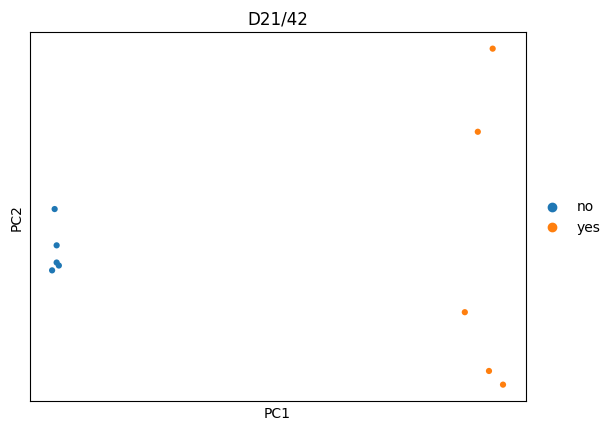

In [15]:
sc.tl.pca(dds)
sc.pl.pca(dds, s=80, color=["aghvd"], title=timepoint.capitalize())

In [16]:
stat_res = DeseqStats(dds, n_cpus=8, contrast=("aghvd", "yes", "no"))
stat_res.summary()
de = stat_res.results_df.reset_index(names="genes")

Running Wald tests...


Log2 fold change & Wald test p-value: aghvd yes vs no


... done in 0.31 seconds.



baseMean  log2FoldChange     lfcSE       stat        pvalue  \
A2M     87.859292       -3.494042  0.165785 -21.075683  1.329743e-98   
AAK1    94.585672       -0.329745  0.144223  -2.286354  2.223358e-02   
AATF    35.640979        0.315692  0.226528   1.393612  1.634349e-01   
ABCA1    8.621651       -0.379887  0.425967  -0.891823  3.724879e-01   
ABCC1   59.961219       -0.045178  0.167752  -0.269316  7.876866e-01   
...           ...             ...       ...        ...           ...   
ZSWIM6  44.811592       -0.909874  0.188032  -4.838941  1.305327e-06   
ZXDC    28.988851       -0.079597  0.238418  -0.333854  7.384897e-01   
ZYX     39.682605        0.835498  0.233398   3.579717  3.439660e-04   
ZZEF1   42.601701       -0.624992  0.191166  -3.269370  1.077871e-03   
ZZZ3    31.312934       -0.041587  0.272530  -0.152596  8.787172e-01   

                padj  
A2M     2.657491e-95  
AAK1    5.482271e-02  
AATF    2.680546e-01  
ABCA1   5.009536e-01  
ABCC1   8.565816e-01  
...              ...  
ZSWIM6  1.086956e-05  
ZXDC    8.212976e-01  
ZYX     1.616243e-03  
ZZEF1   4.282554e-03  
ZZZ3    9.232999e-01  

[3997 rows x 6 columns]

In [17]:
from bioinfokit import visuz

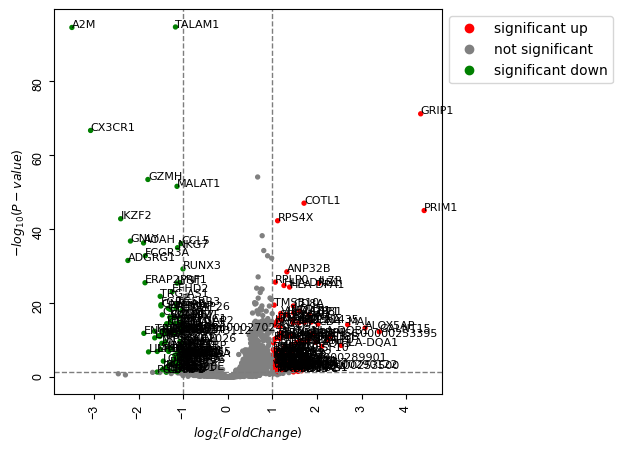

In [18]:
log_fc = (1, 1) # (Downregulated, Upregulated) fold change
pvals = (0.05, 0.05) # (Upregulated, Downregulated) pvals

visuz.GeneExpression.volcano(df=de.dropna(),
                             lfc="log2FoldChange", 
                             pv="padj", 
                             show=True, 
                             plotlegend=True, 
                             legendpos='upper right',
                             legendanchor=(1.46,1),
                             sign_line=True,
                             lfc_thr=log_fc,
                             pv_thr=pvals,
                             geneid="genes",
                             genenames="deg",
                             color=('red', 'grey', 'green'),
                            )

In [19]:
sig_fc_rows = np.abs(de["log2FoldChange"]) >= log_fc[0]
sig_pval_rows = de["padj"] < pvals[0]
de_sig = de[sig_fc_rows & sig_pval_rows]

# Plot Heatmap of Significant Genes

In [20]:
import seaborn as sns

In [21]:
adata_pb.layers["raw"] = adata_pb.X.copy()
sc.pp.log1p(adata_pb)

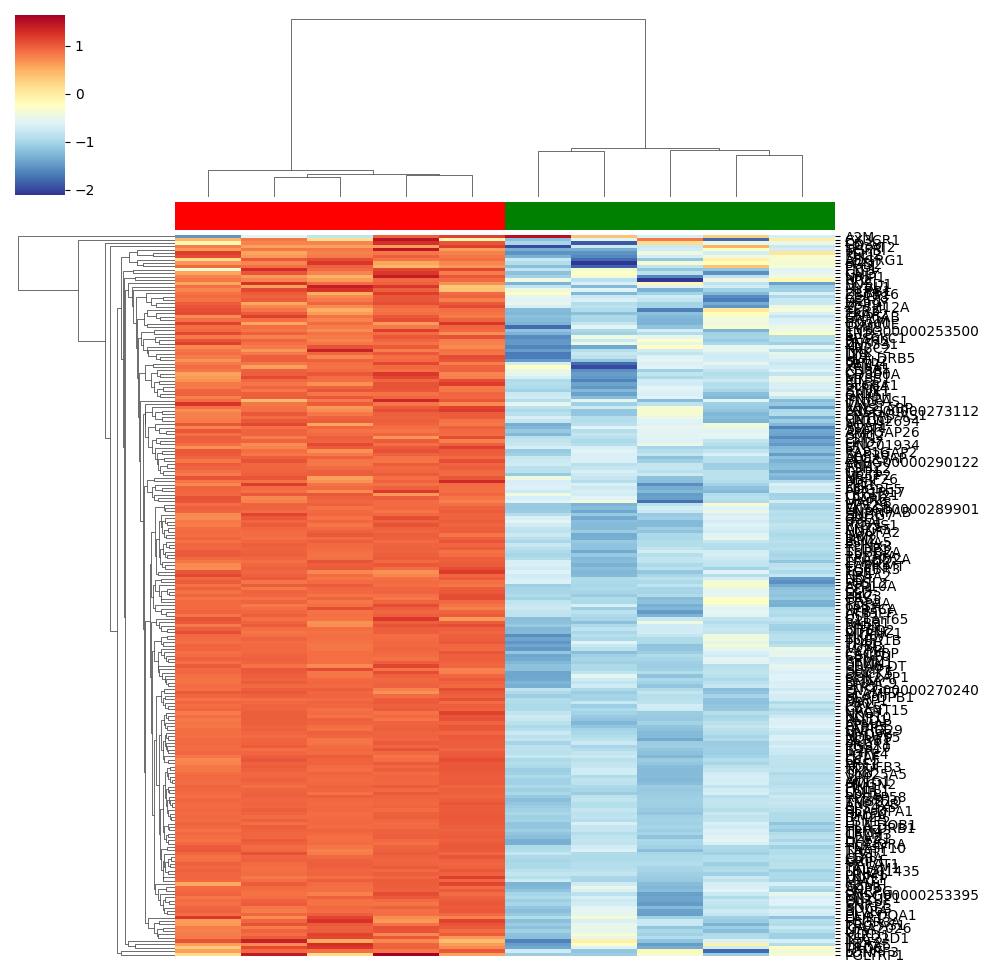

In [22]:
tp_rows = adata_pb.obs["day_label"] == timepoint
sig_genes = list(de_sig["genes"])

sig_adata =  adata_pb[tp_rows, sig_genes].copy()

df = pd.DataFrame(
    sig_adata.X,
    columns=sig_adata.var_names
)
colors = sig_adata[:, sig_genes].obs["aghvd"].map({"yes": "red", "no": "green"}).values
ax = sns.clustermap(df.T, z_score=0, cmap="RdYlBu_r", col_colors=colors, figsize=(10, 10), yticklabels=True)
ax_heat = ax.ax_heatmap
ax_heat.set_xticks([]);

## Save Significant Genes to an Excel File.

In [23]:
sig_col = rna_adata.var_names.isin(sig_genes)
path_dir = "../data/d21-d24_sig_genes.csv"
df = pd.DataFrame(rna_adata[:, sig_col].X, columns=rna_adata[:, sig_genes].var_names)
df["gvhd_lbl"] = list(rna_adata[:, sig_col].obs["gvhd_lbl"])
df.to_excel("../data/d21-d41_sig_genes.xlsx", index=False)

# Plot Dotplots

In [24]:
def plot_genes(adata, hue, y_val, x_vals, col_order, x_tick_order, facet_cols, palette):
    df = pd.DataFrame(
        adata.X,
        columns=adata.var_names,
        index=adata.obs_names
    )
    
    df[facet_cols] = adata.obs[facet_cols]
    df[x_vals] = adata.obs[x_vals]
    df[hue] = adata.obs[hue]
    
    g = sns.FacetGrid(df, col=facet_cols, col_order=col_order, hue=hue, palette=palette)
    g.map(sns.stripplot, x_vals, y_val, order=x_tick_order)
    g.set_xlabels(None)
    g.set_ylabels(y_val)
    g.set_titles(col_template="{col_name}")
    
    return g

### Select Genes to Plot

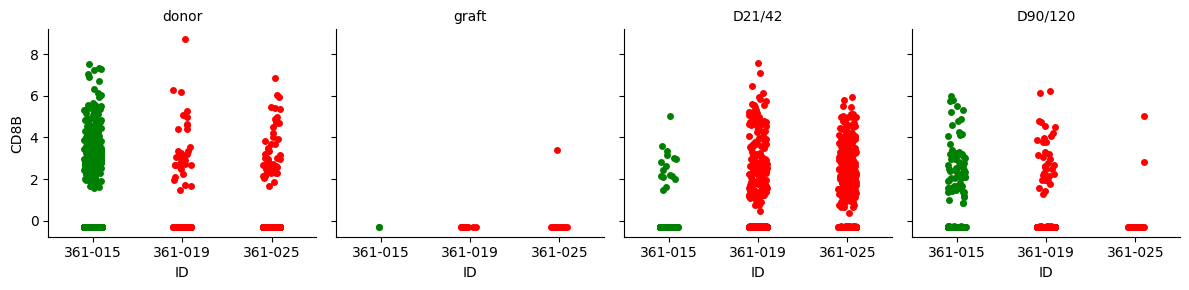

In [25]:
rows = rna_adata.obs["consensus_l2_celltype"] == "T cells"

plot_genes(rna_adata[rows],
           x_vals="ID",
           y_val="CD8B",
           hue="aghvd", 
           facet_cols="day_label",
           col_order=( 'donor', 'graft', 'D21/42', 'D90/120'),
           x_tick_order=('361-015', '361-019', '361-025'),
           palette={"no": "green", "yes": "red"}
          )

### Plot All Significant Genes

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


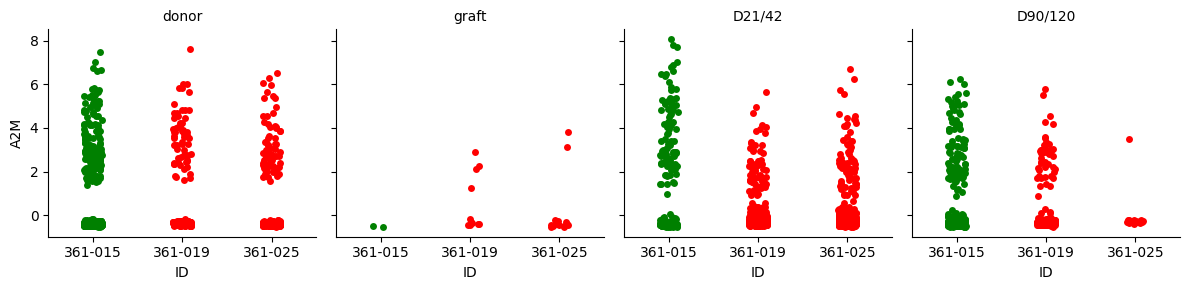

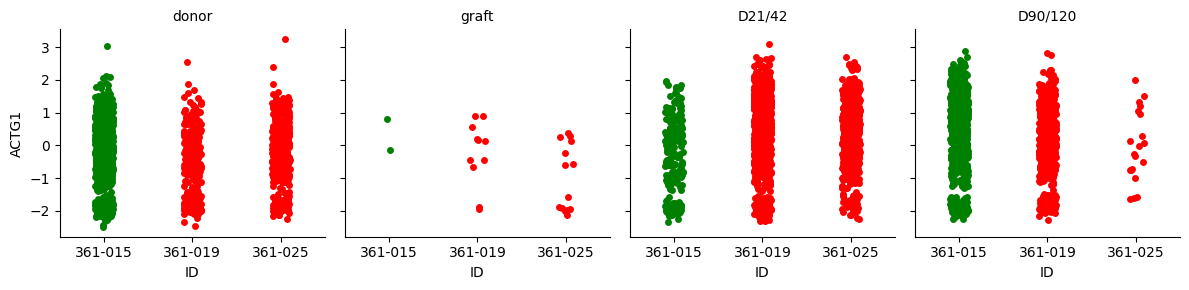

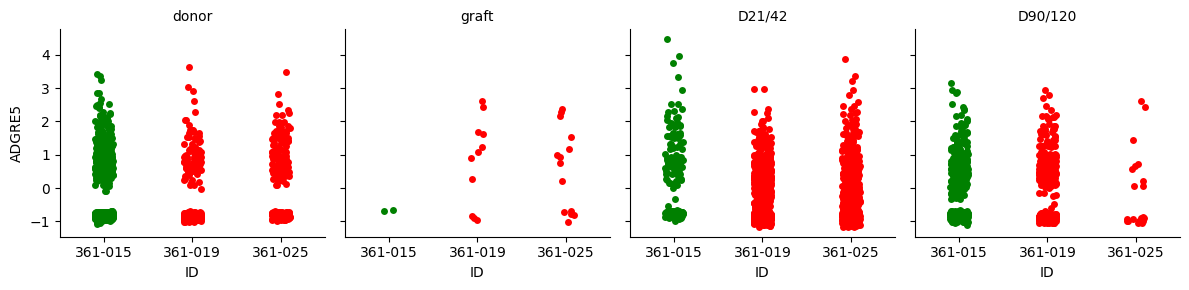

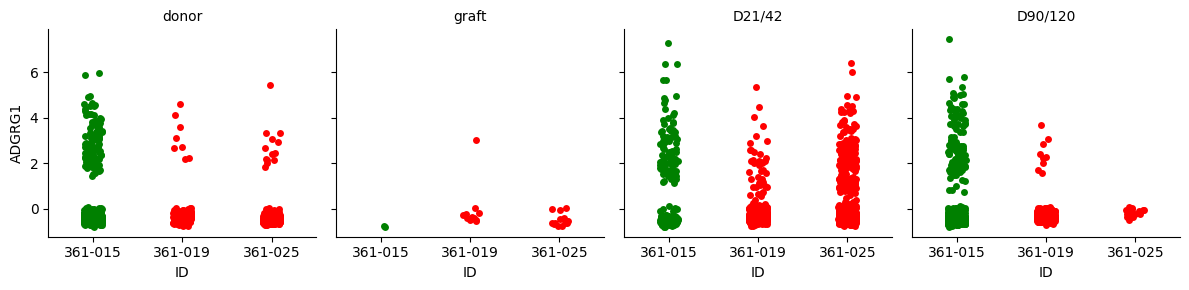

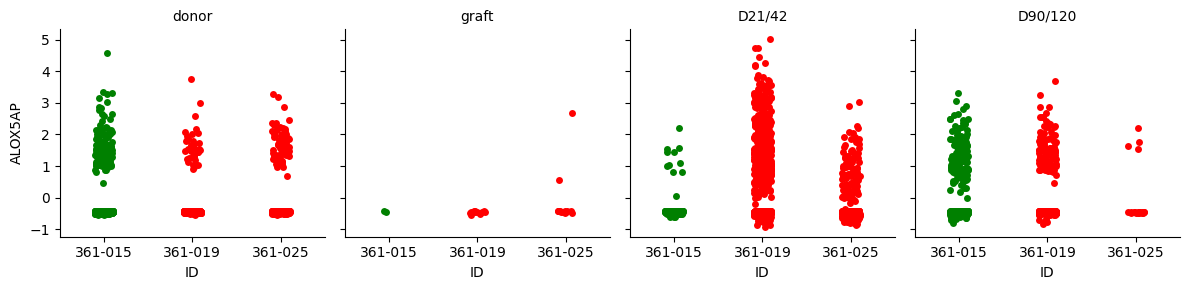

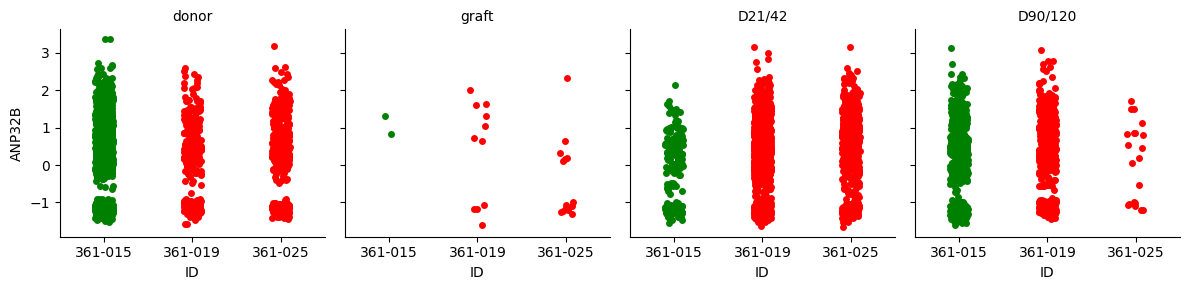

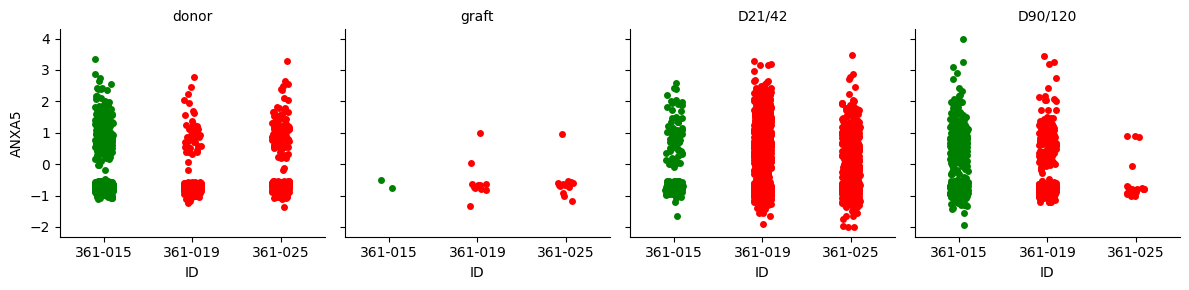

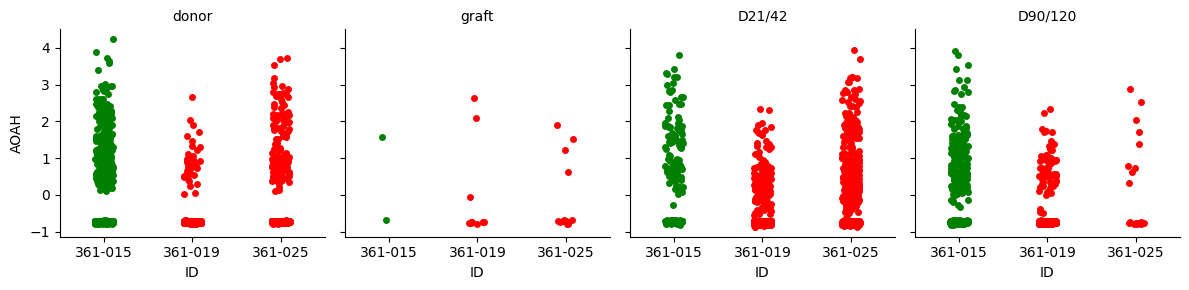

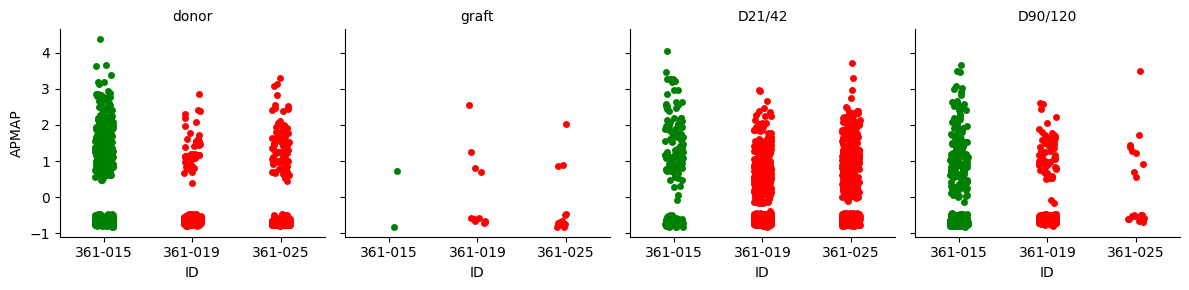

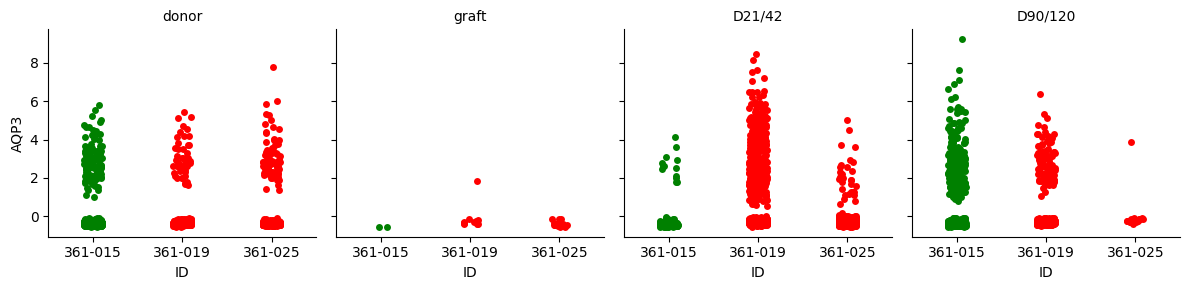

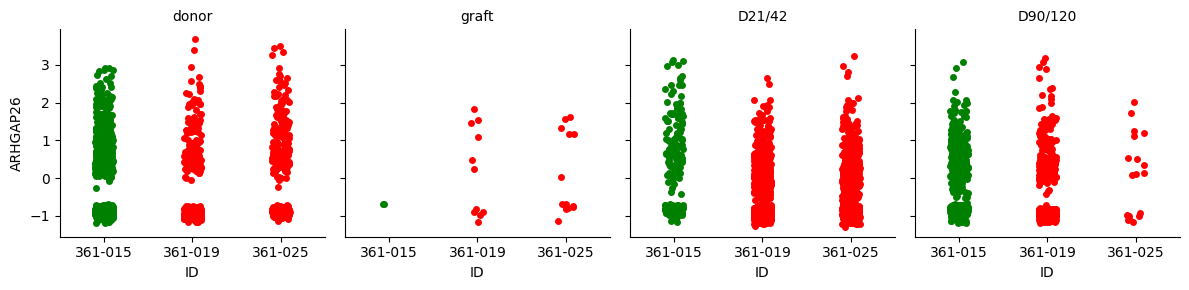

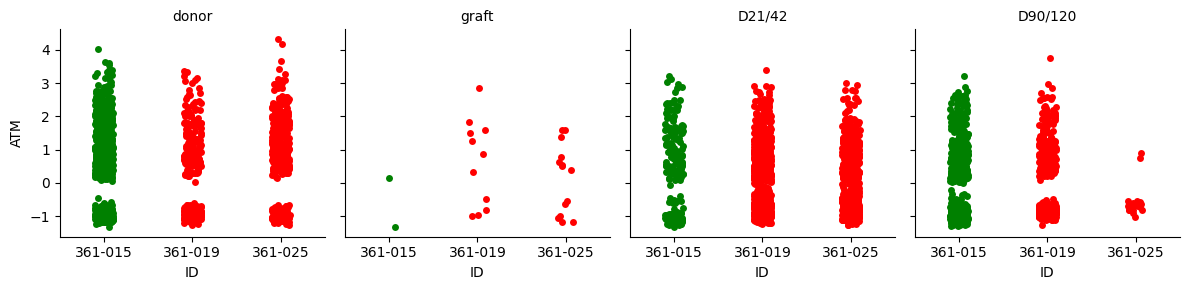

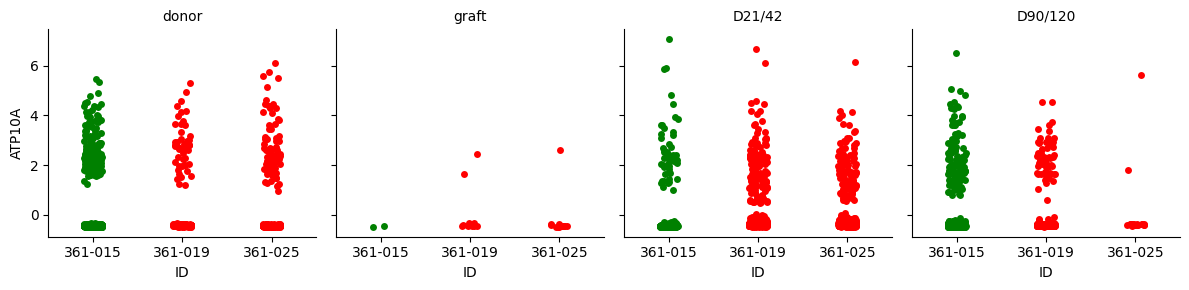

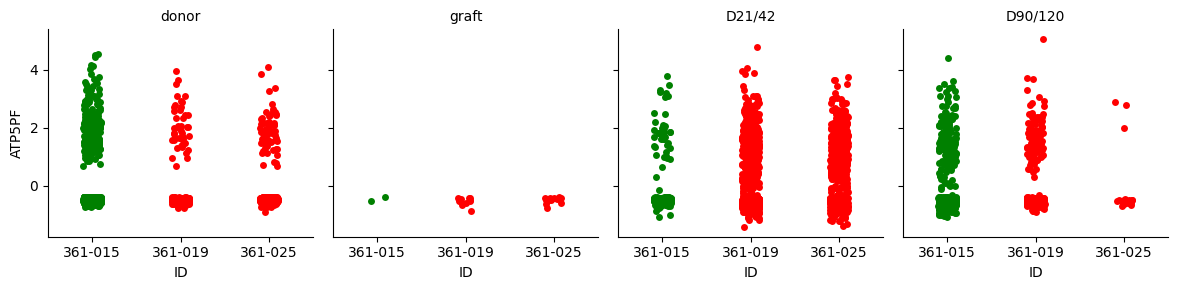

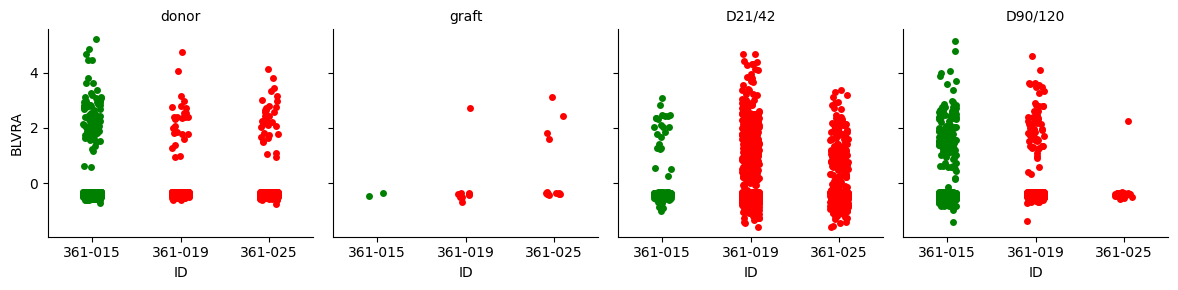

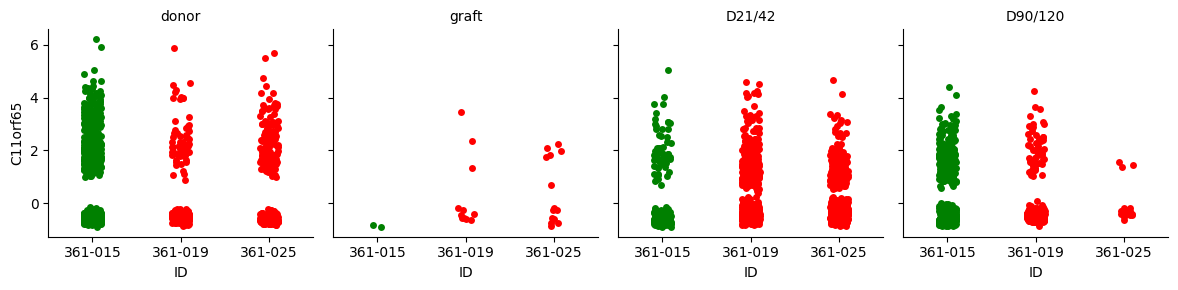

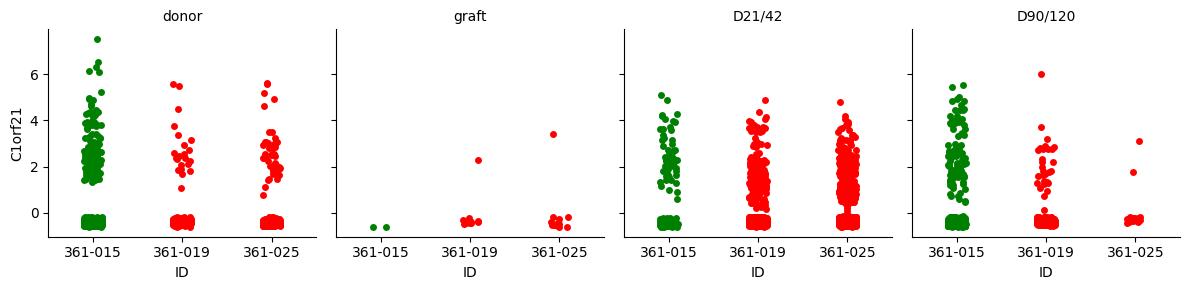

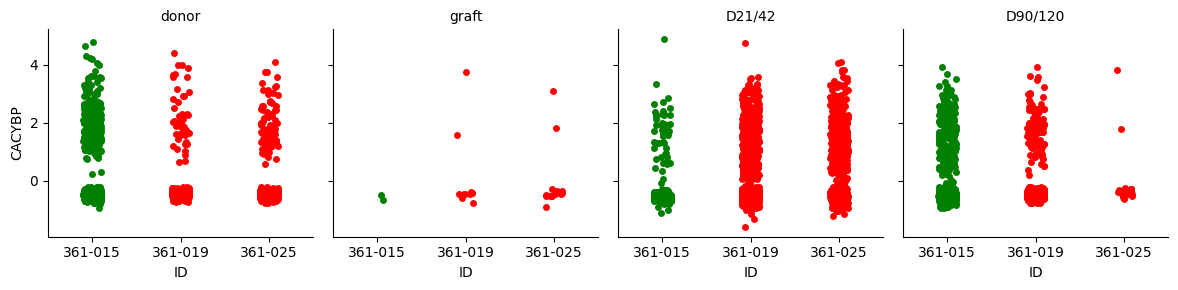

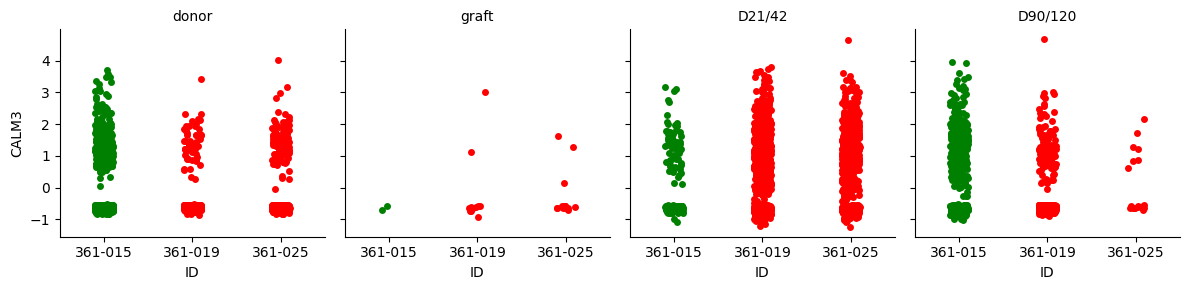

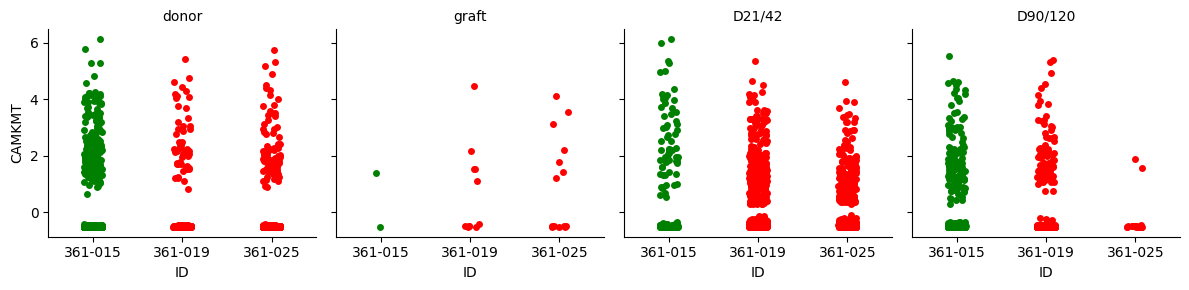

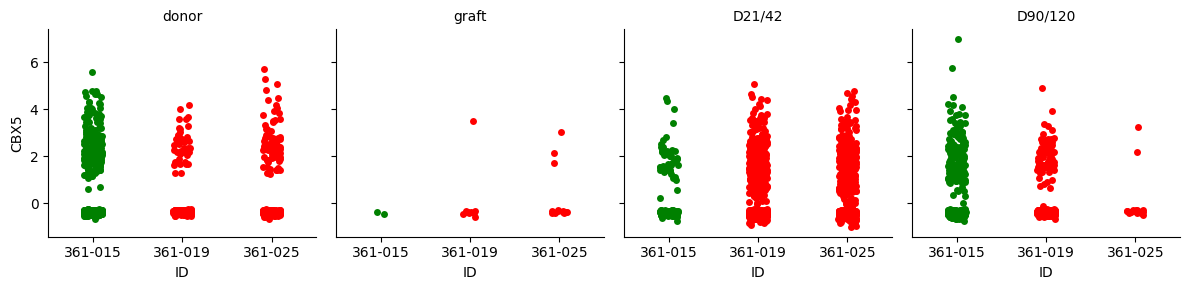

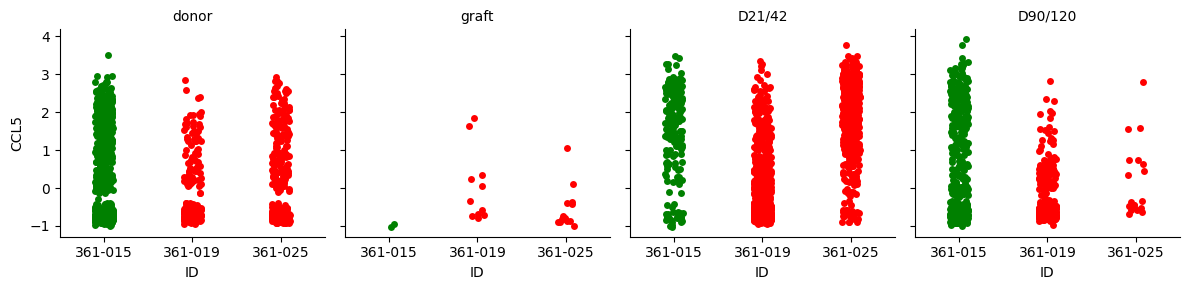

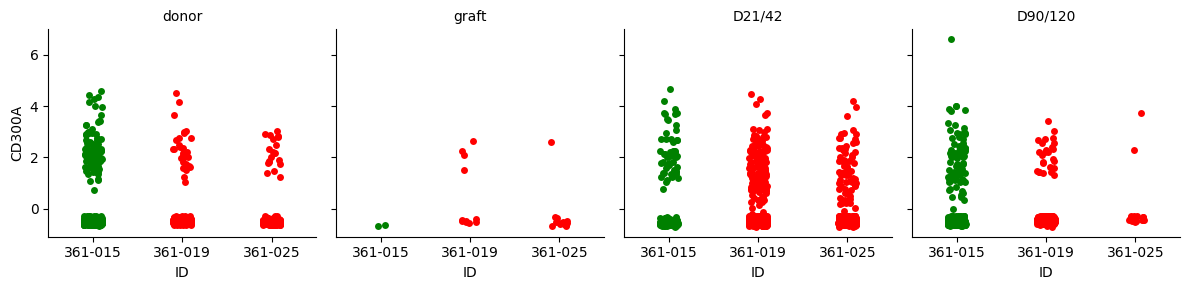

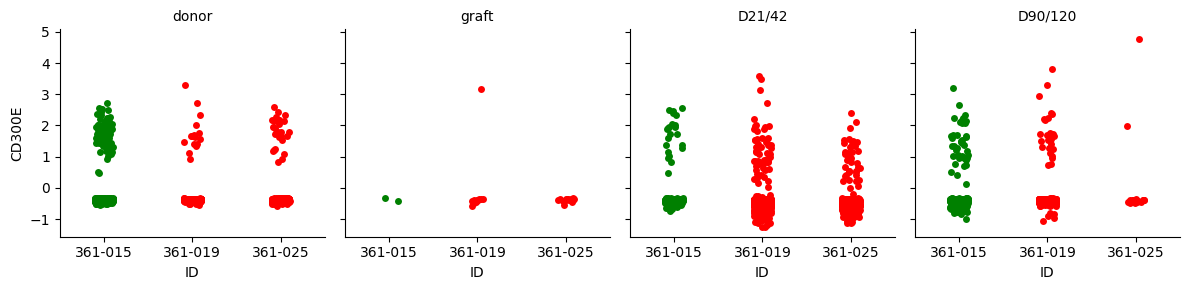

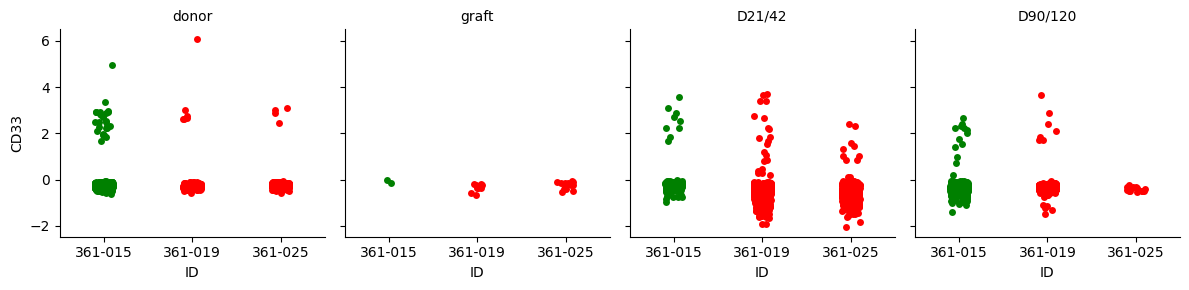

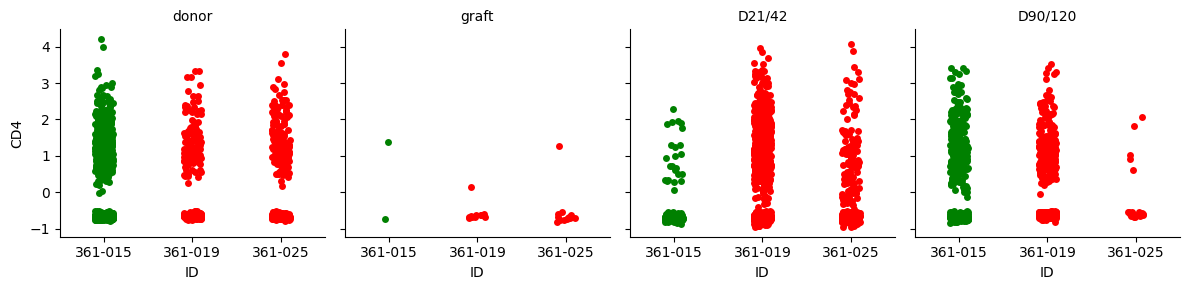

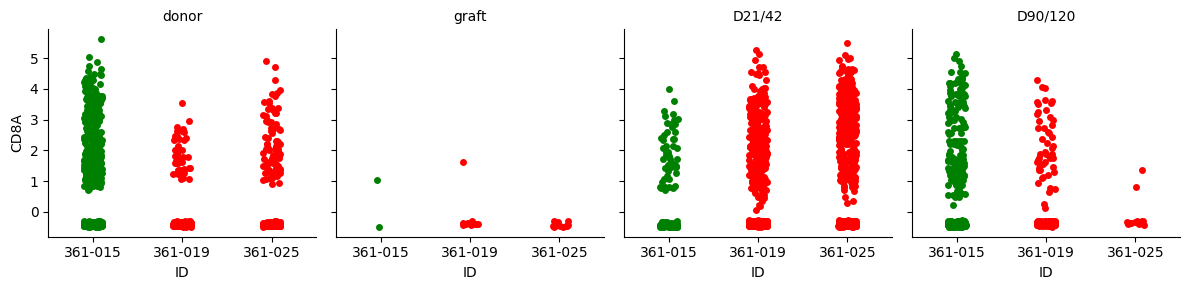

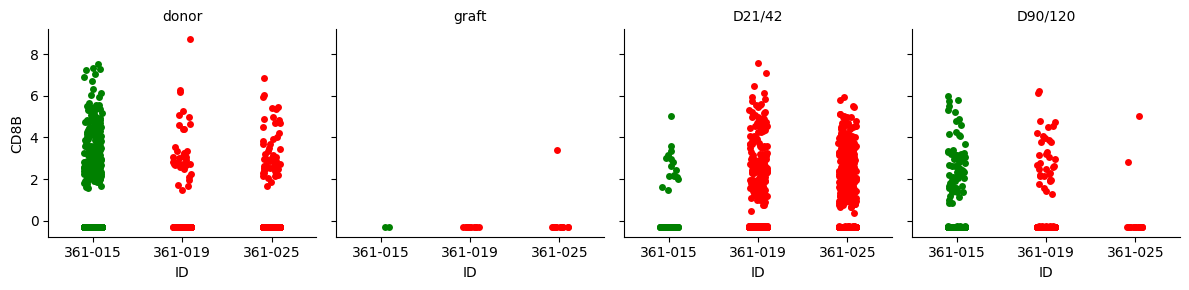

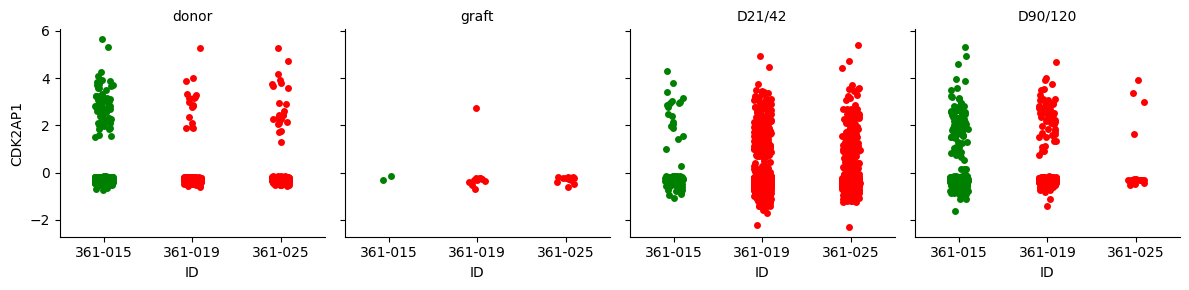

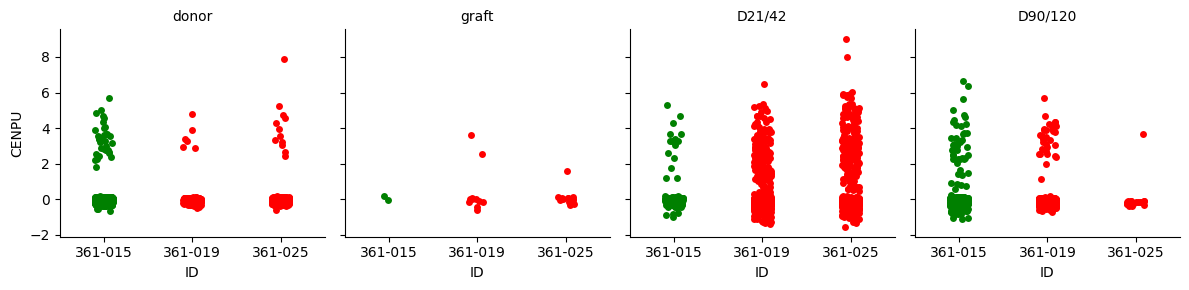

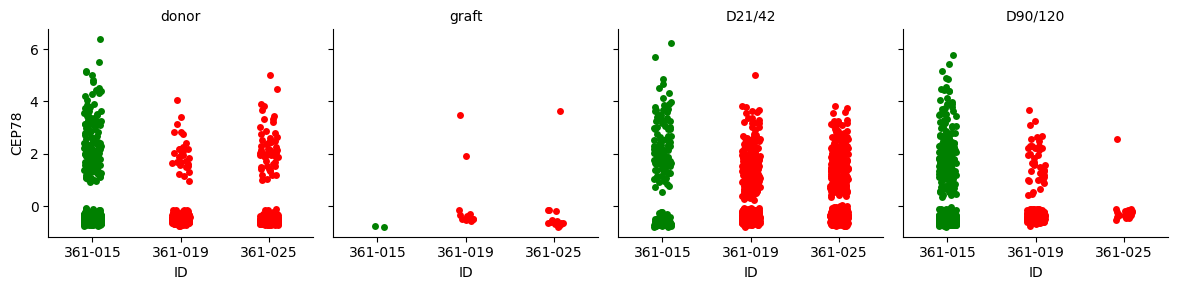

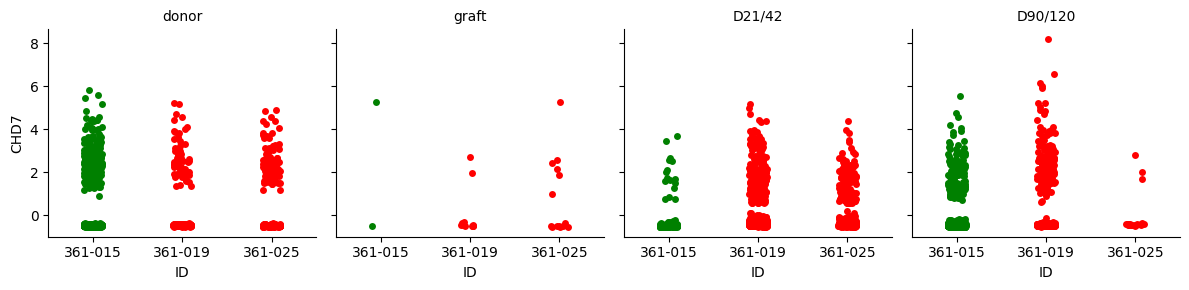

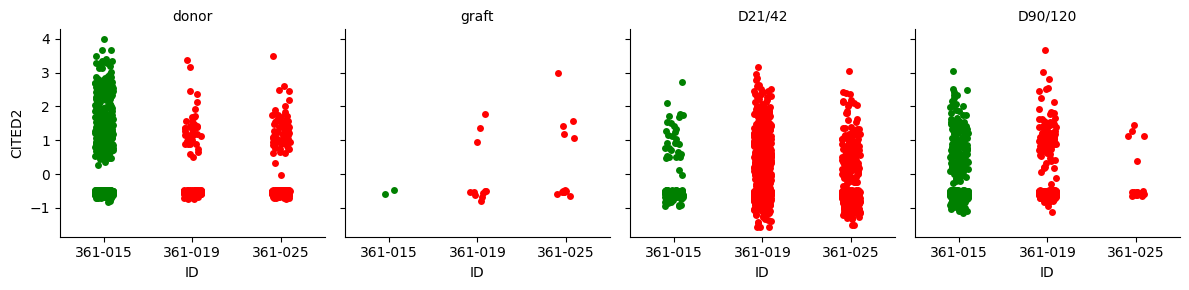

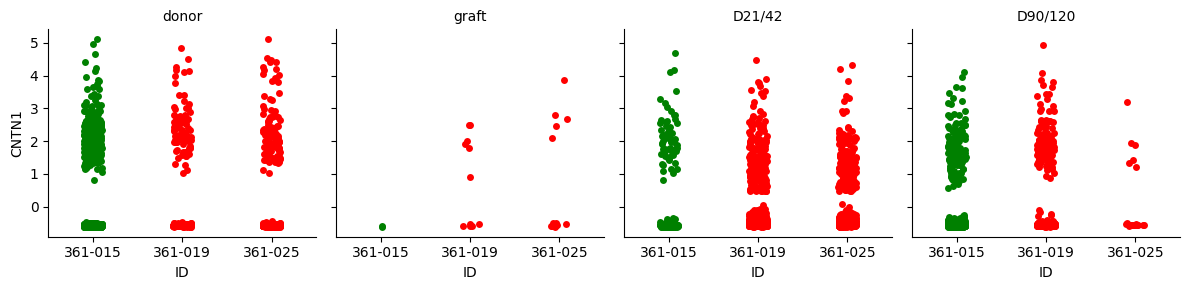

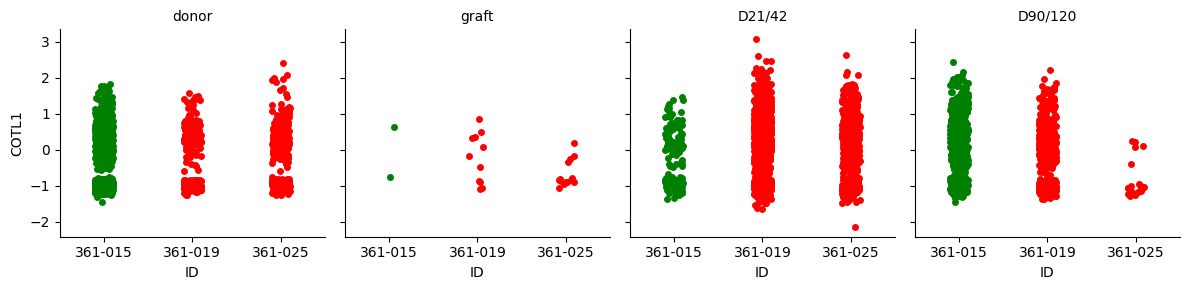

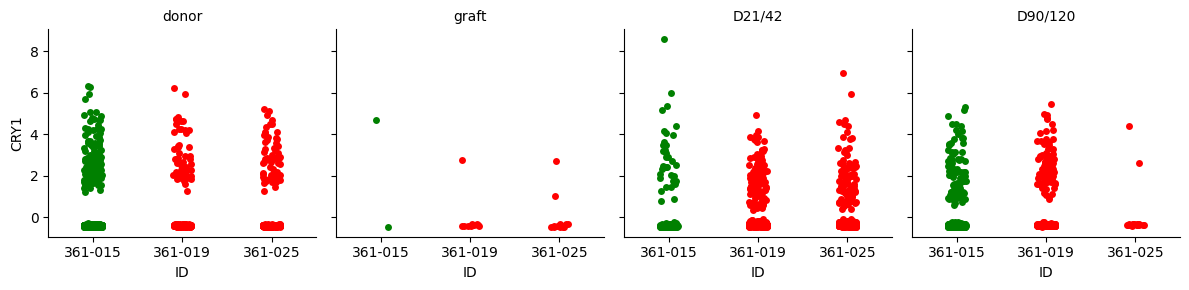

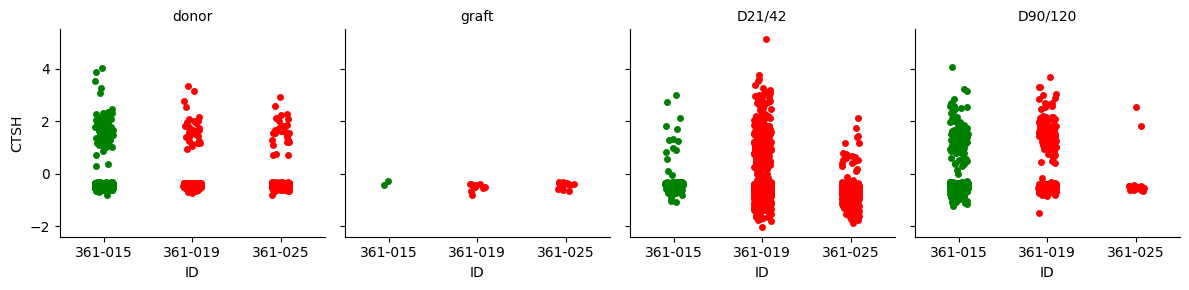

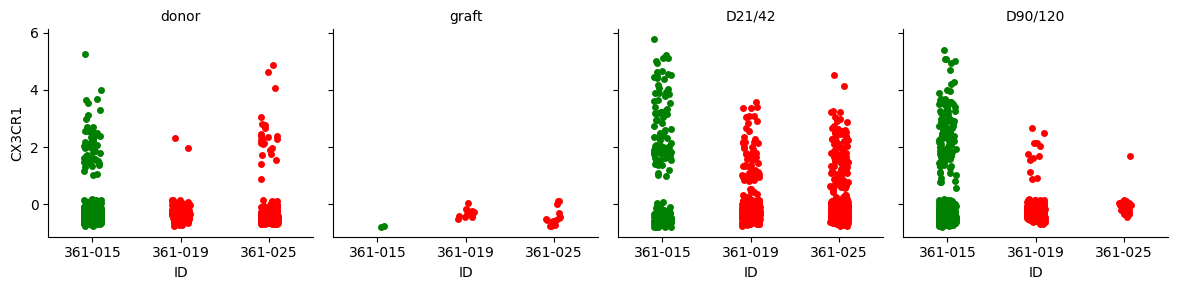

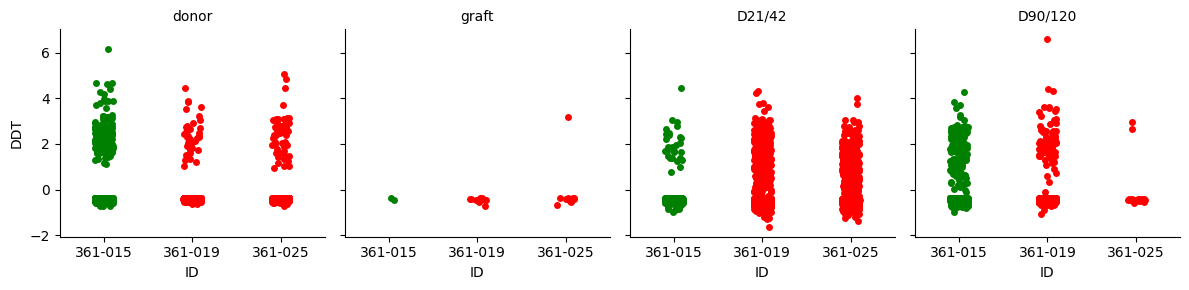

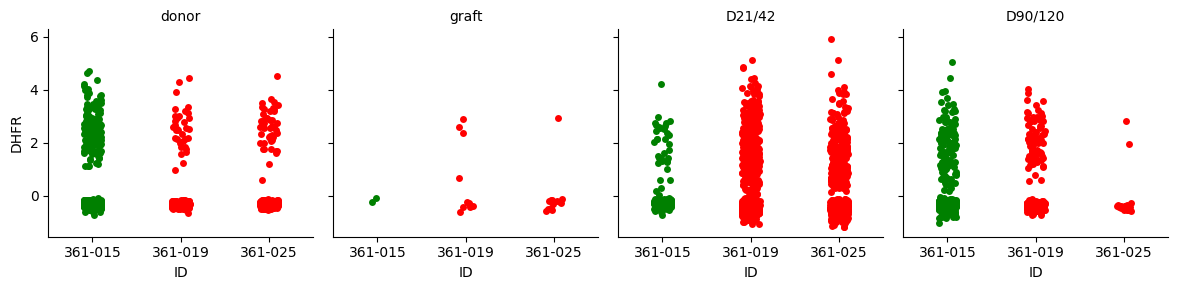

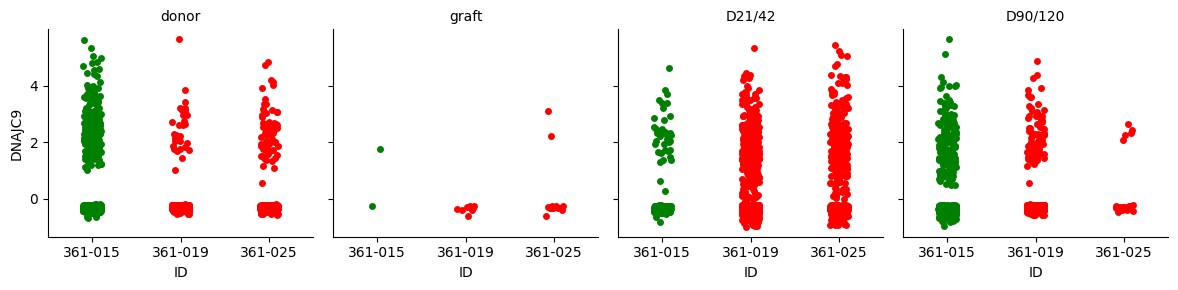

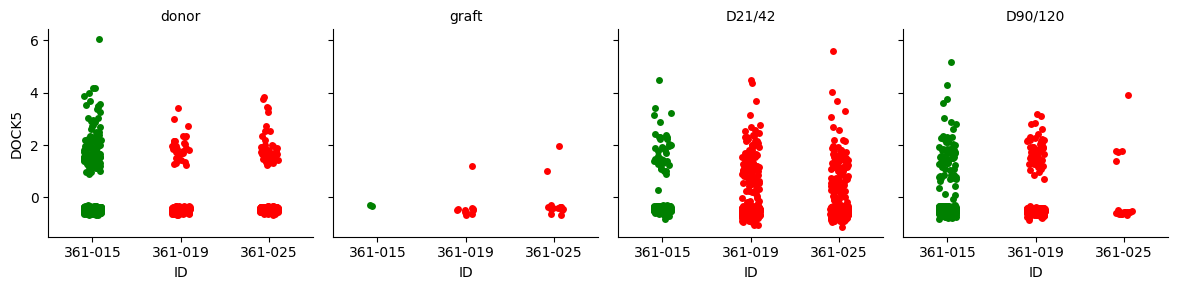

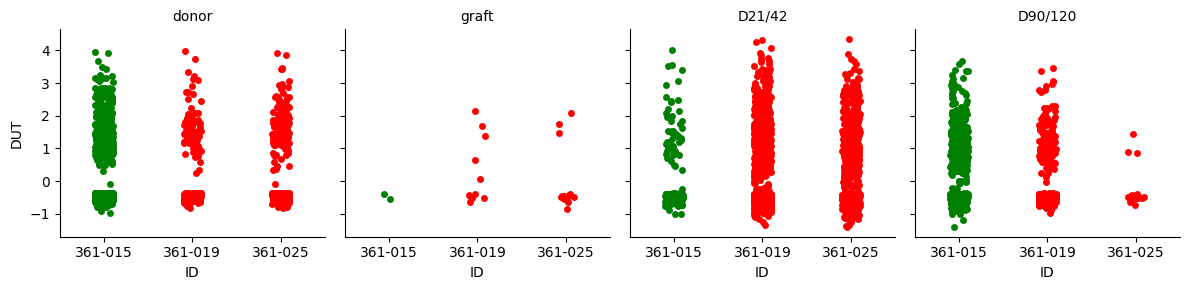

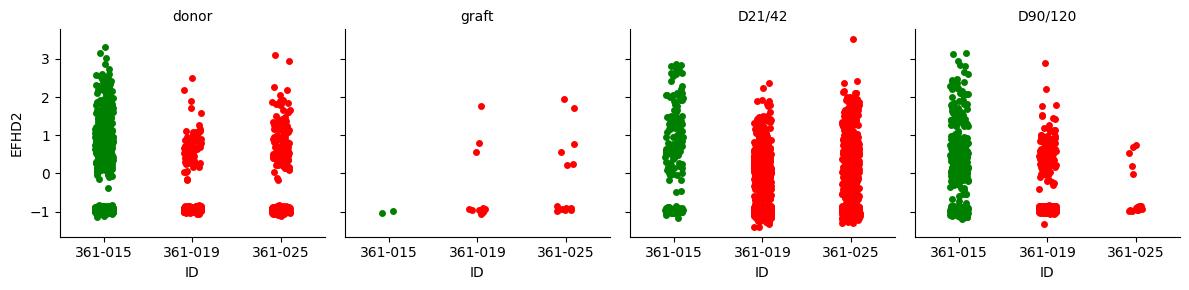

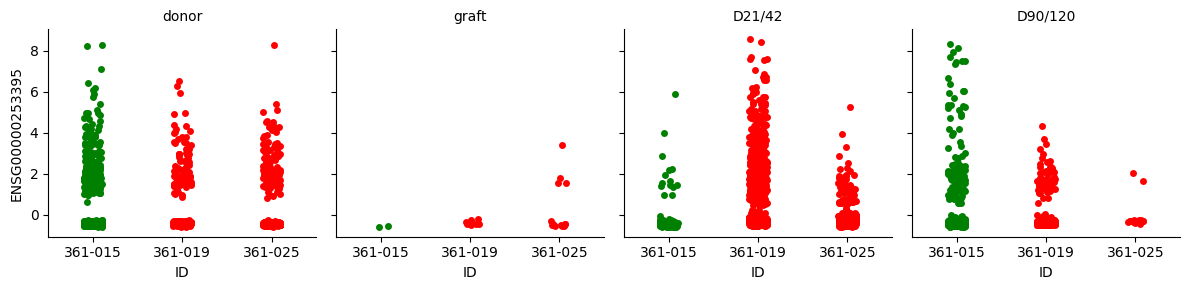

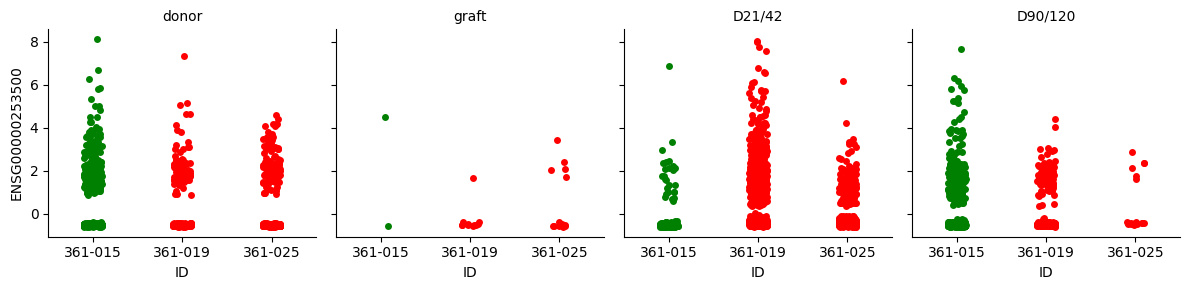

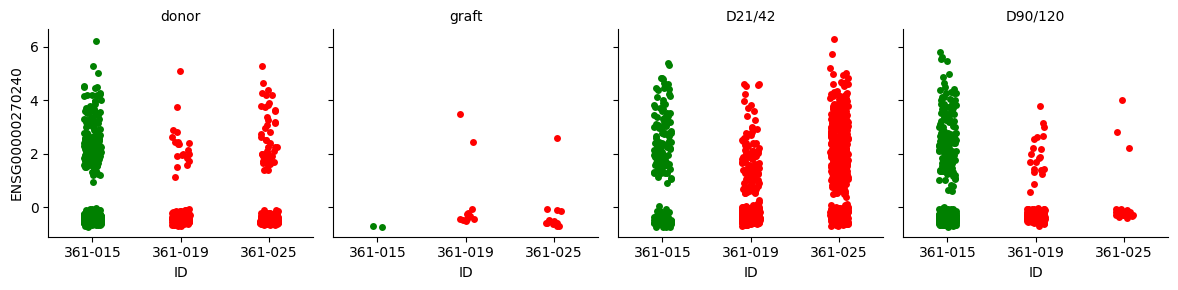

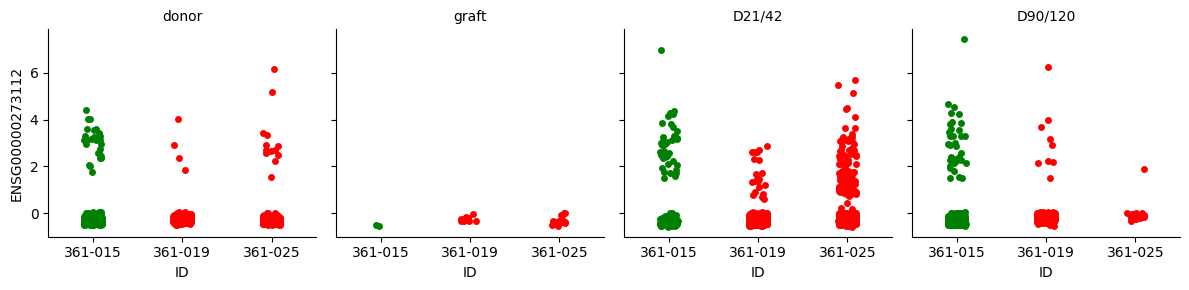

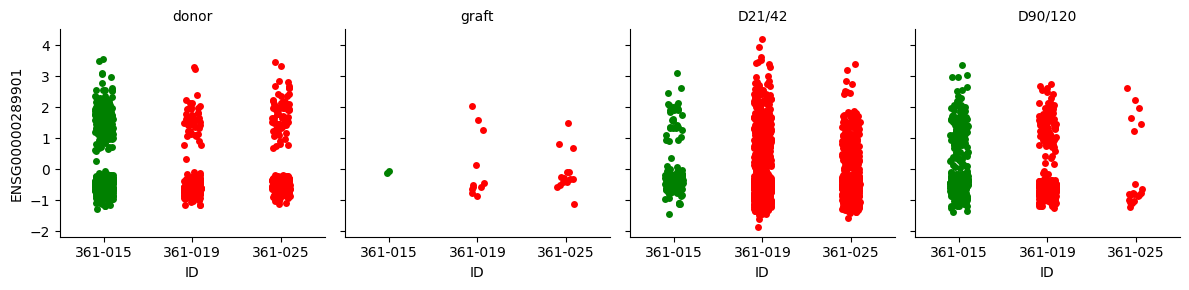

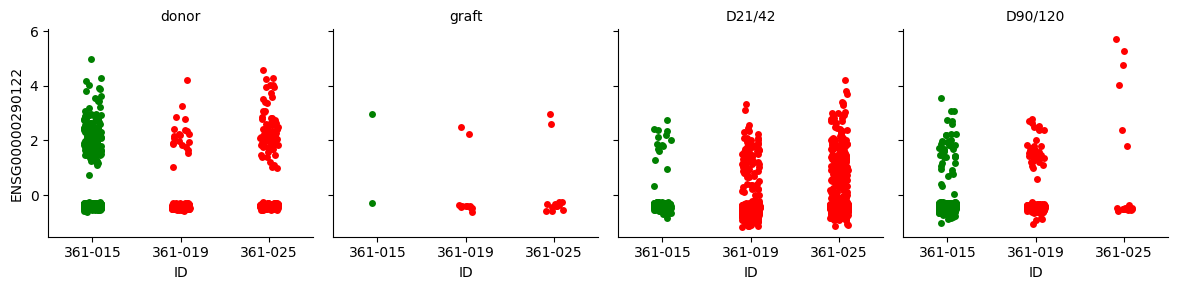

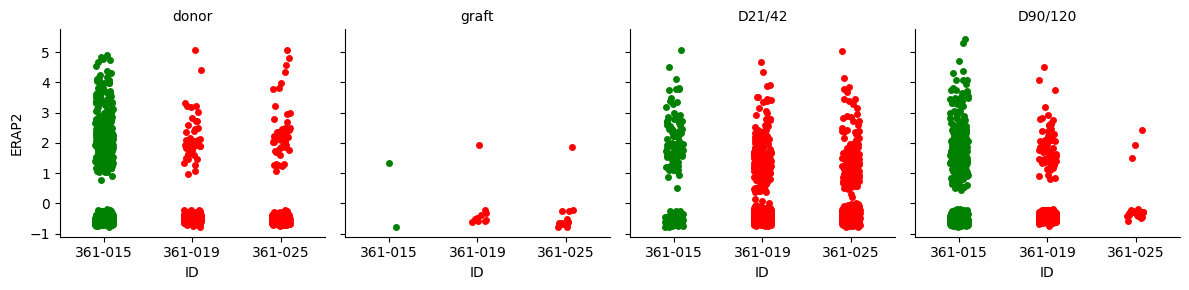

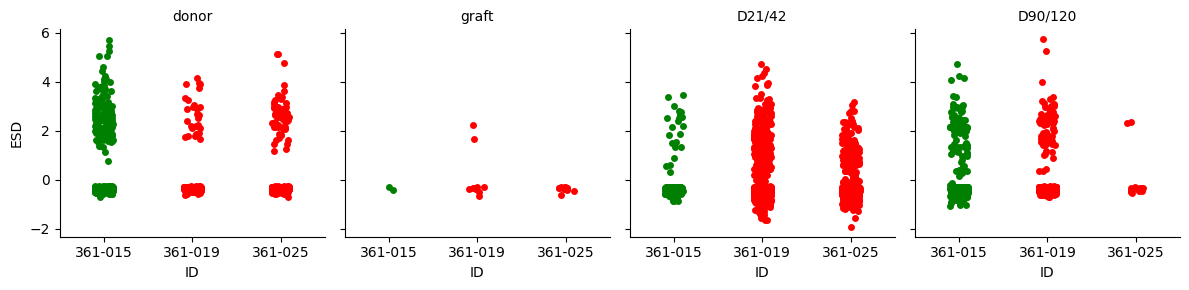

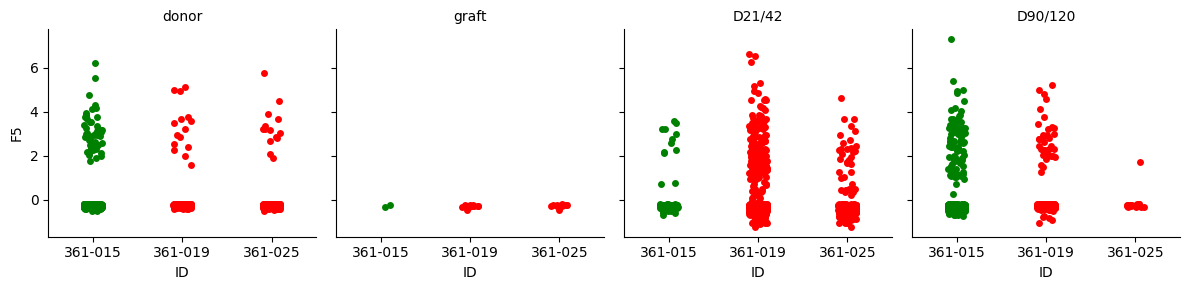

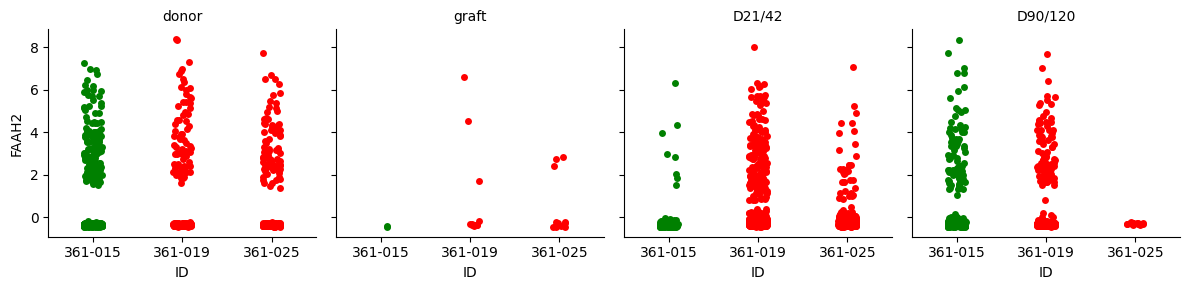

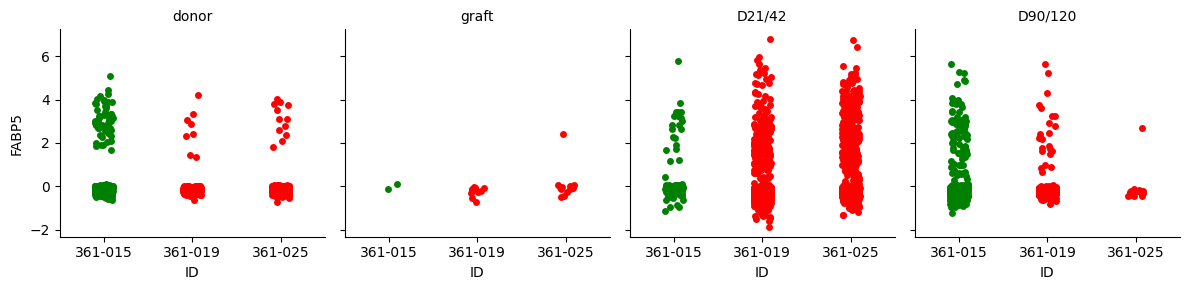

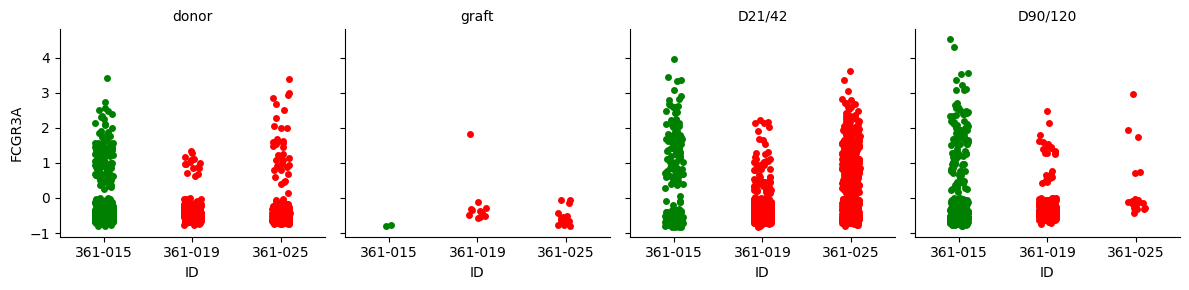

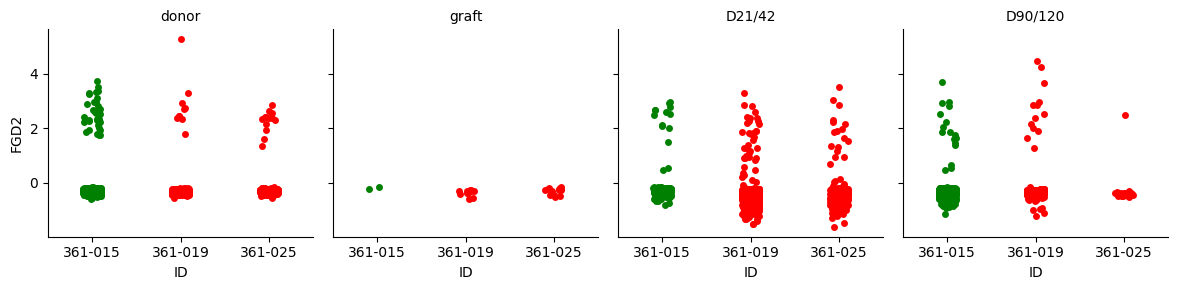

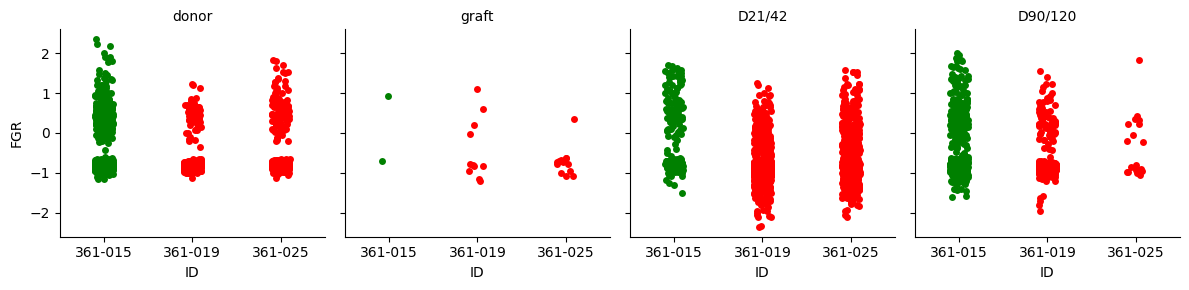

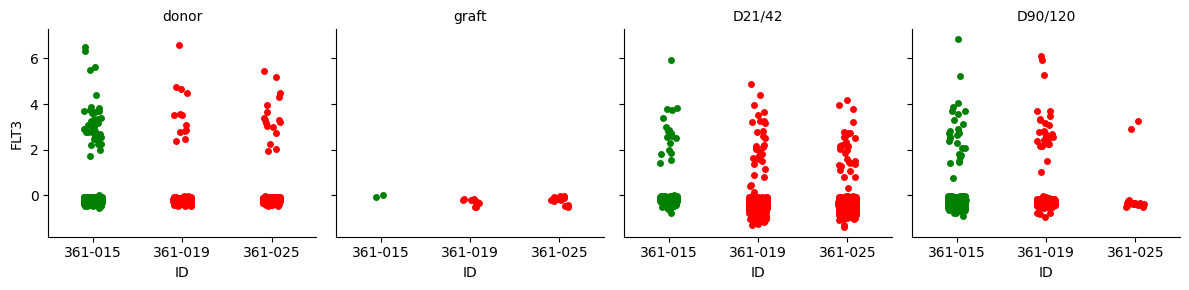

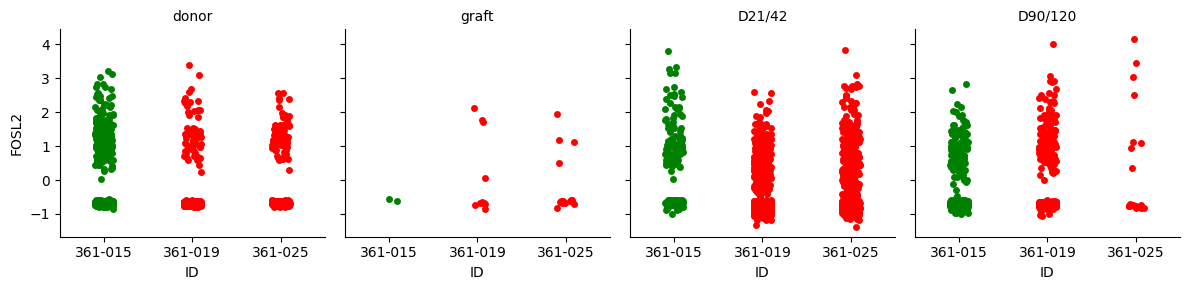

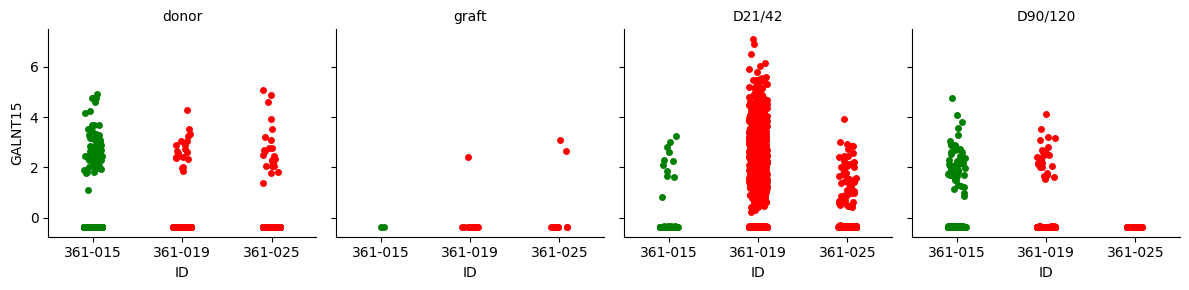

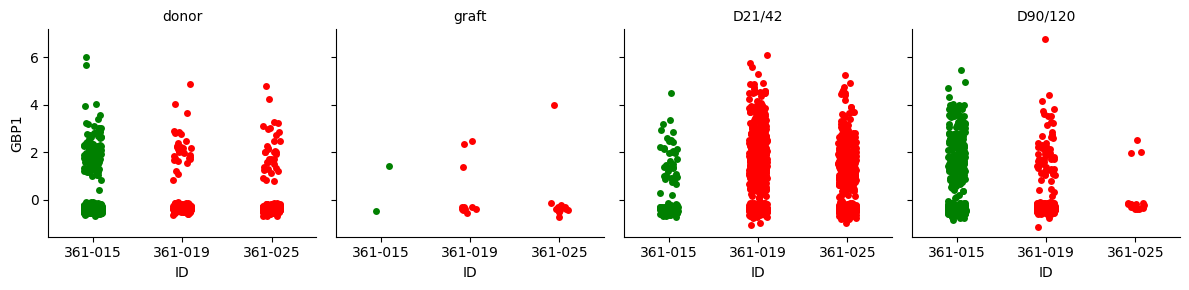

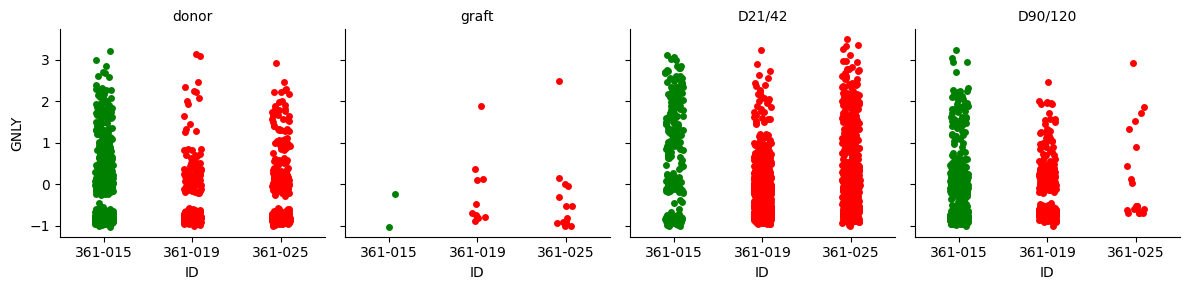

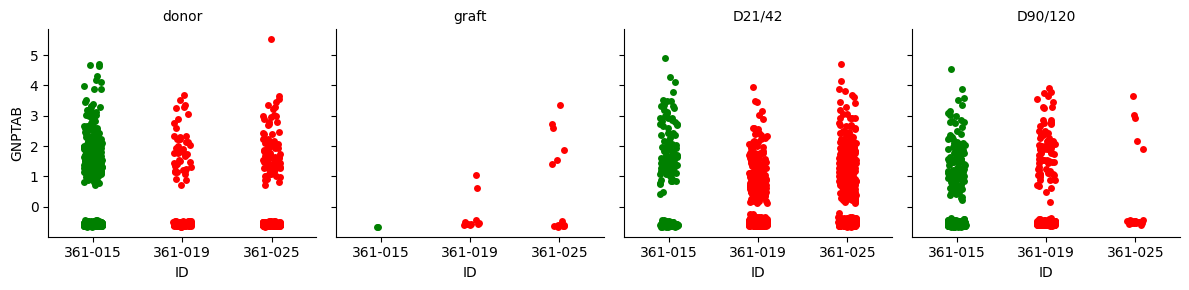

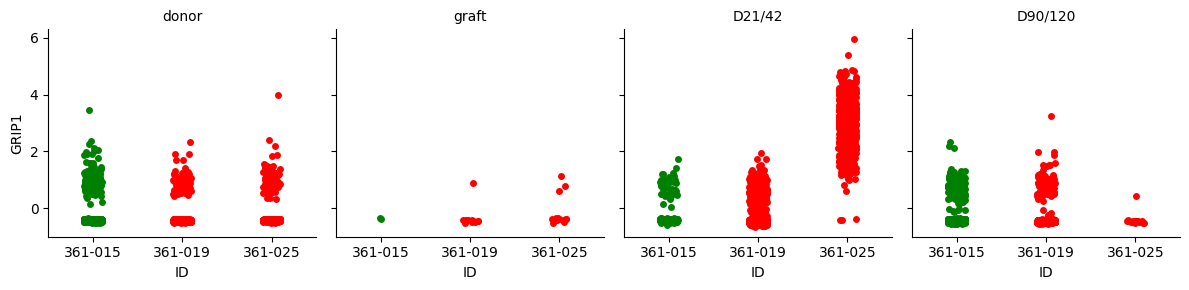

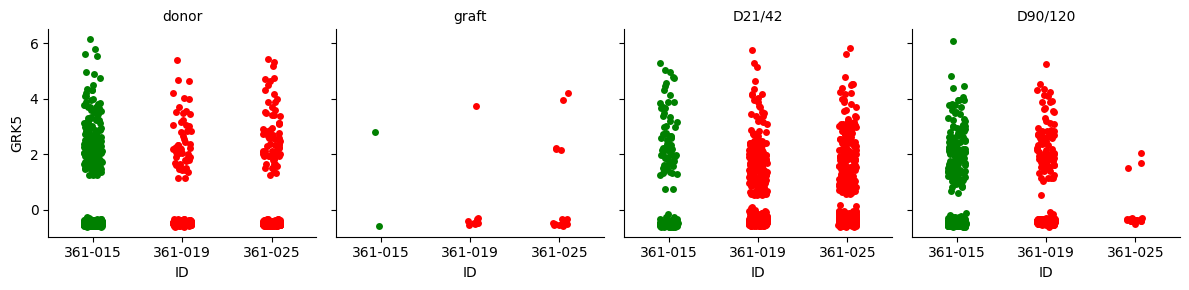

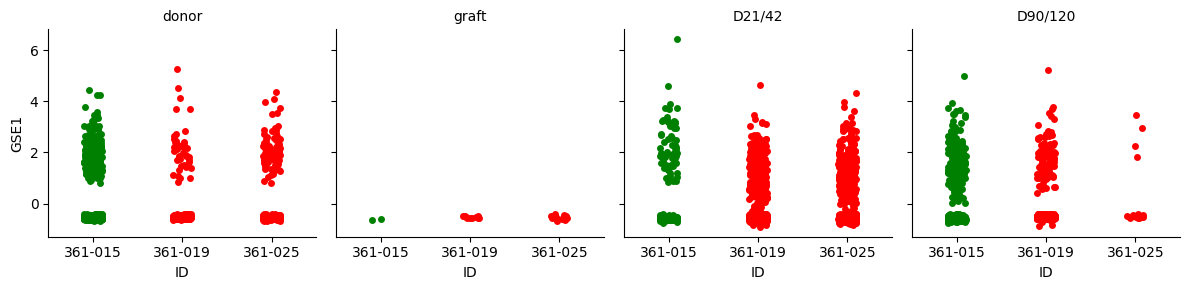

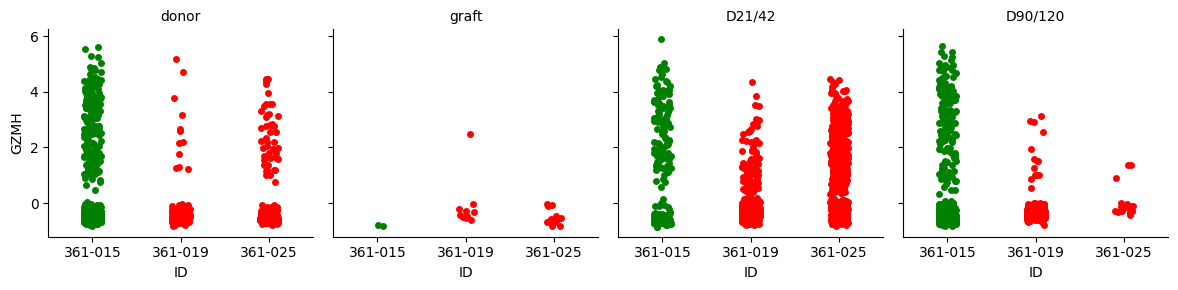

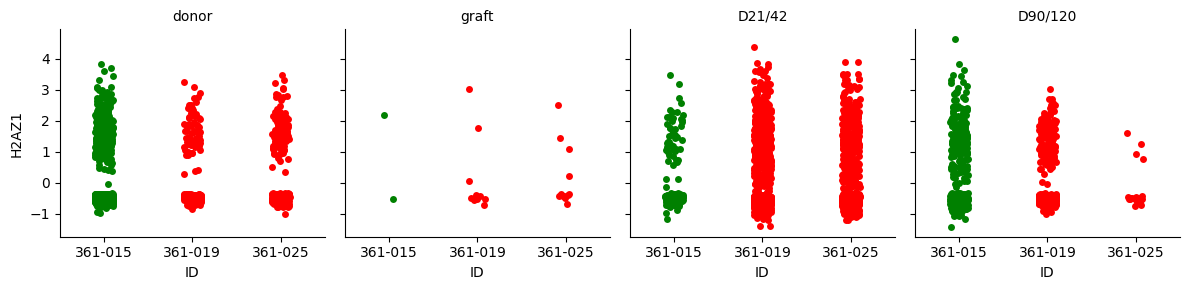

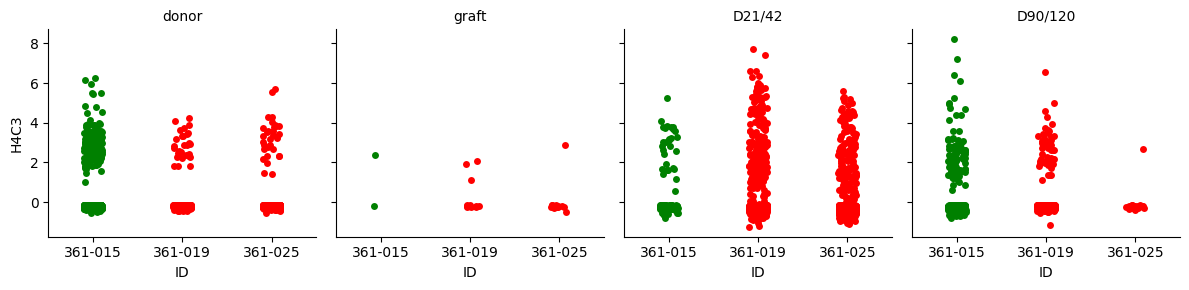

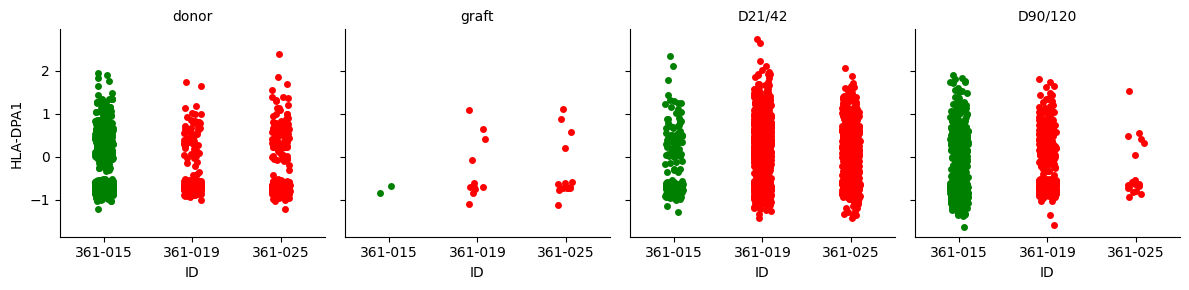

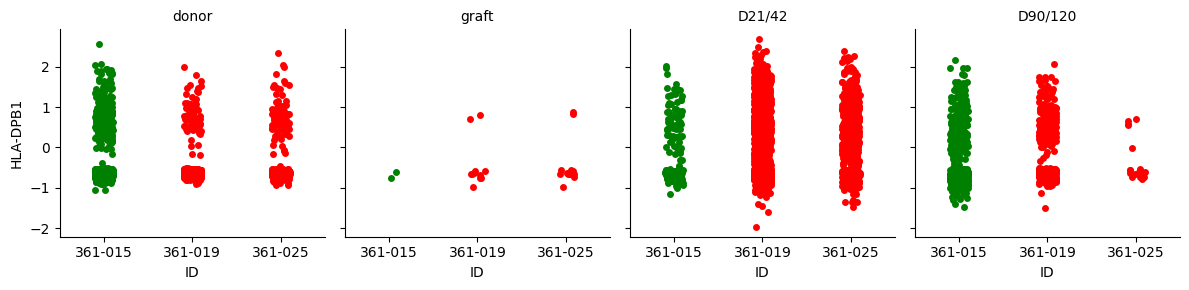

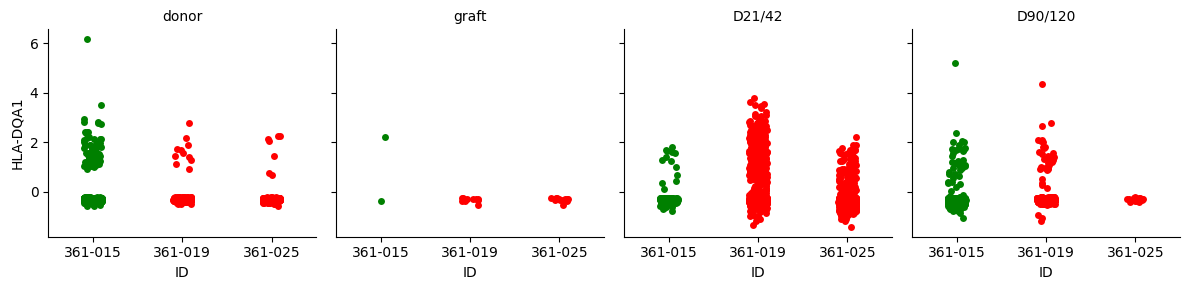

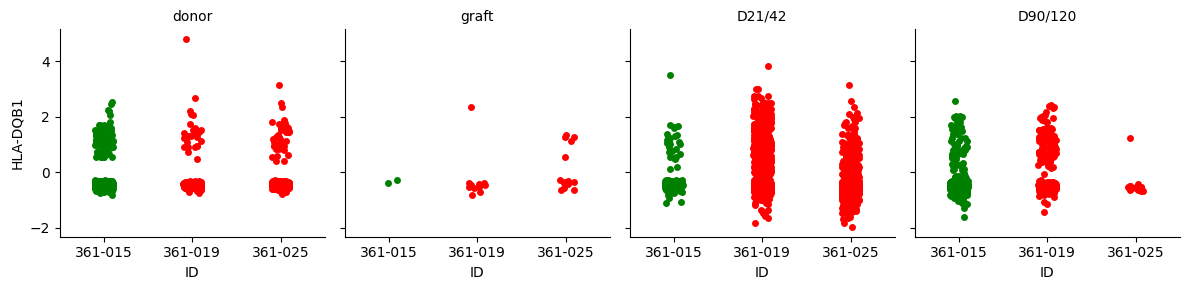

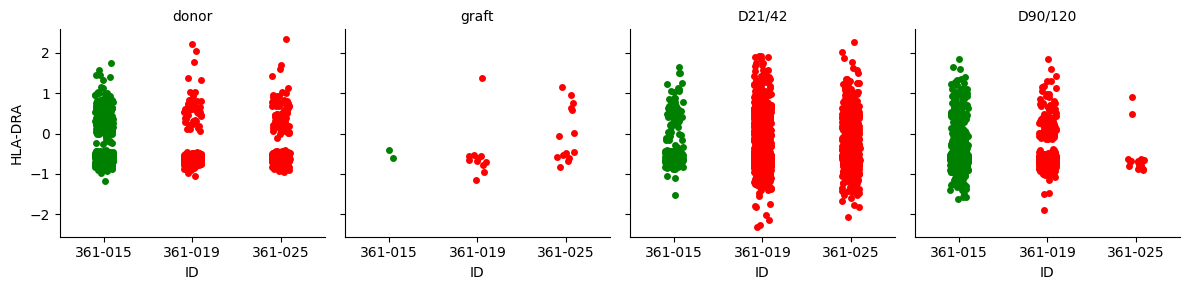

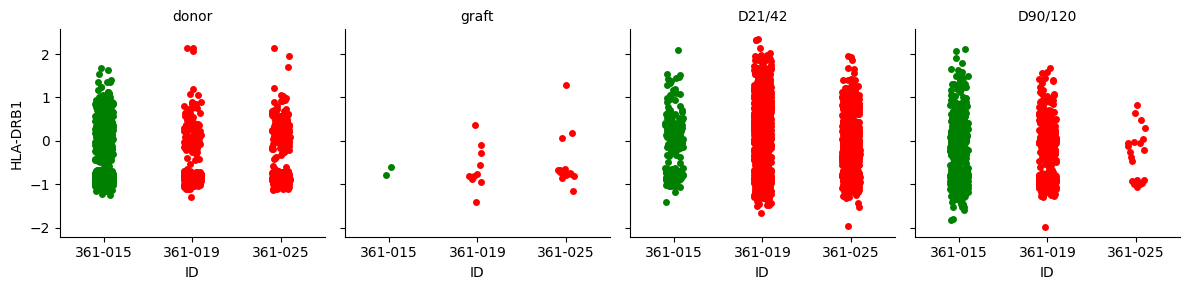

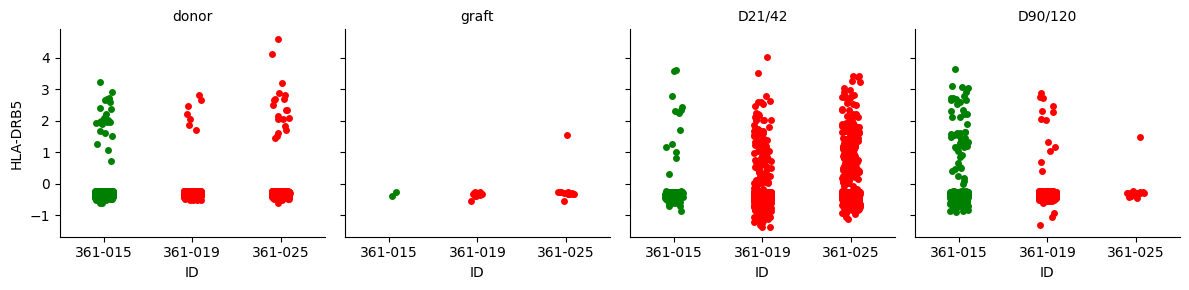

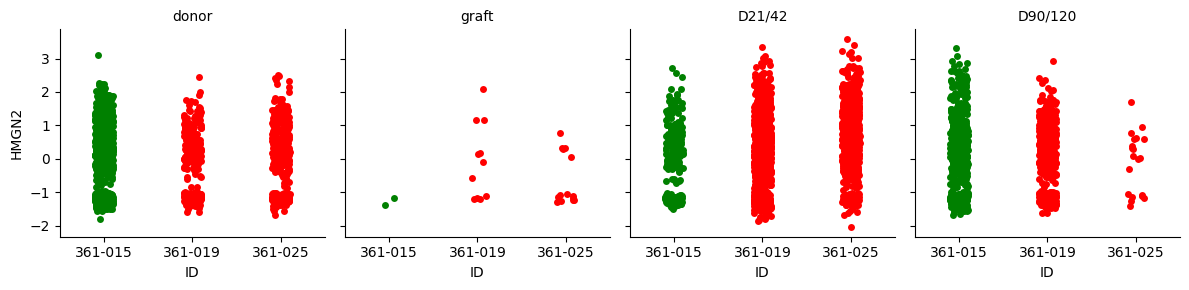

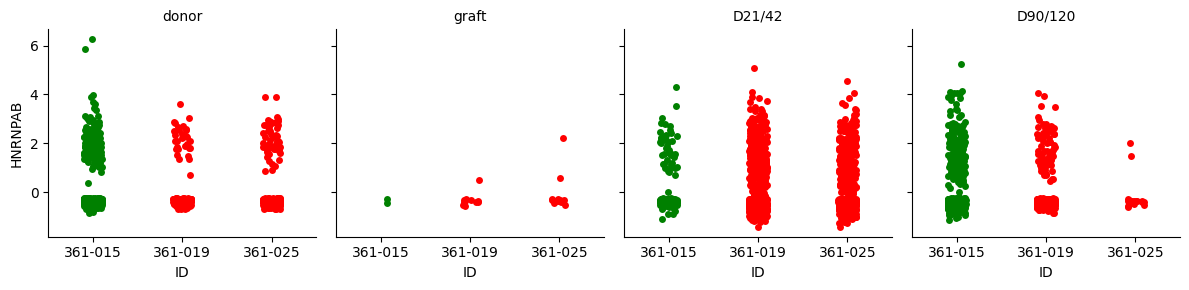

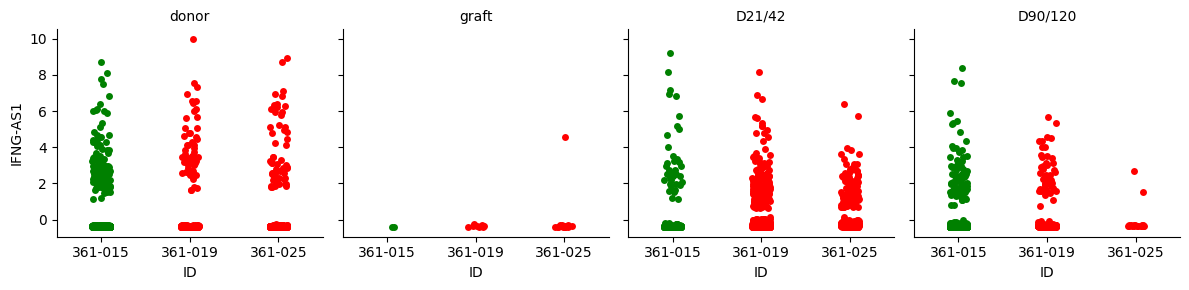

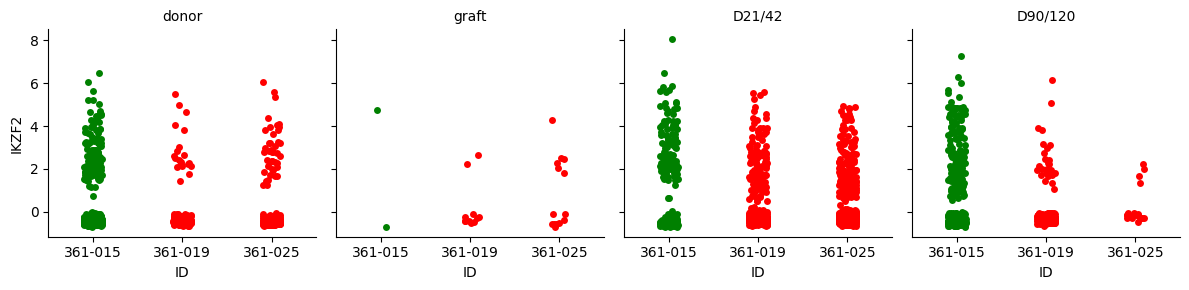

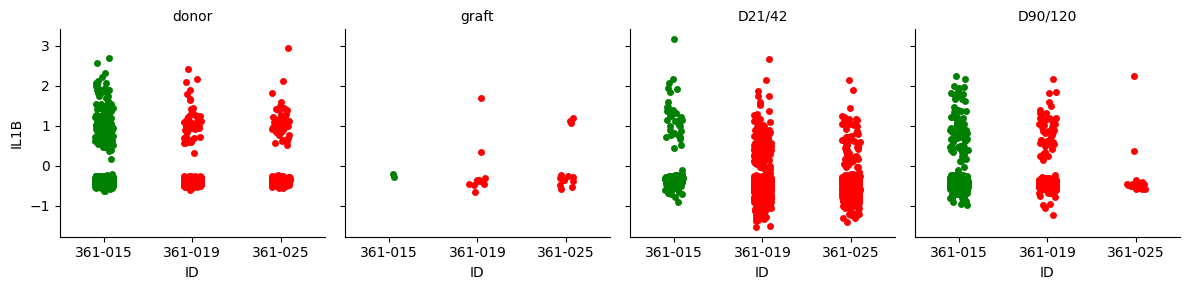

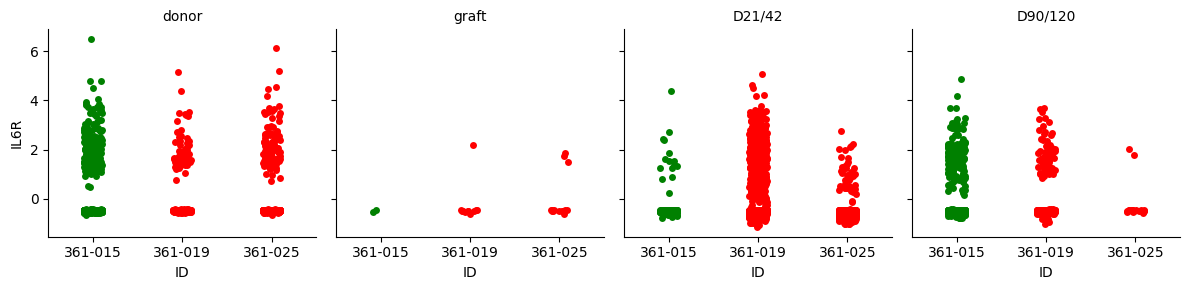

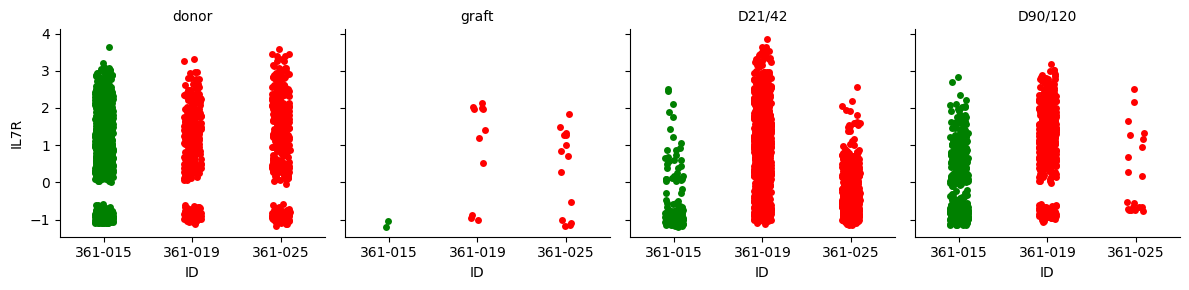

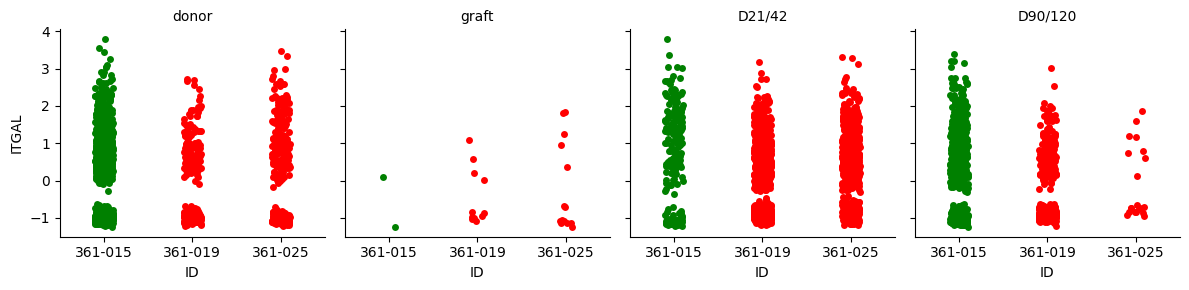

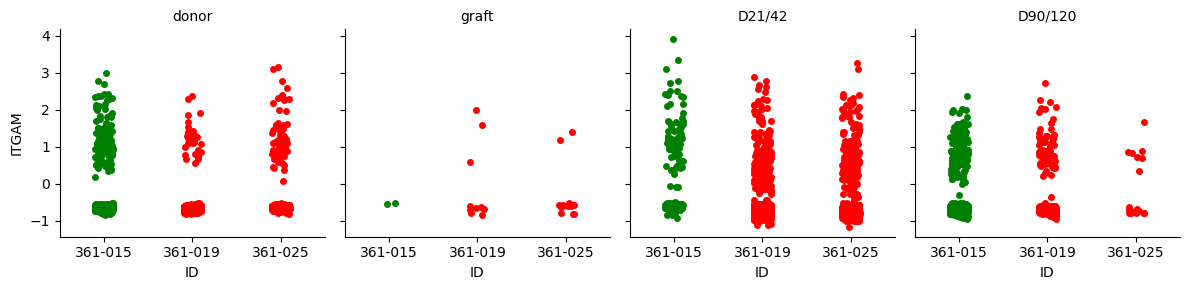

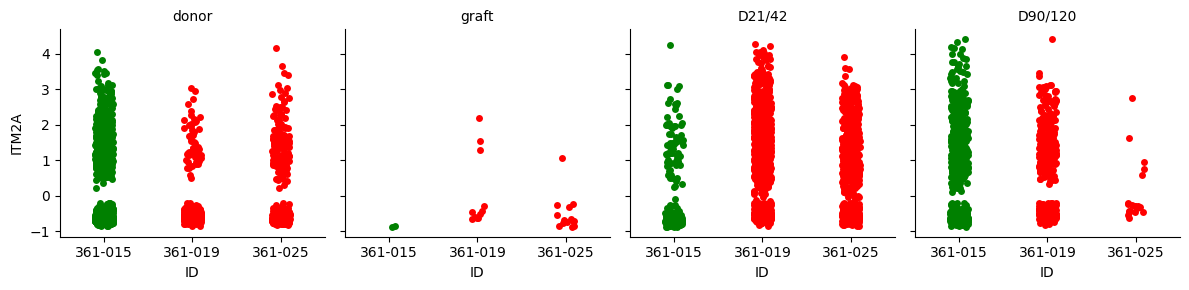

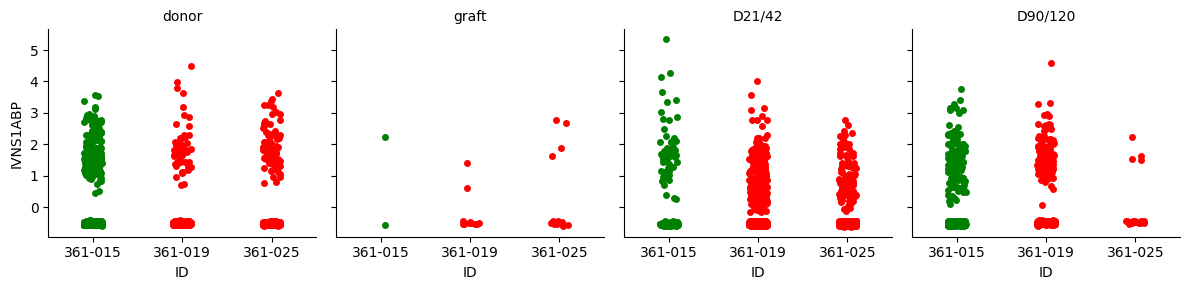

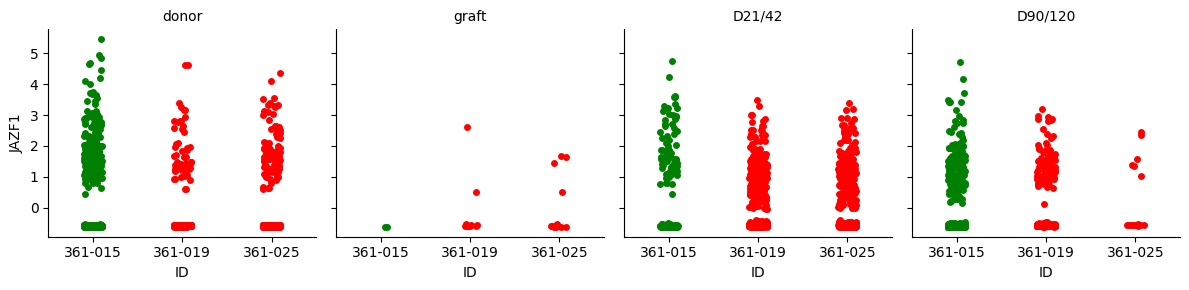

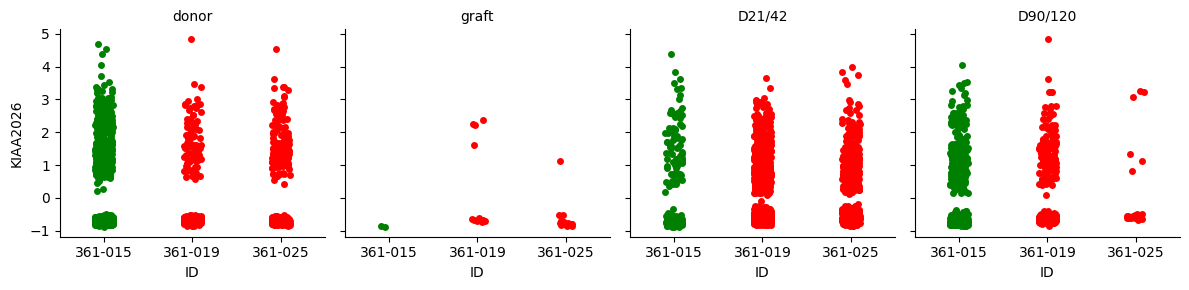

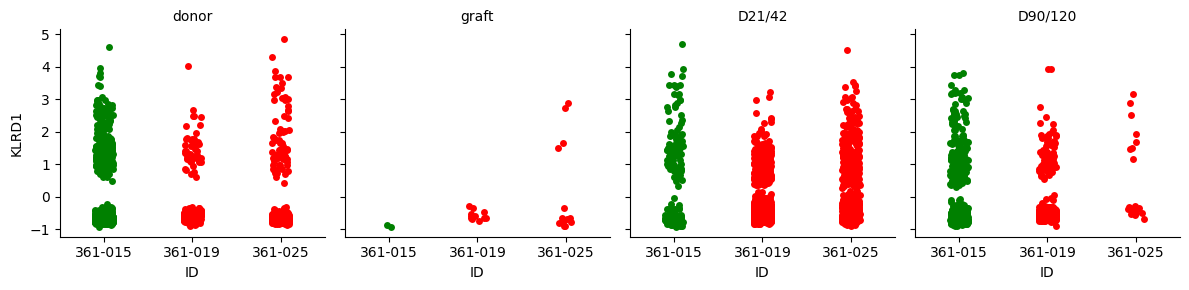

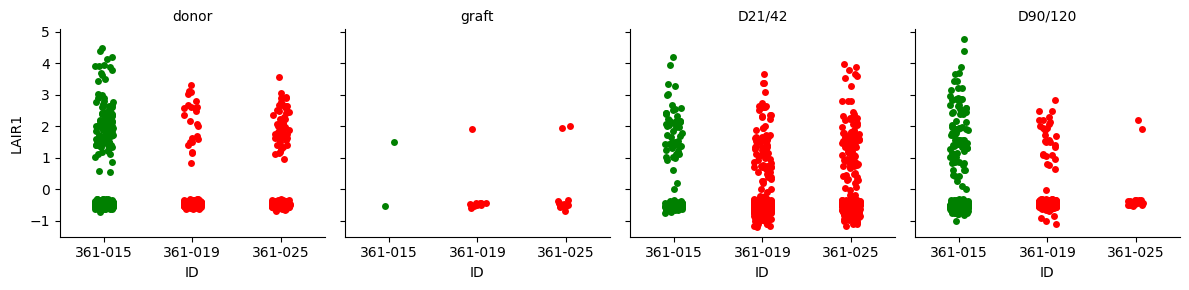

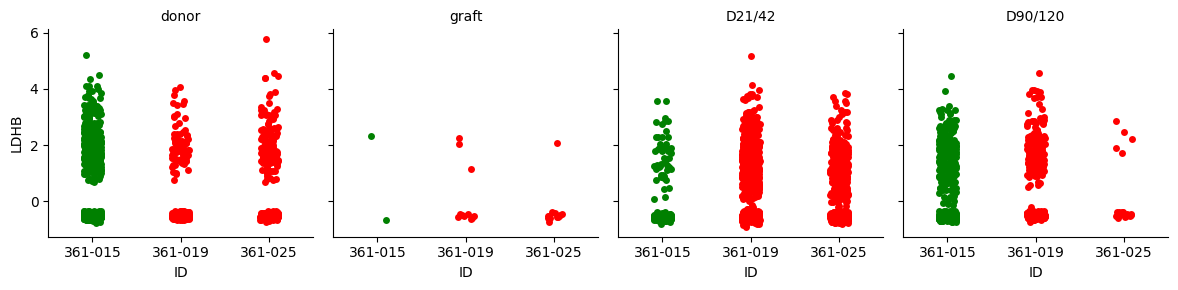

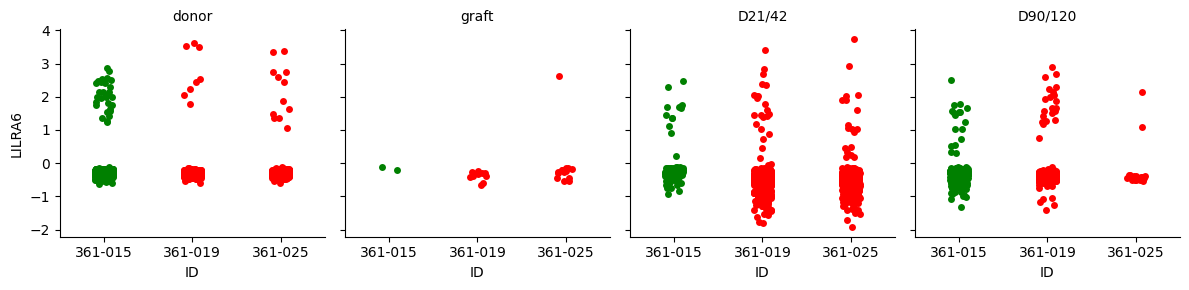

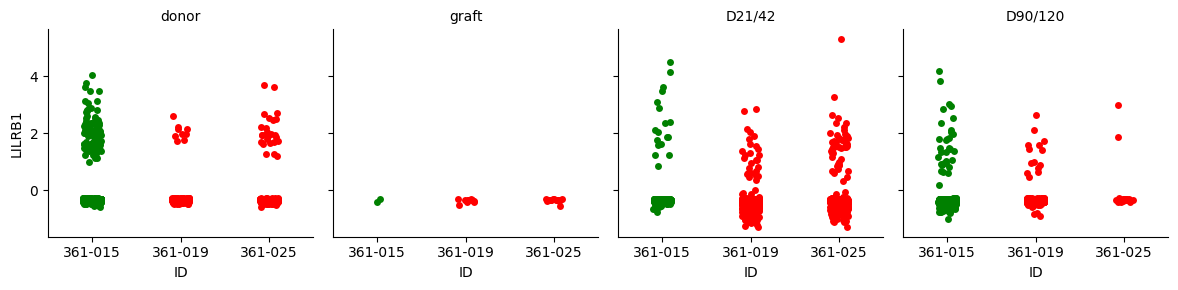

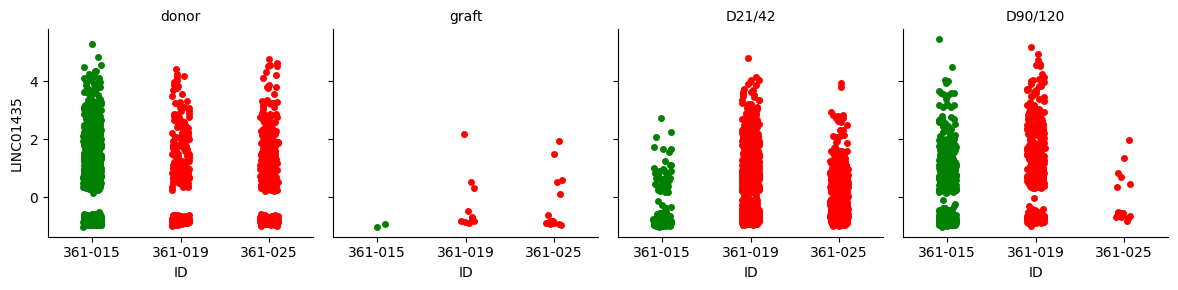

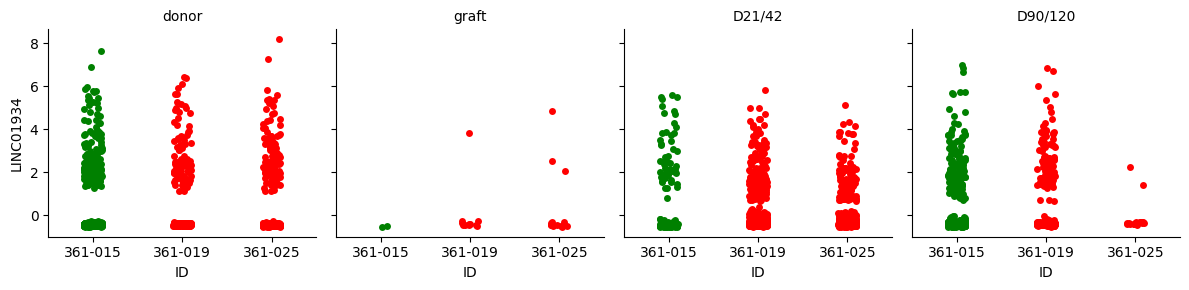

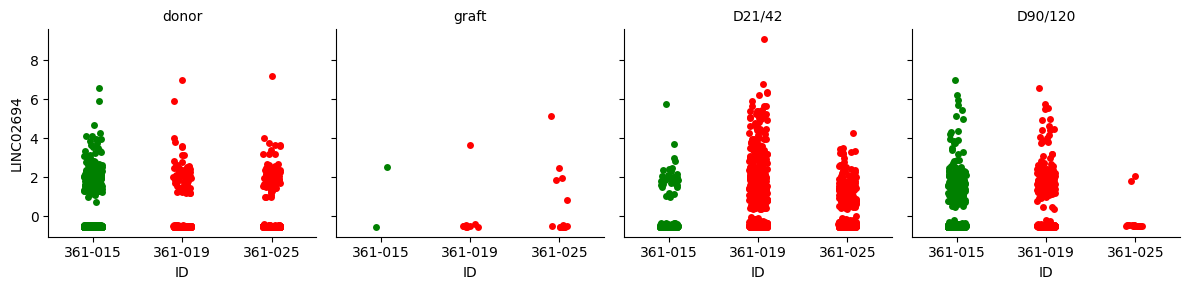

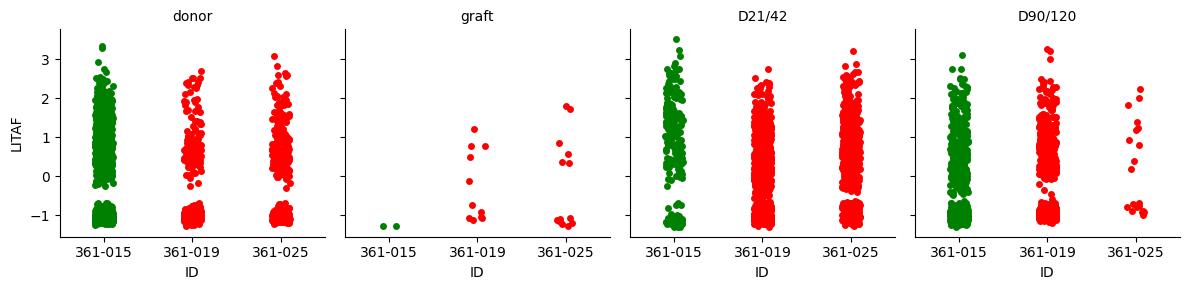

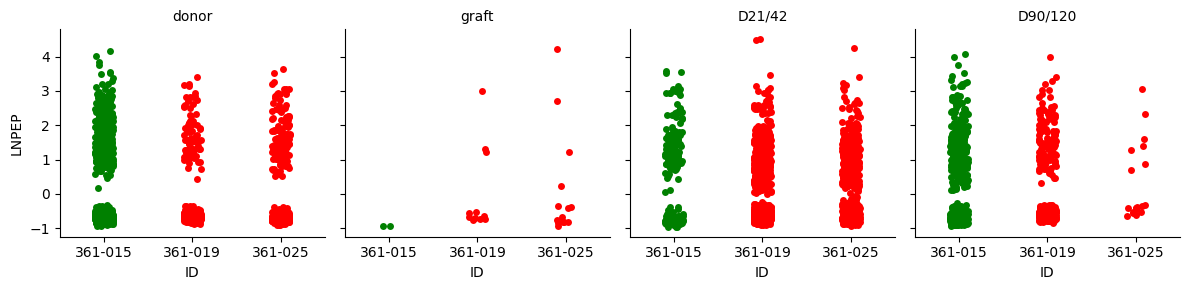

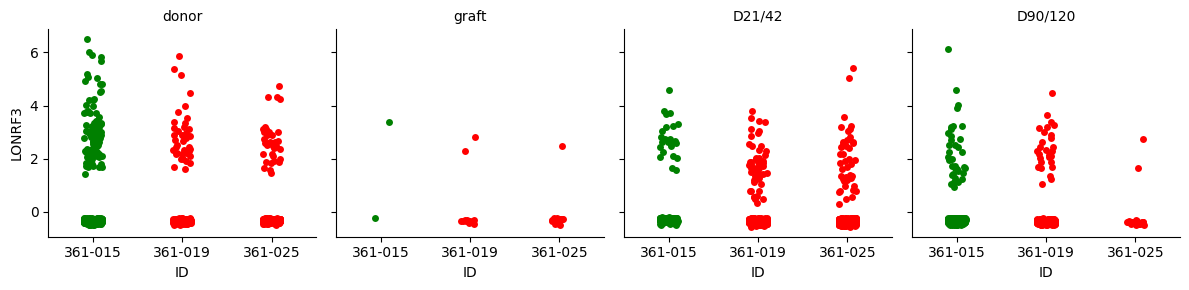

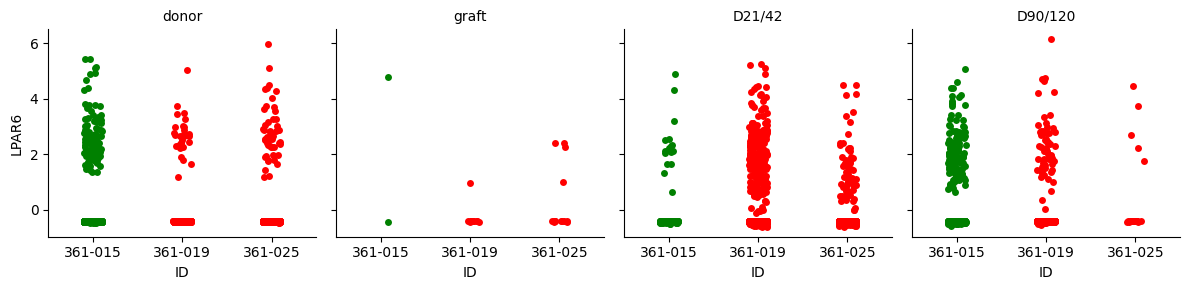

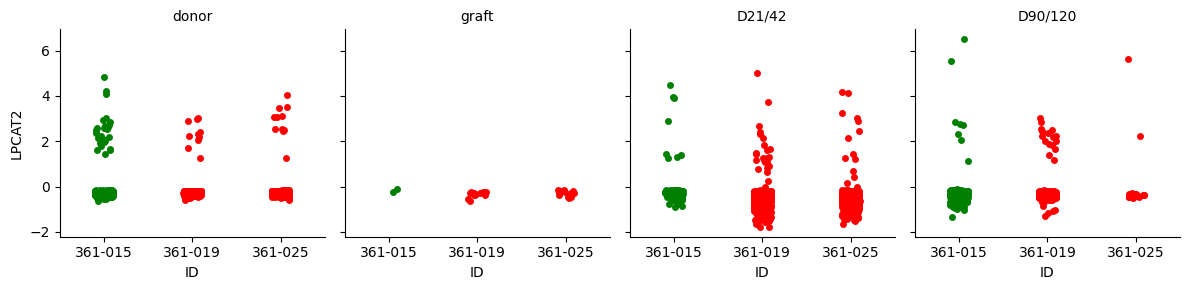

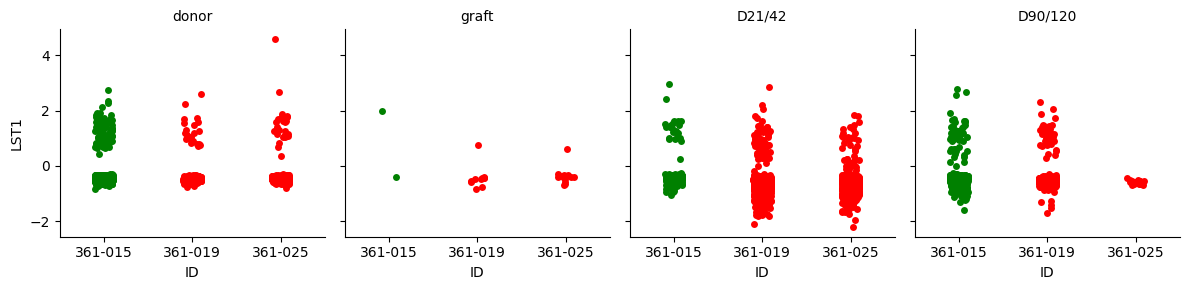

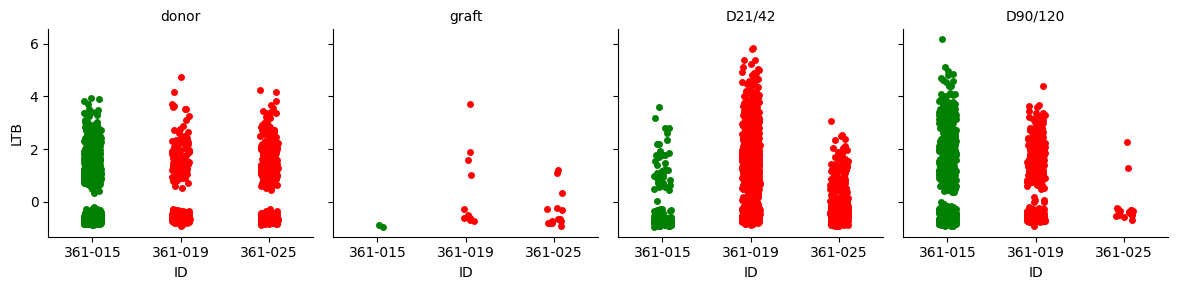

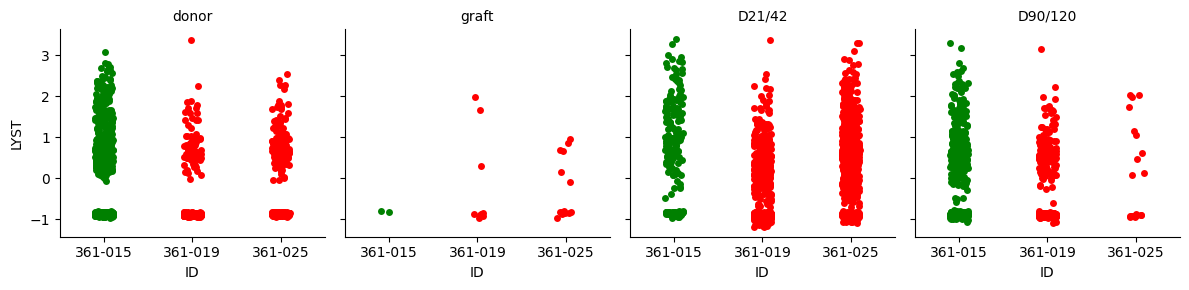

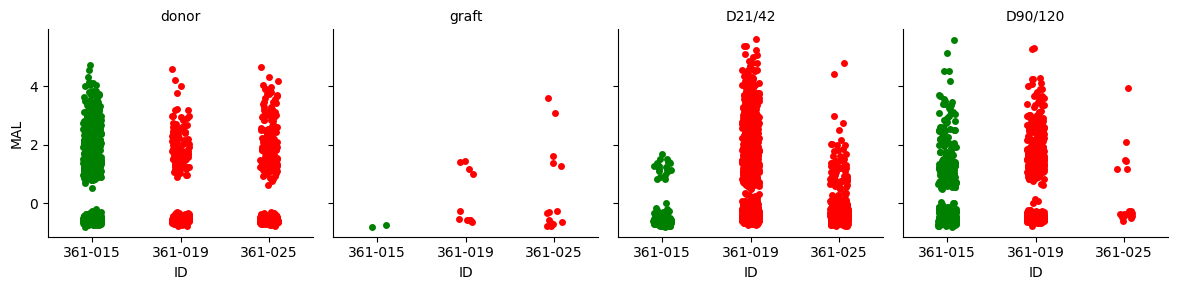

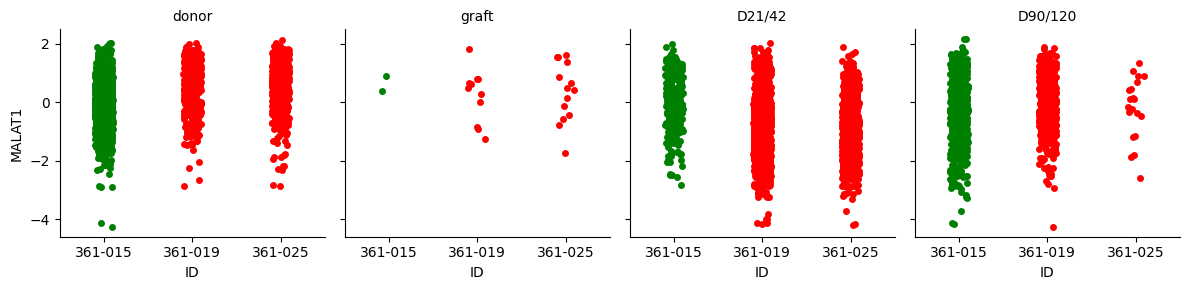

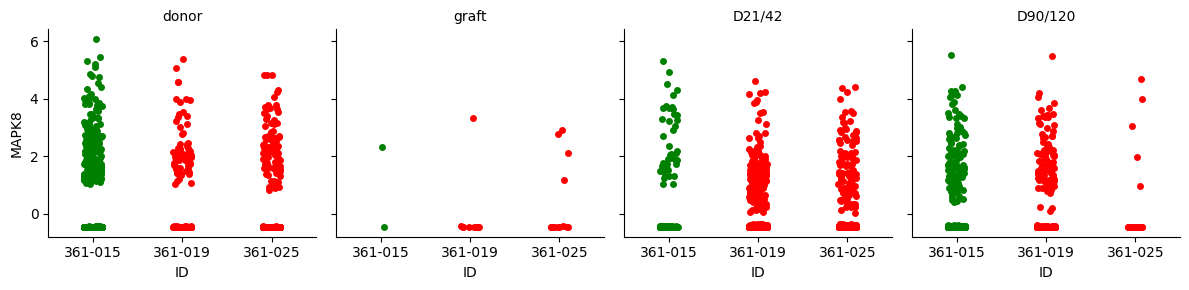

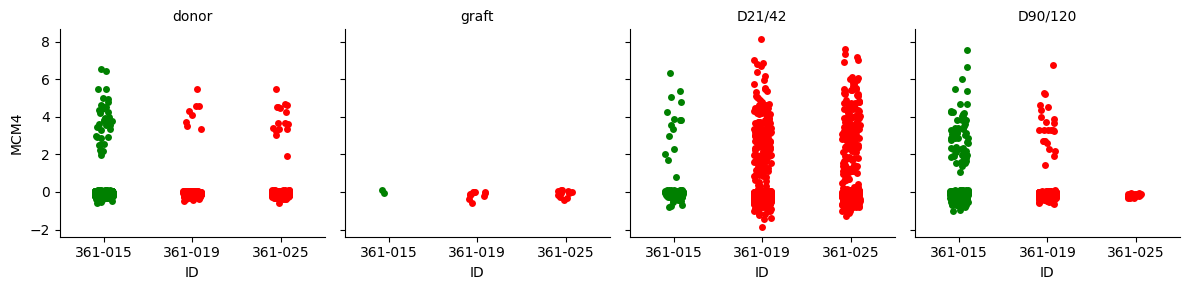

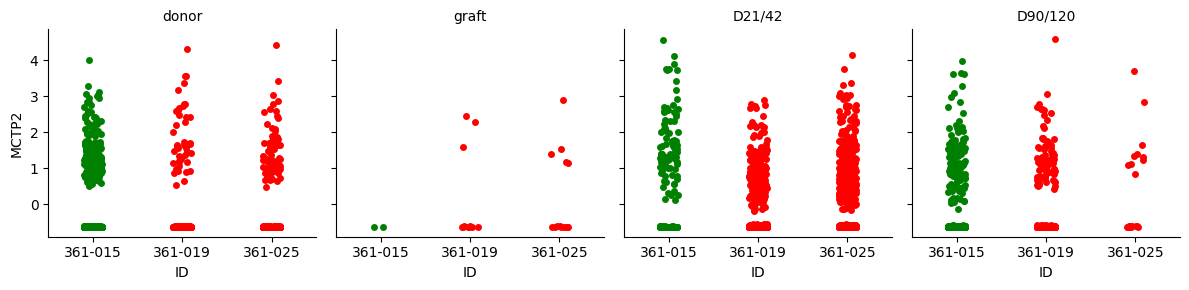

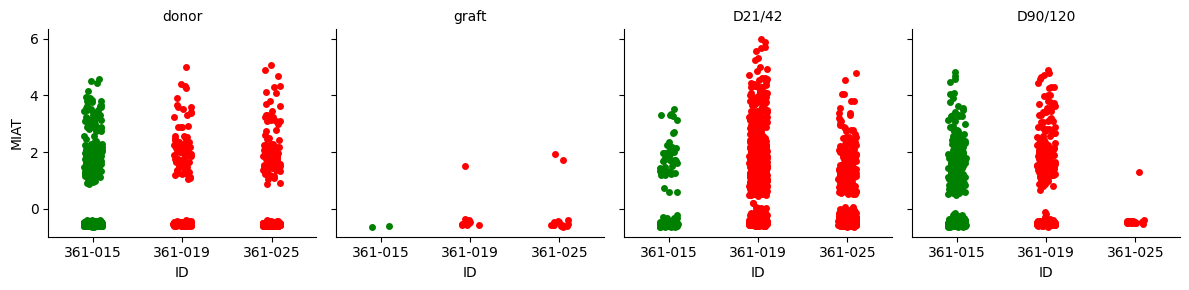

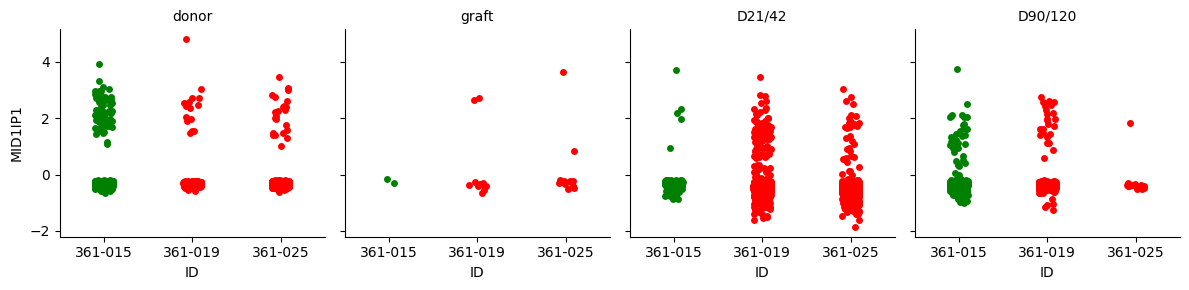

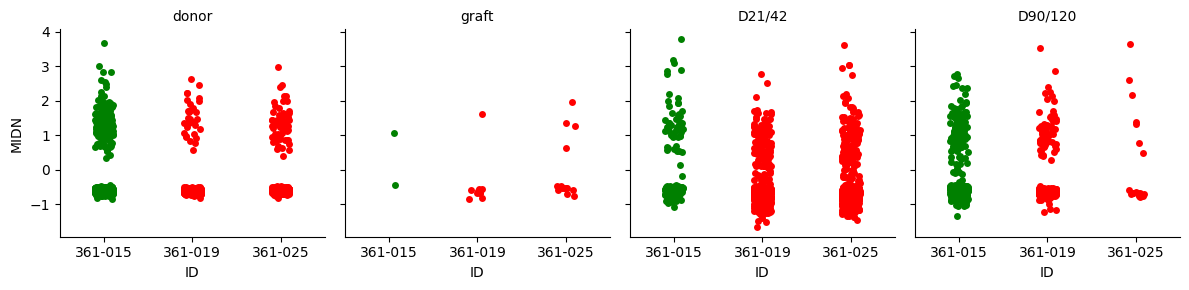

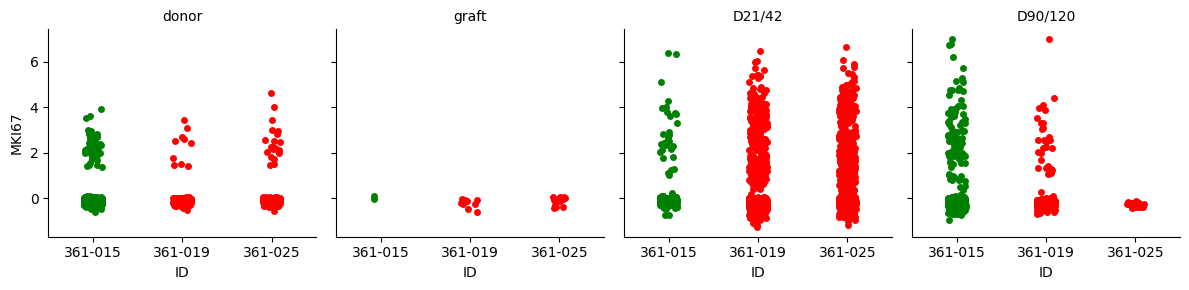

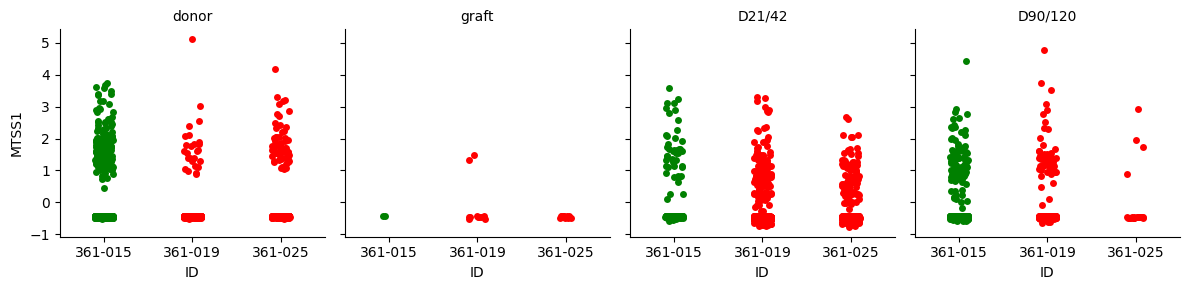

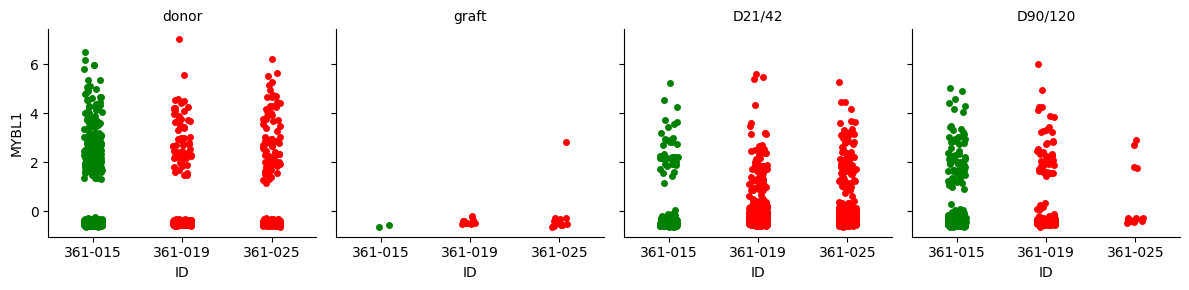

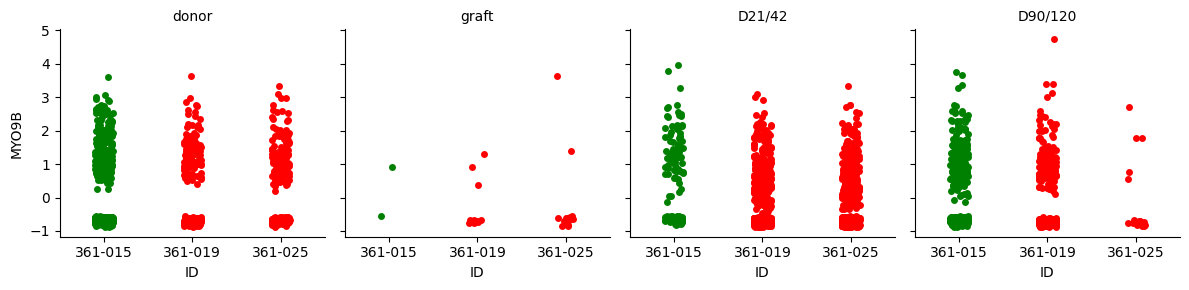

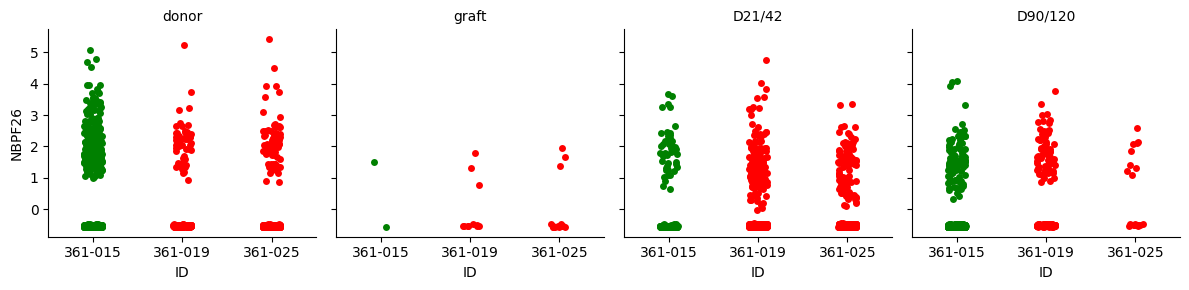

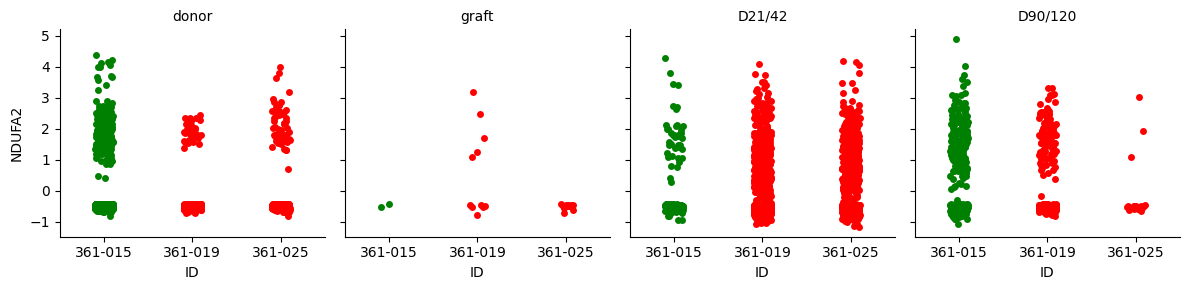

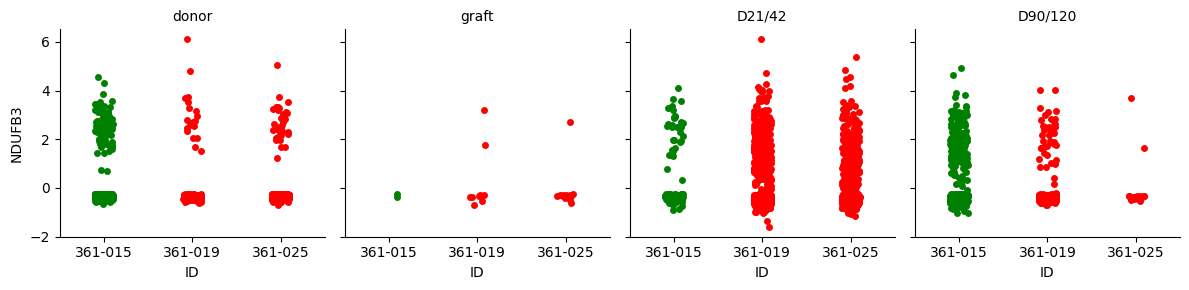

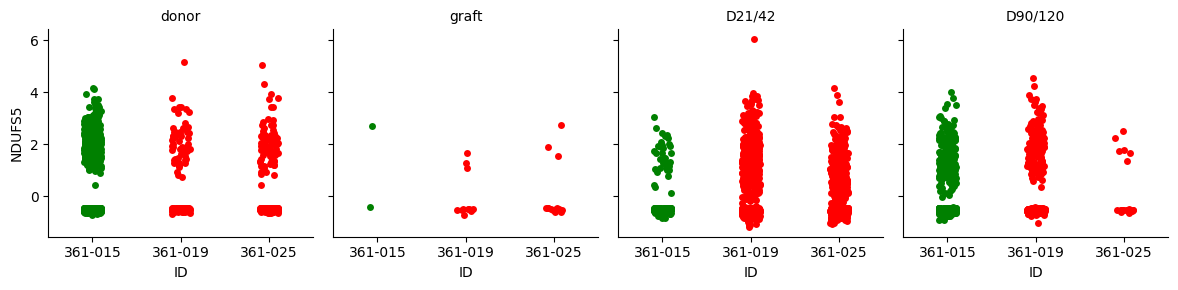

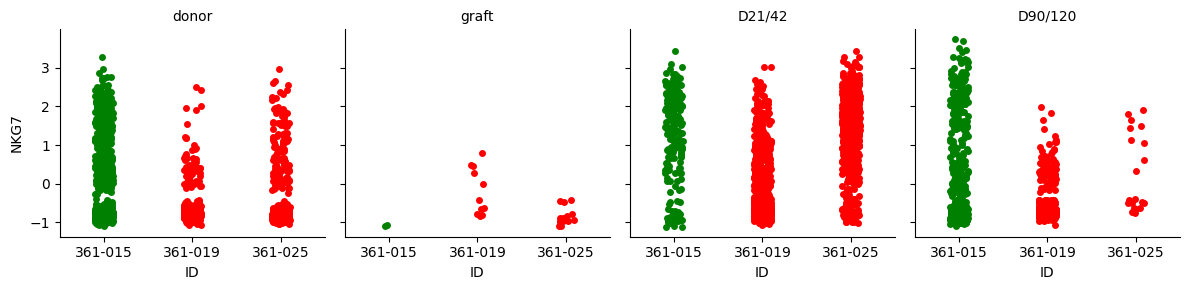

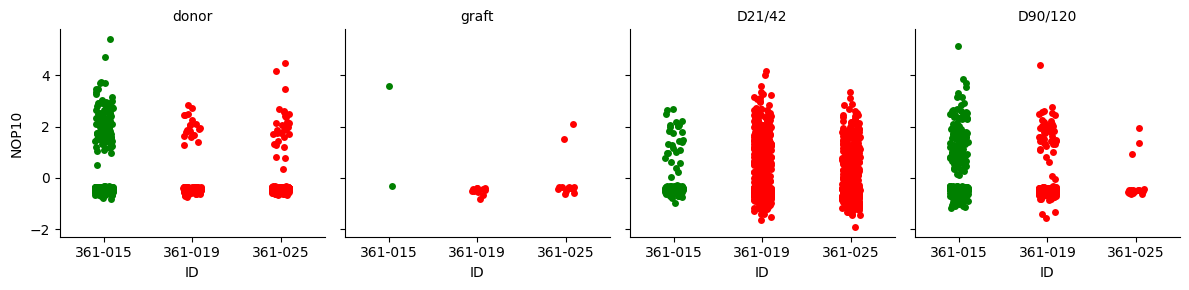

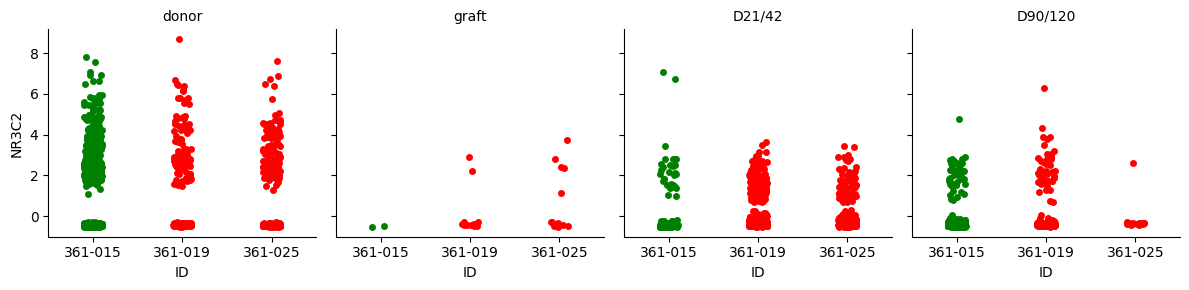

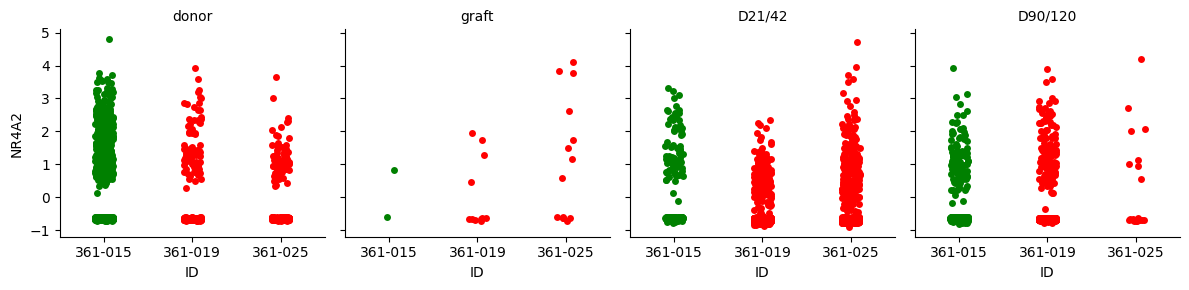

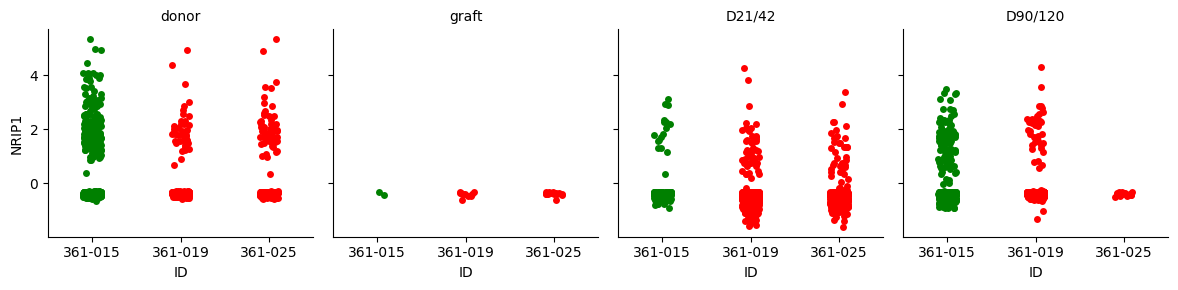

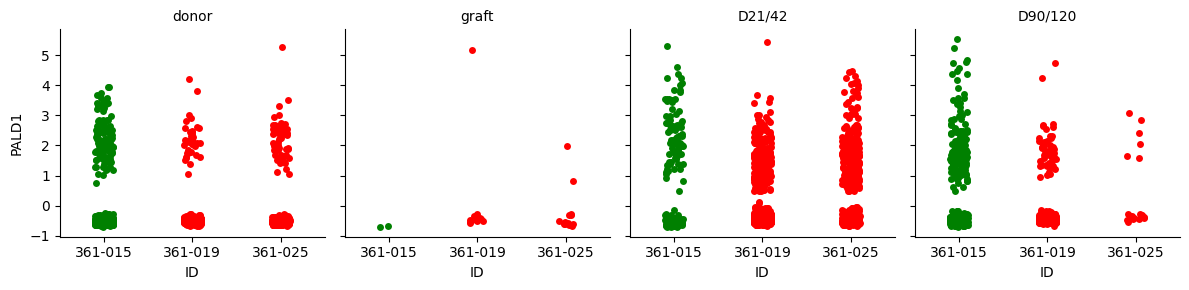

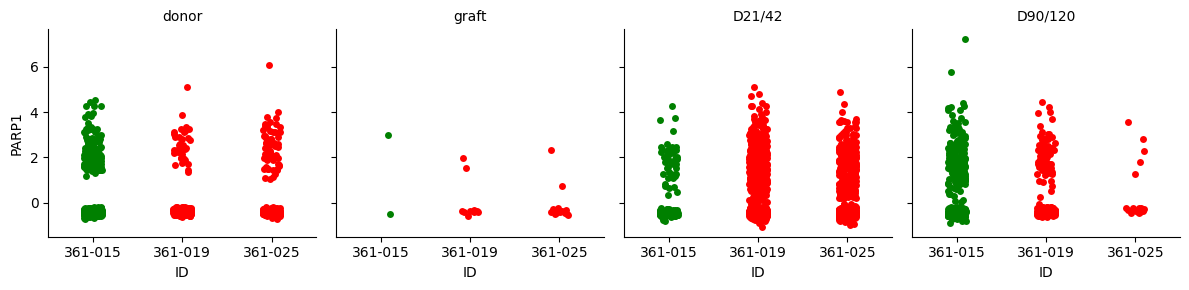

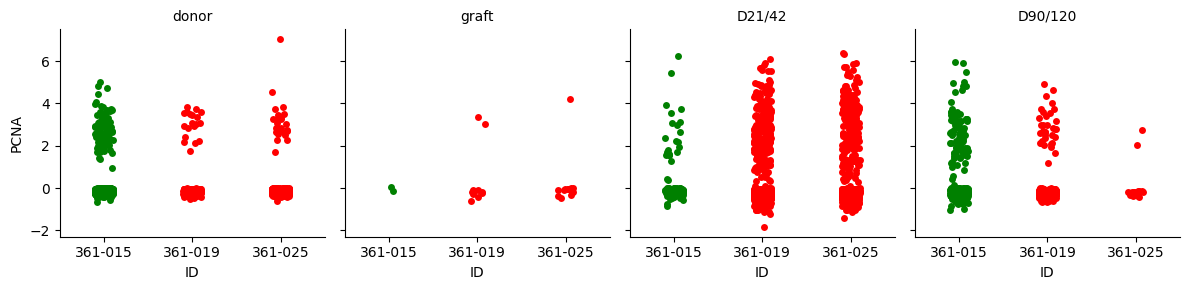

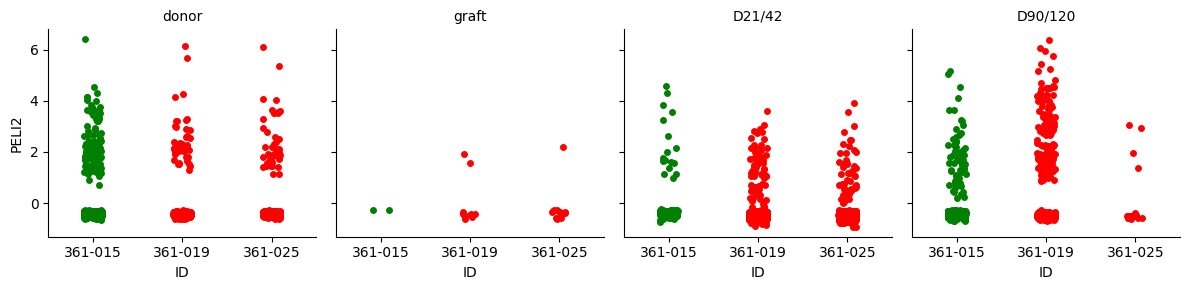

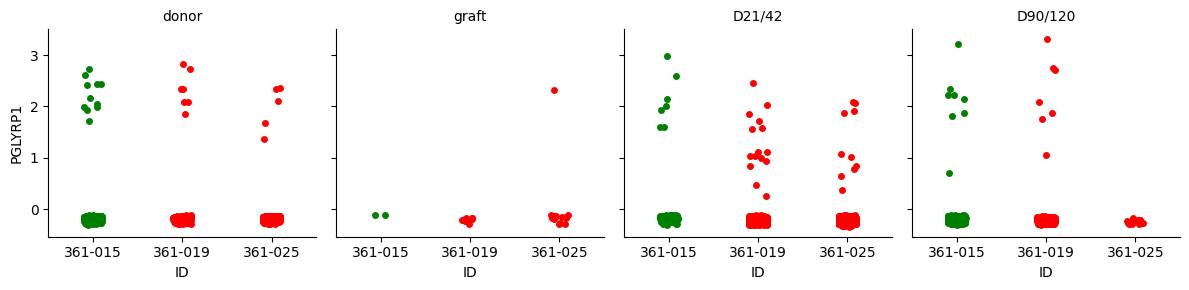

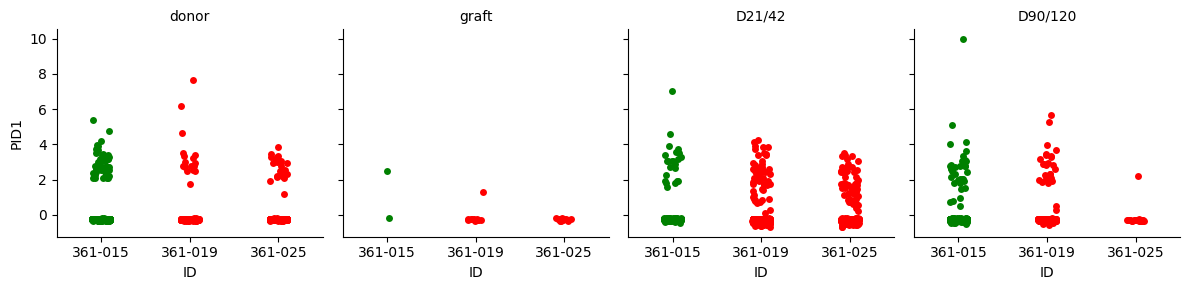

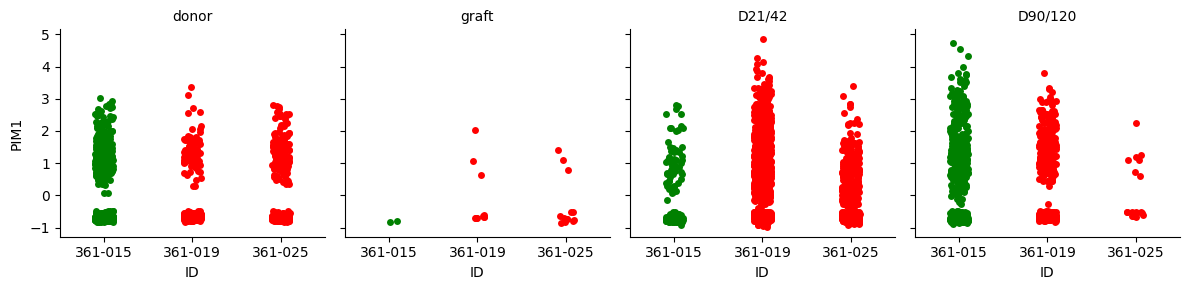

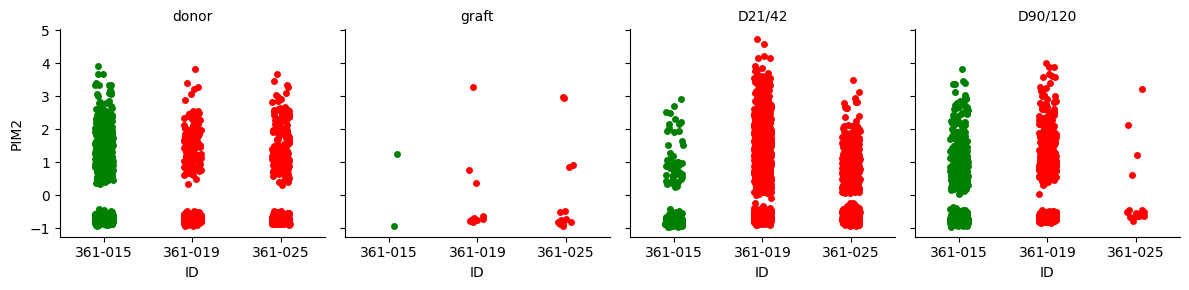

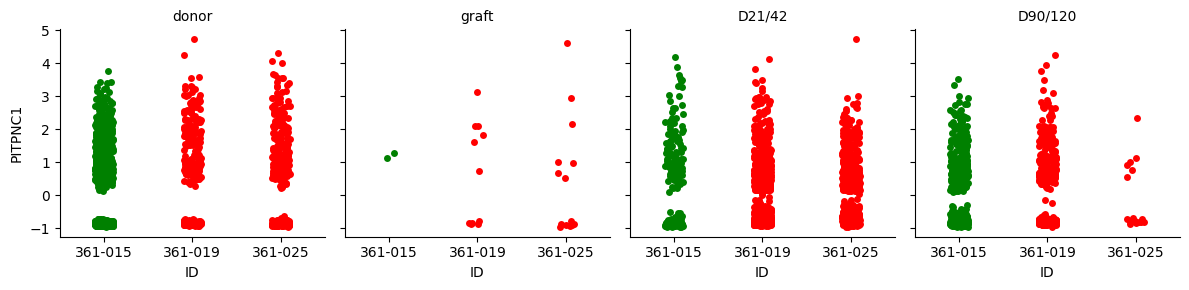

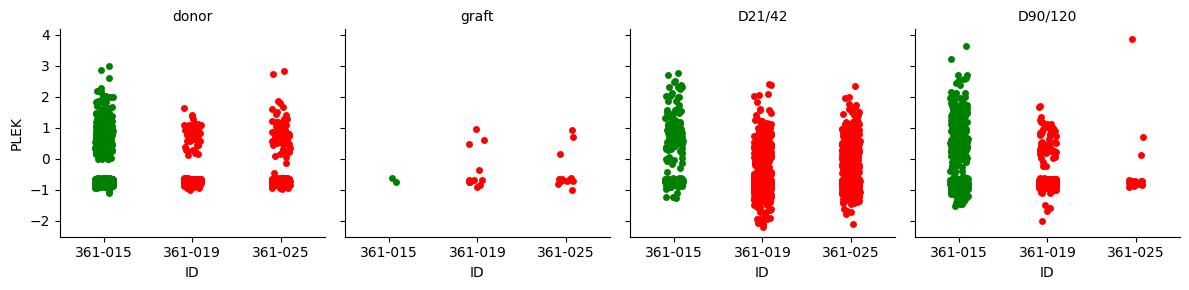

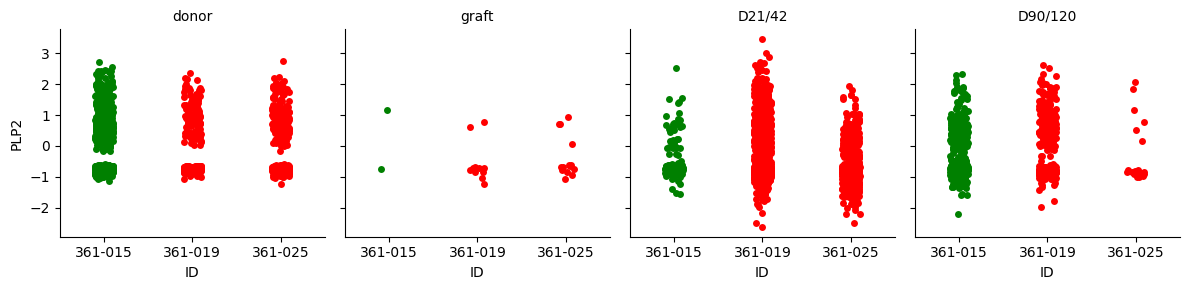

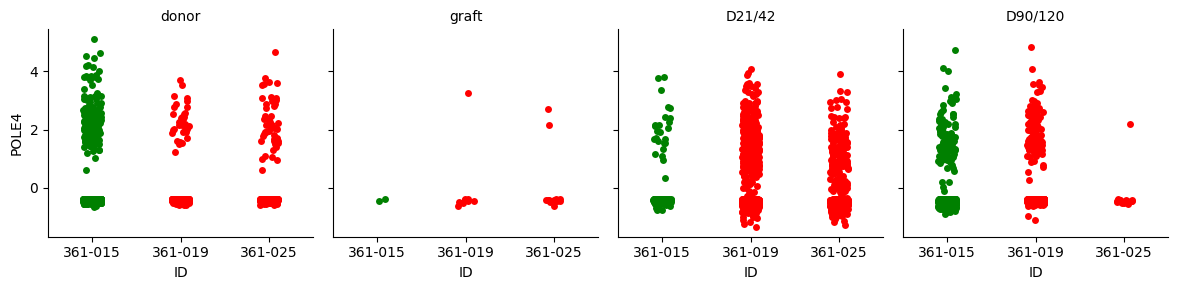

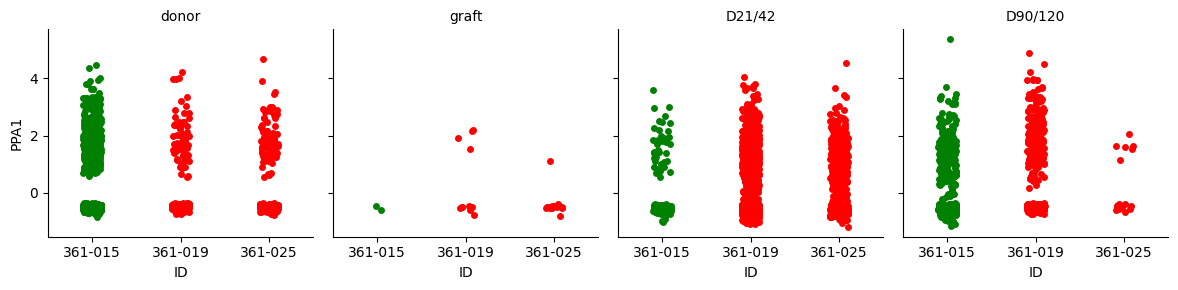

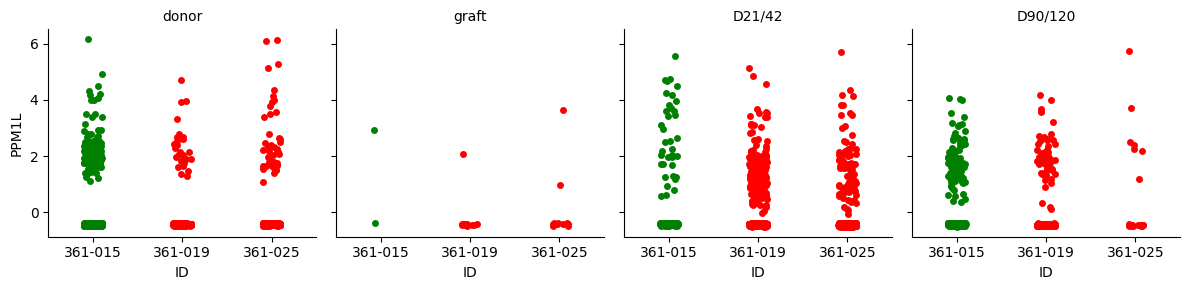

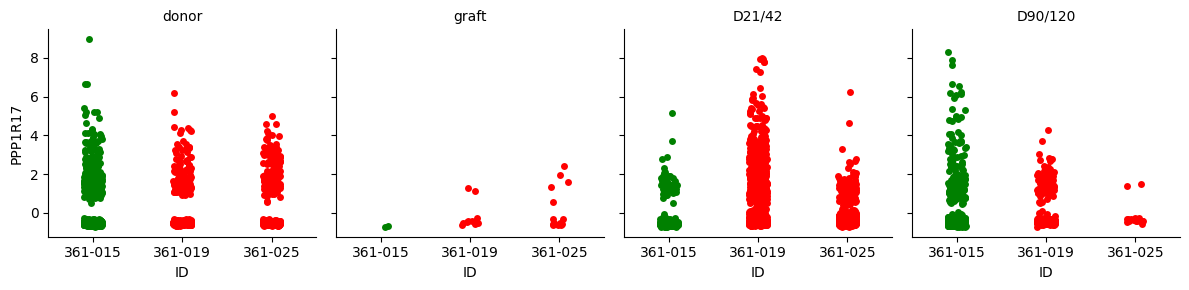

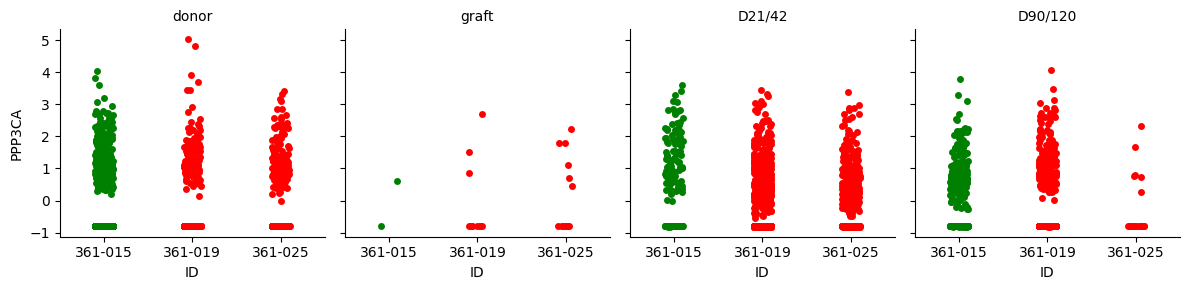

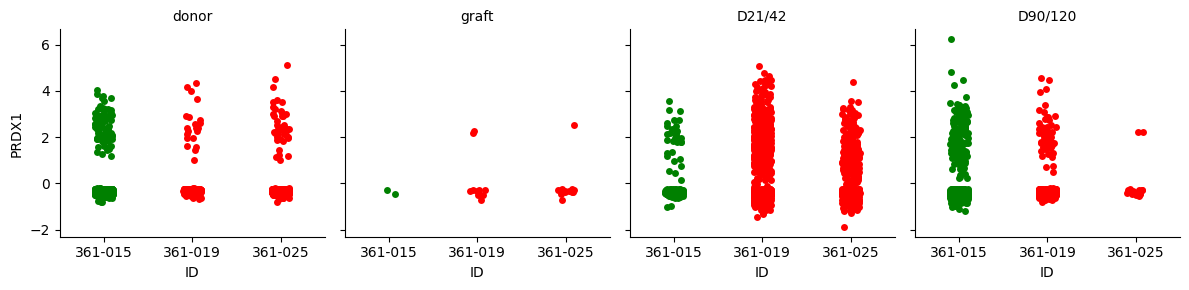

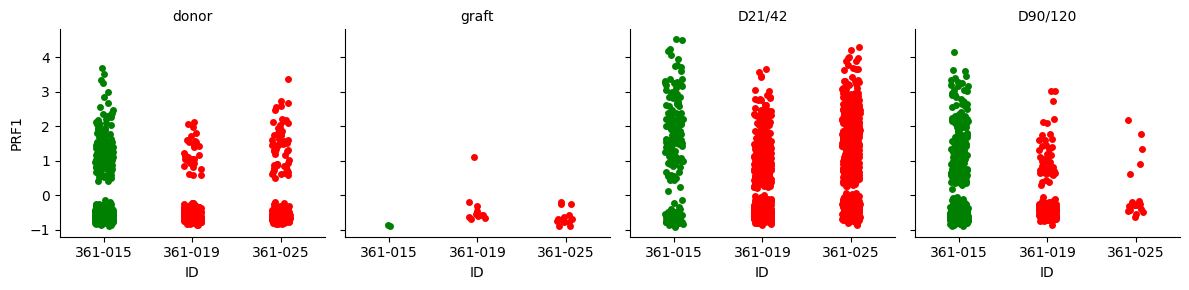

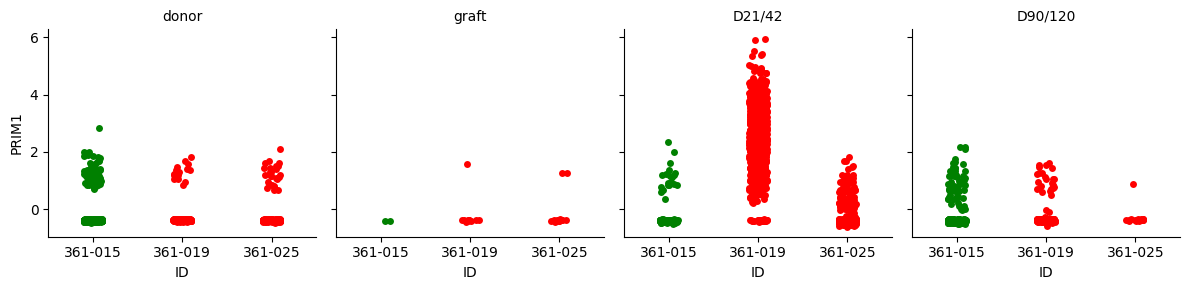

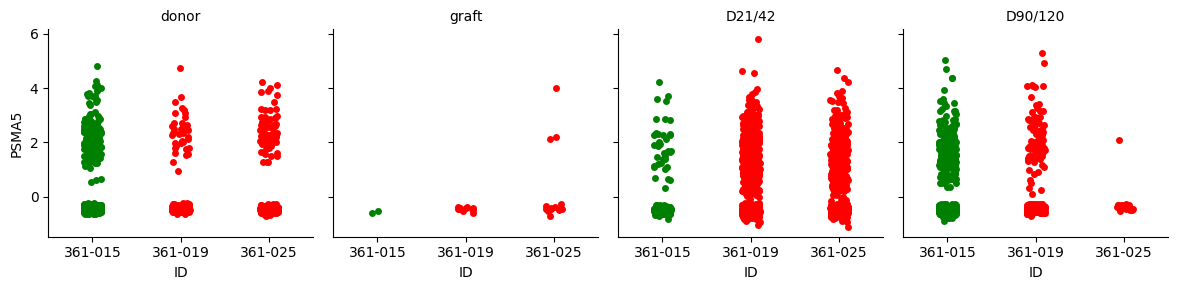

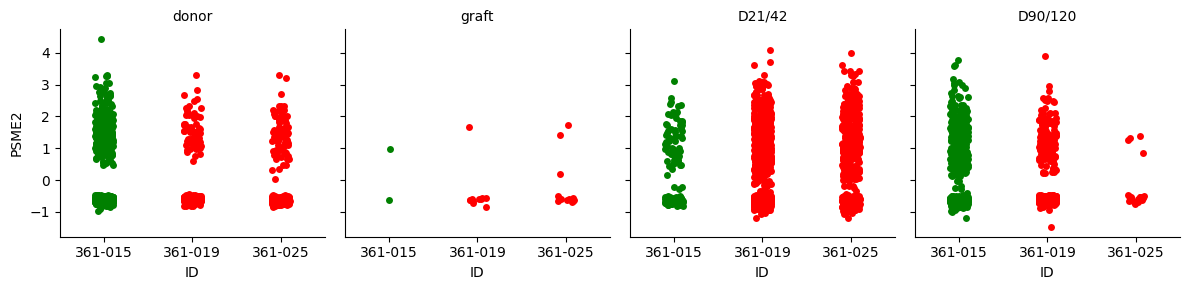

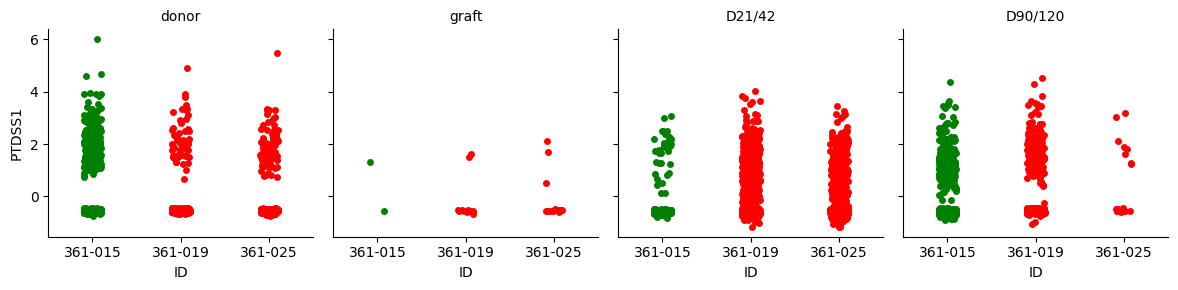

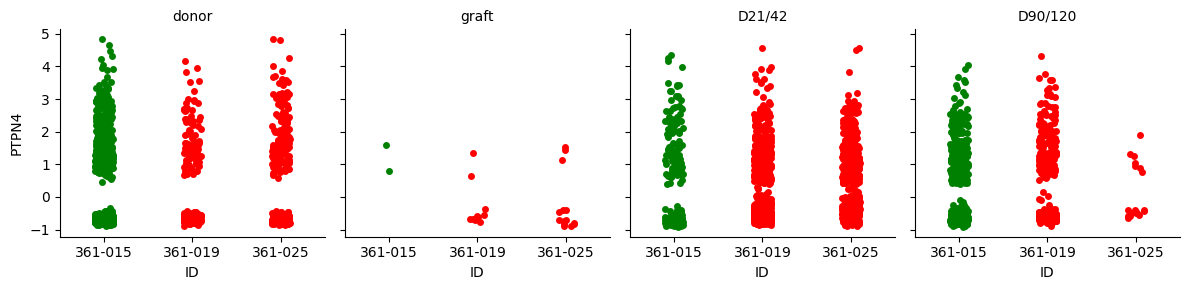

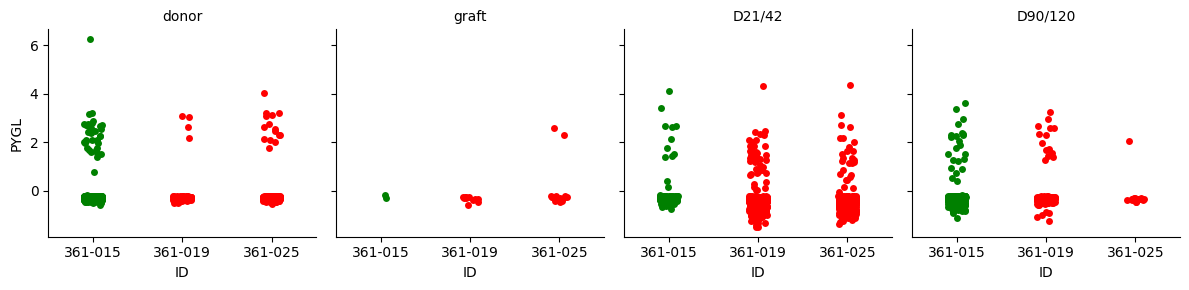

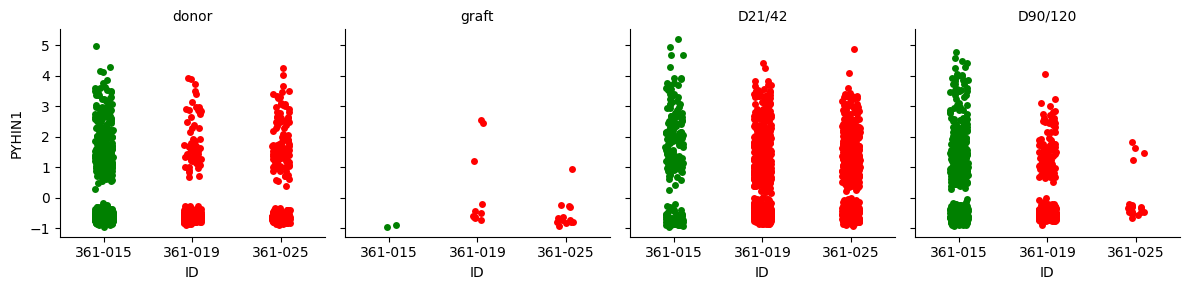

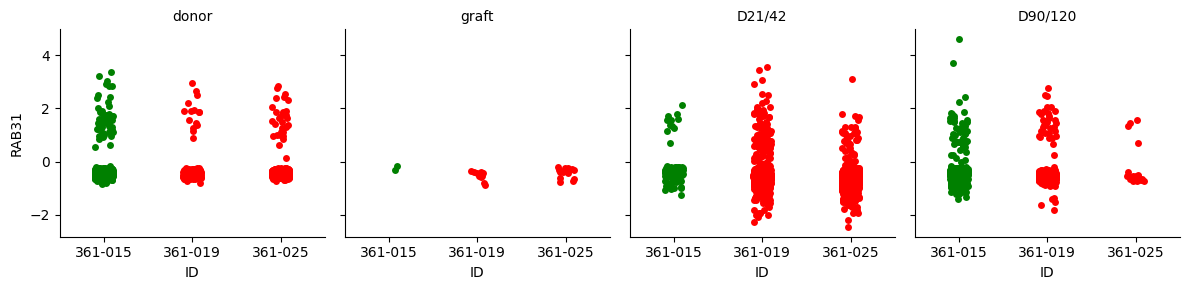

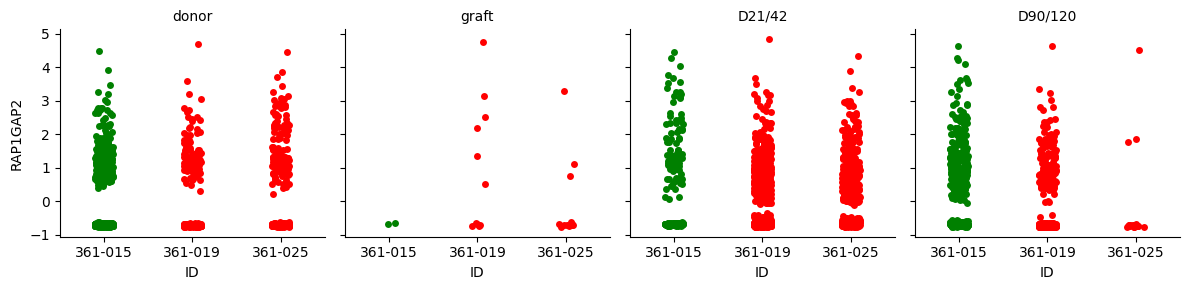

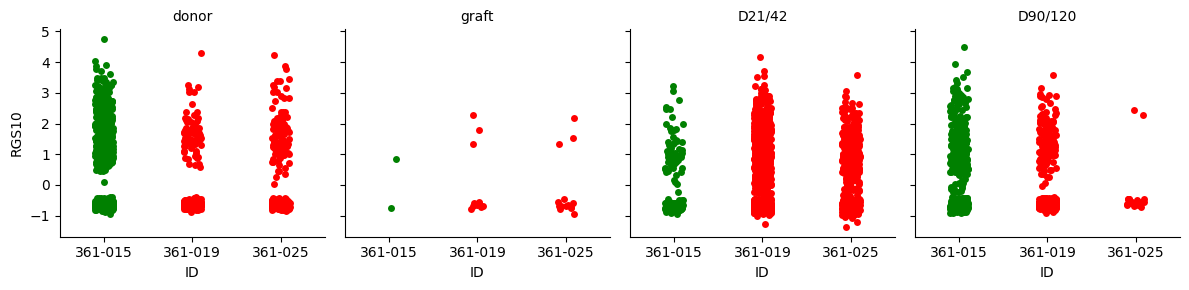

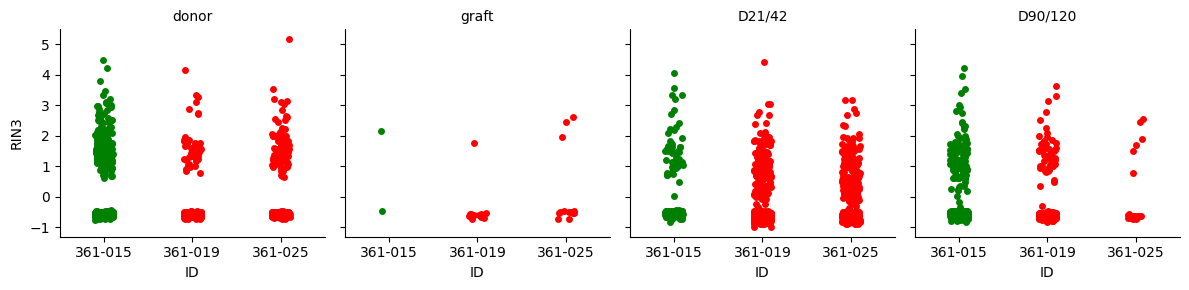

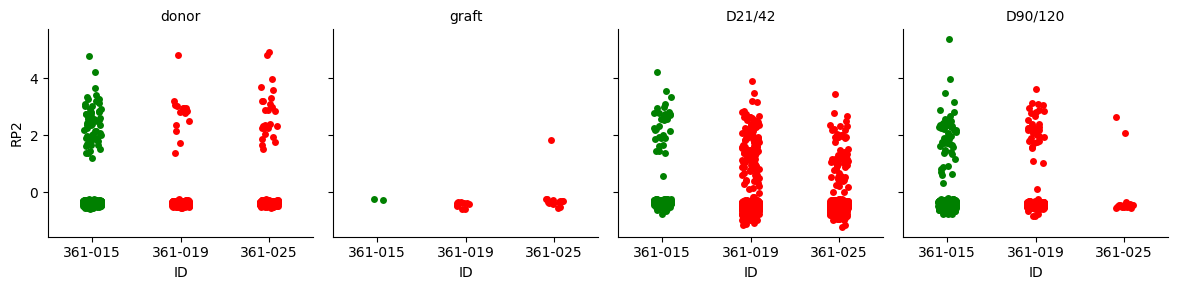

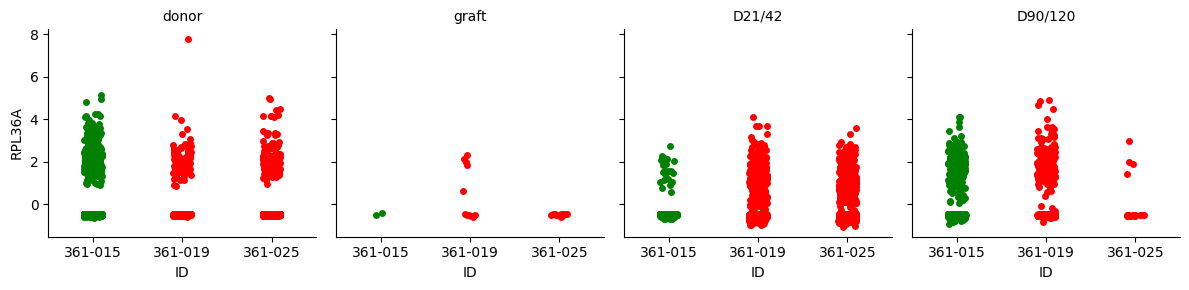

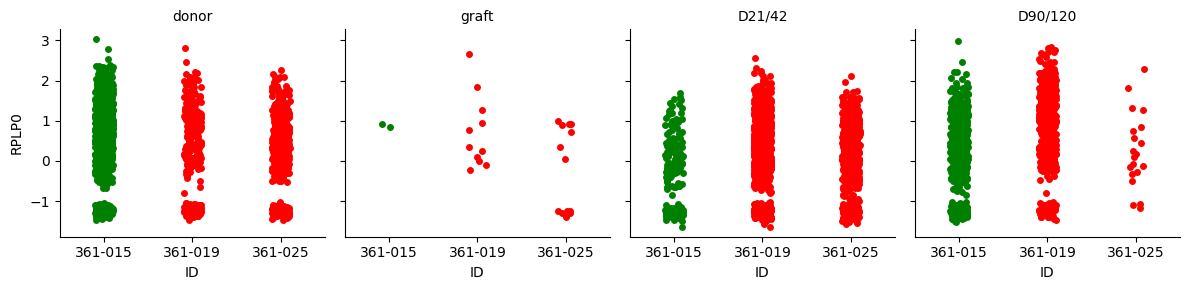

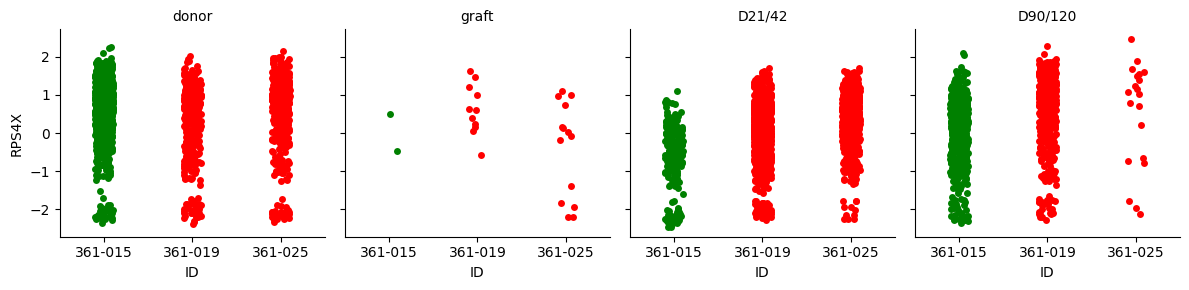

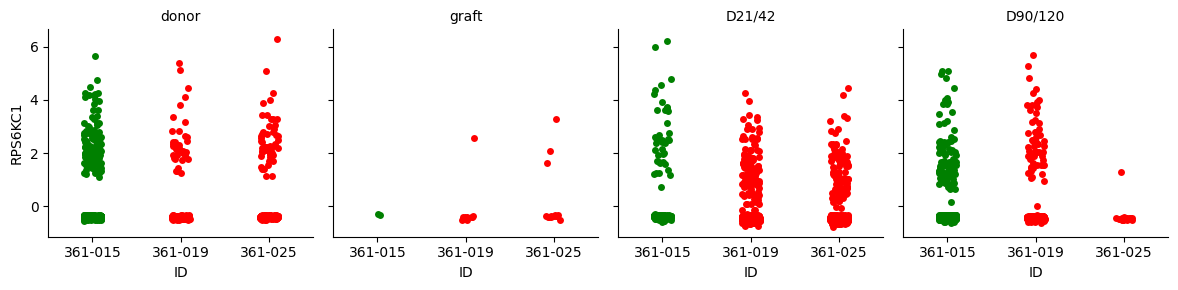

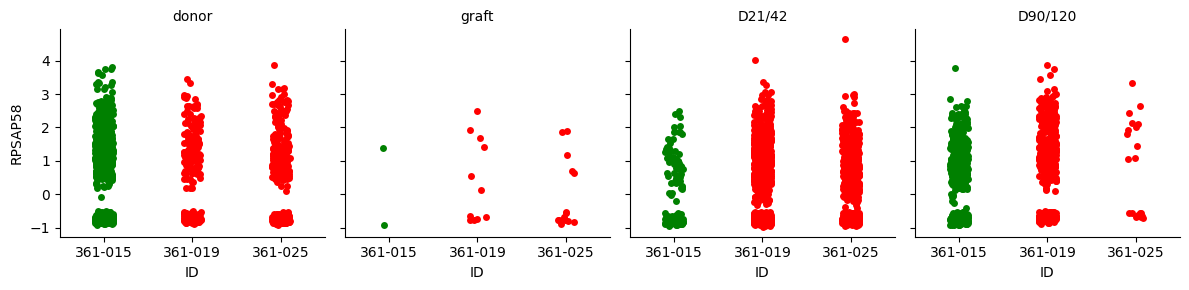

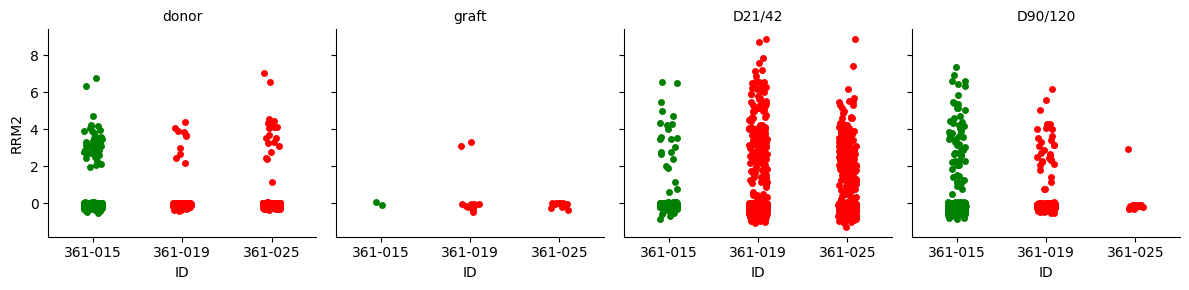

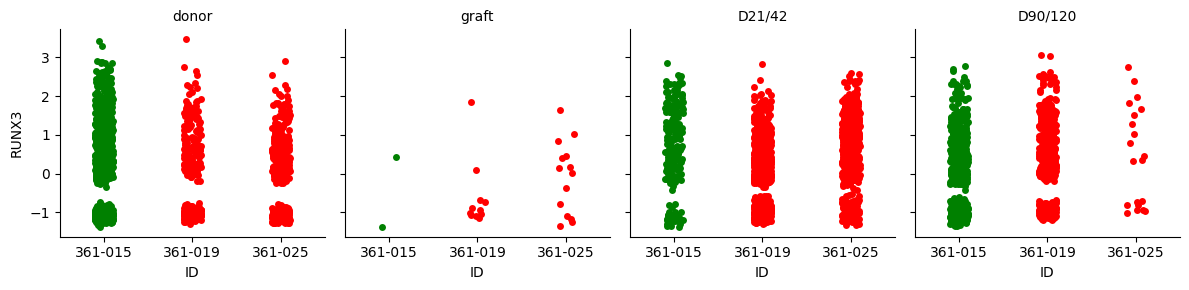

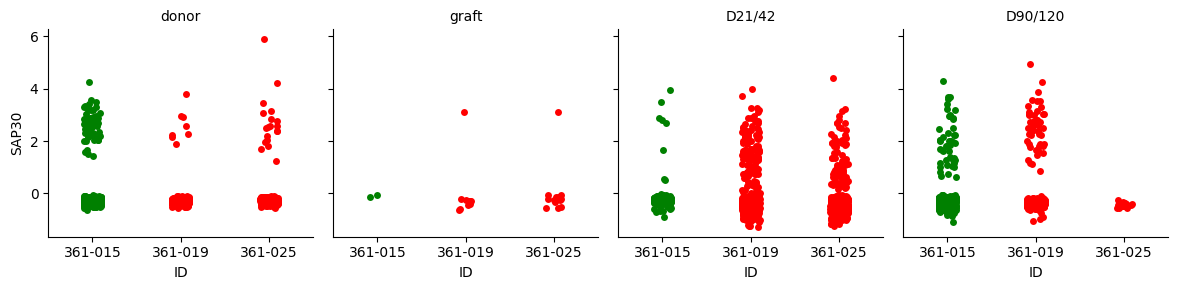

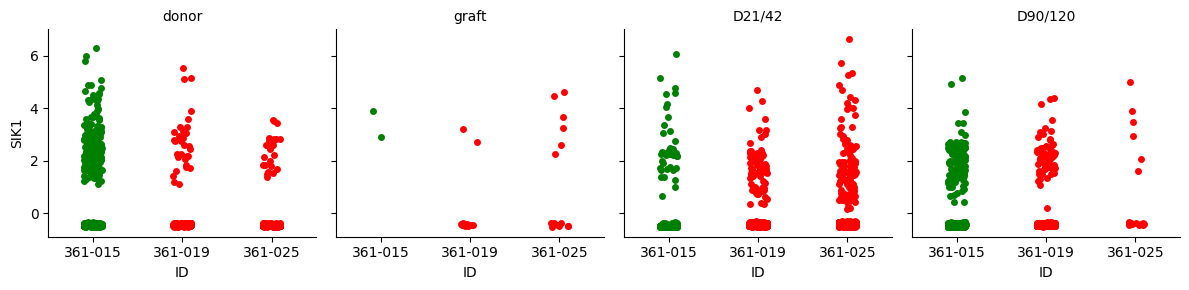

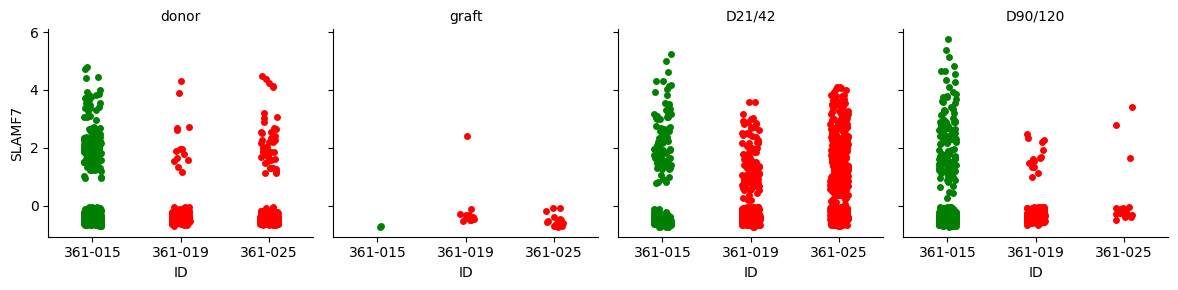

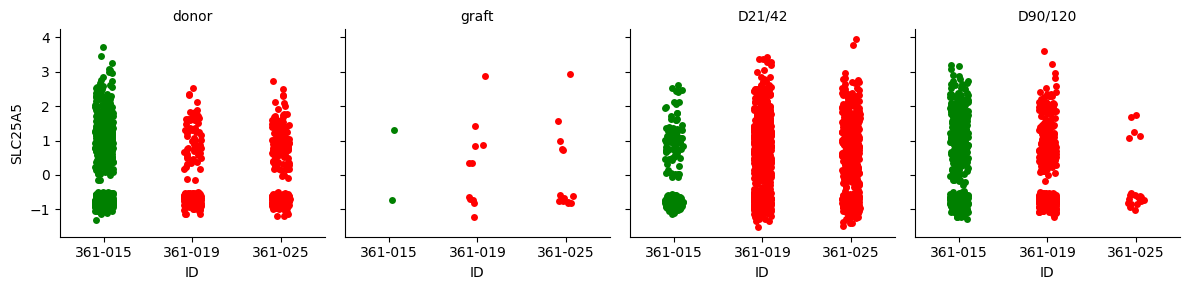

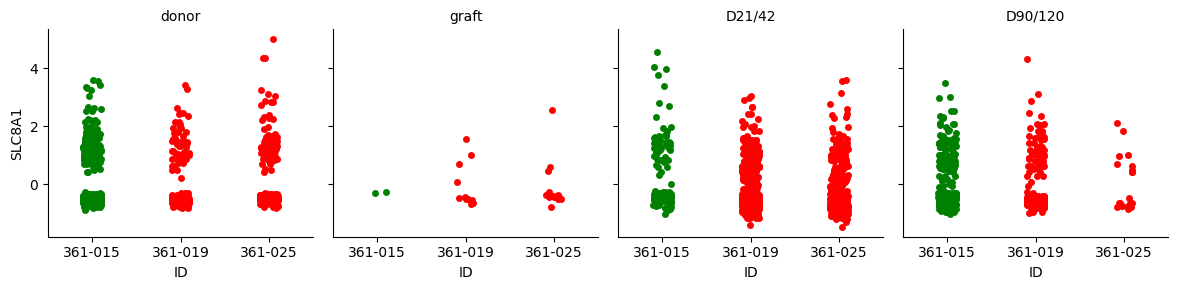

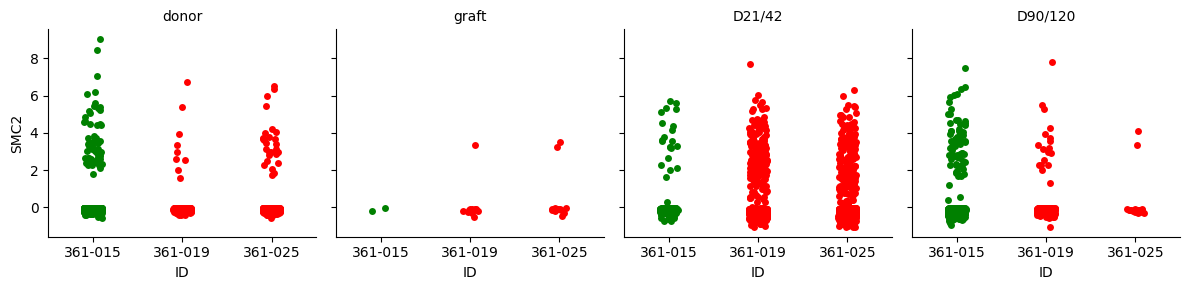

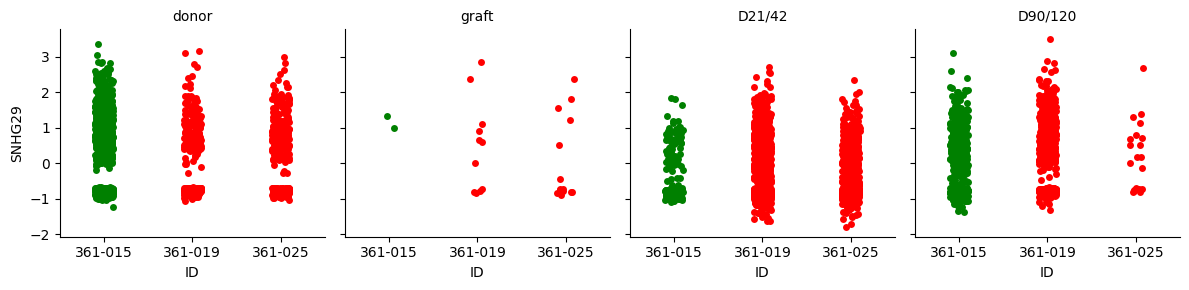

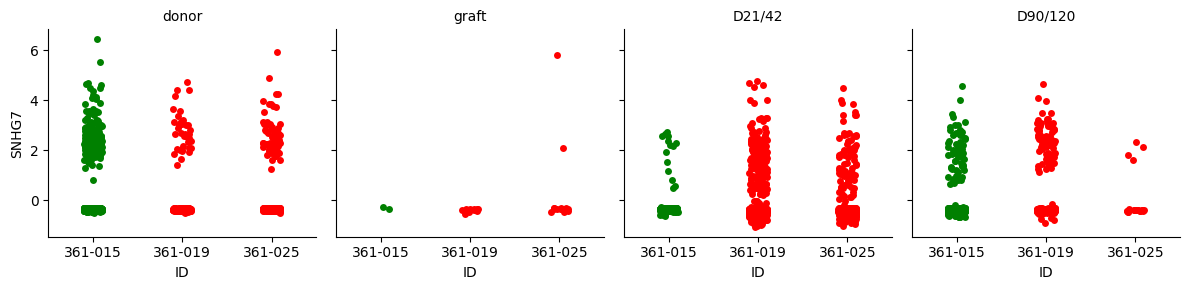

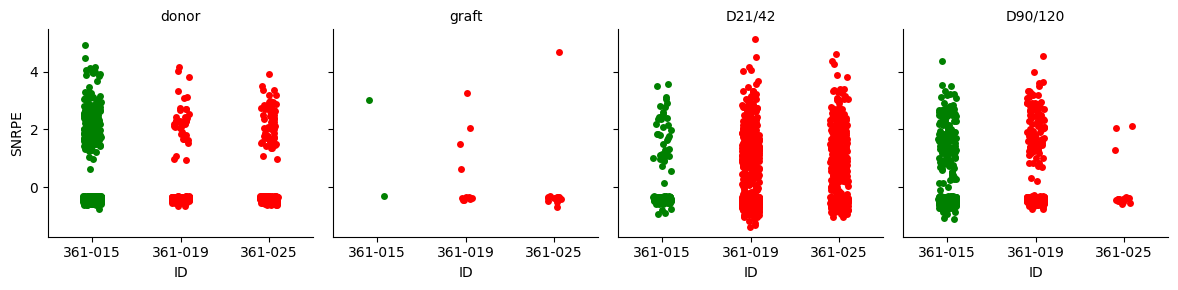

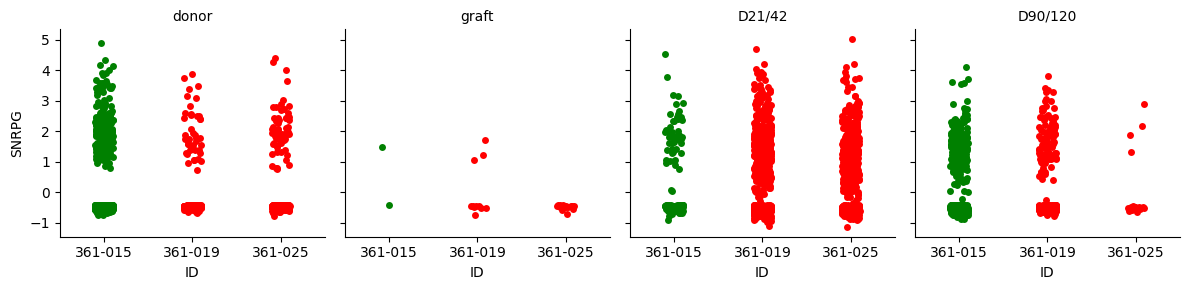

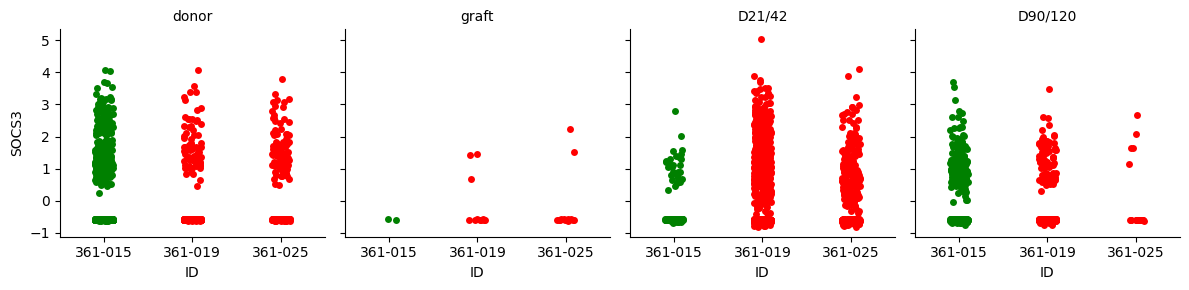

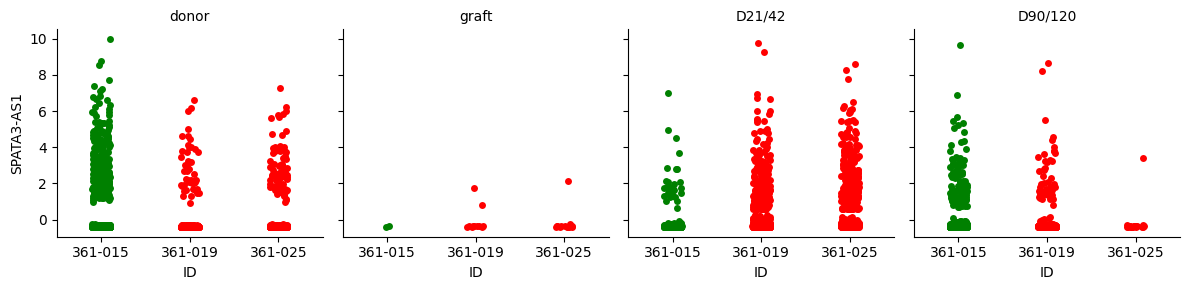

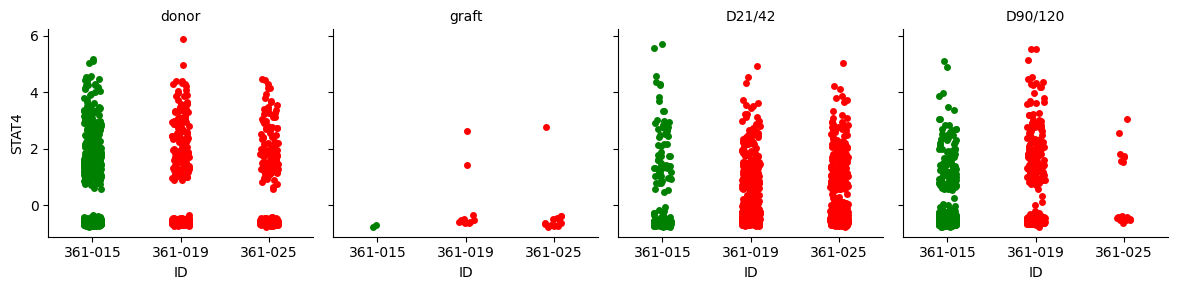

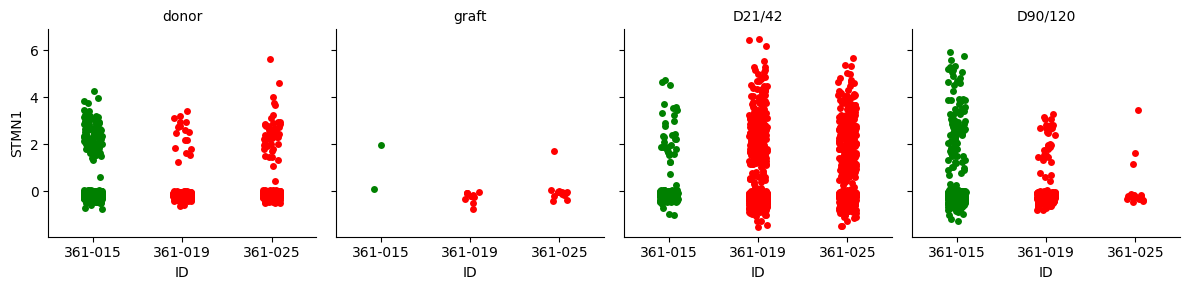

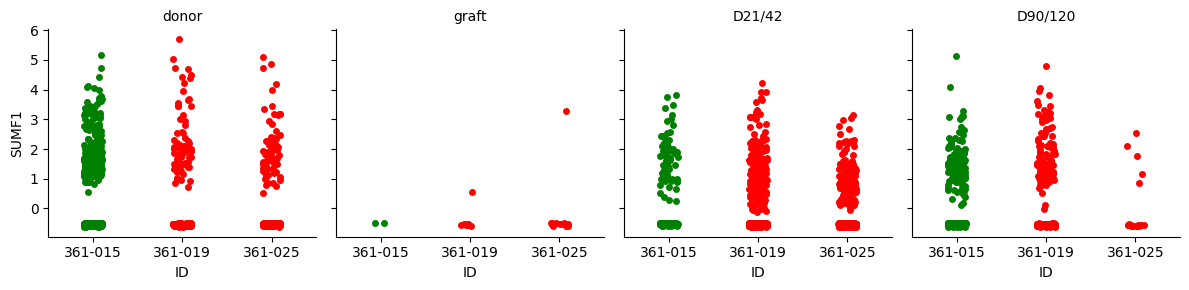

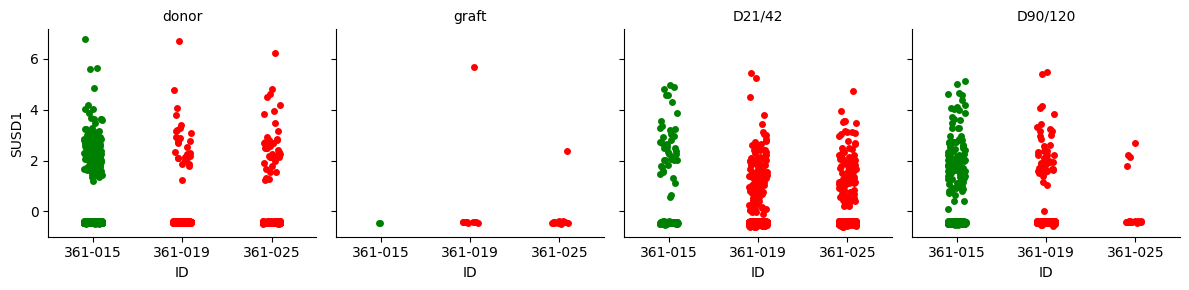

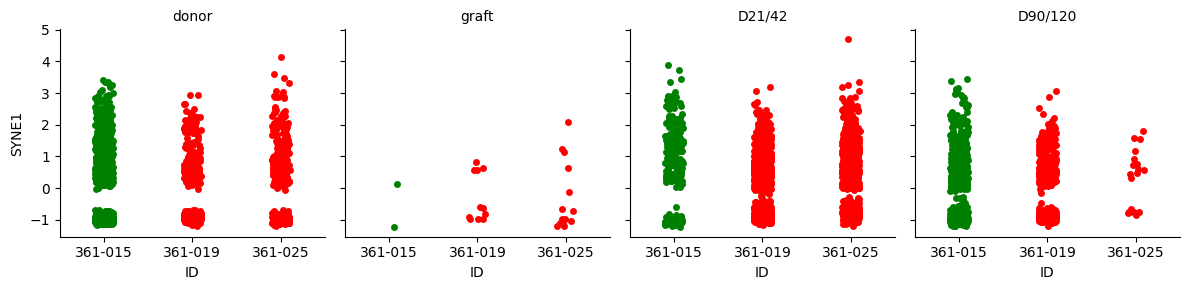

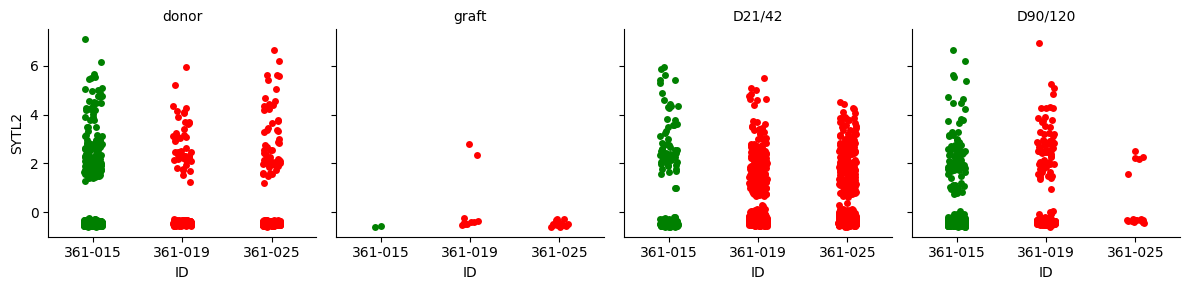

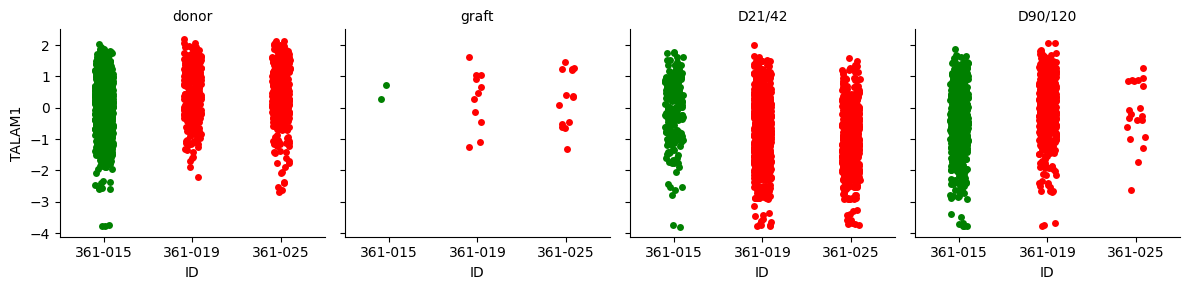

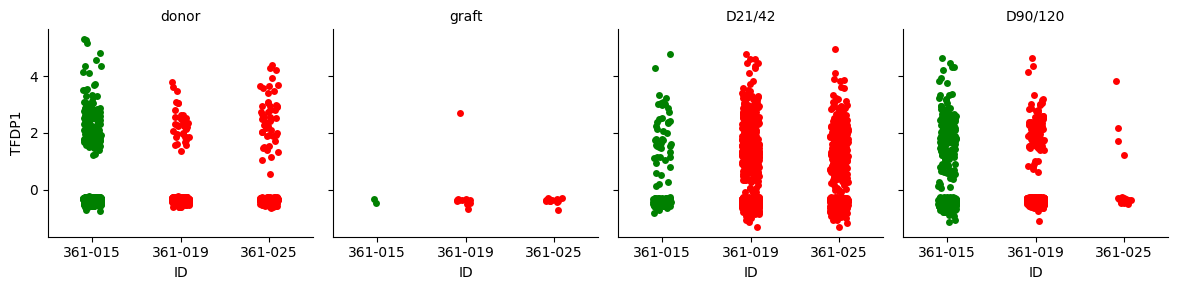

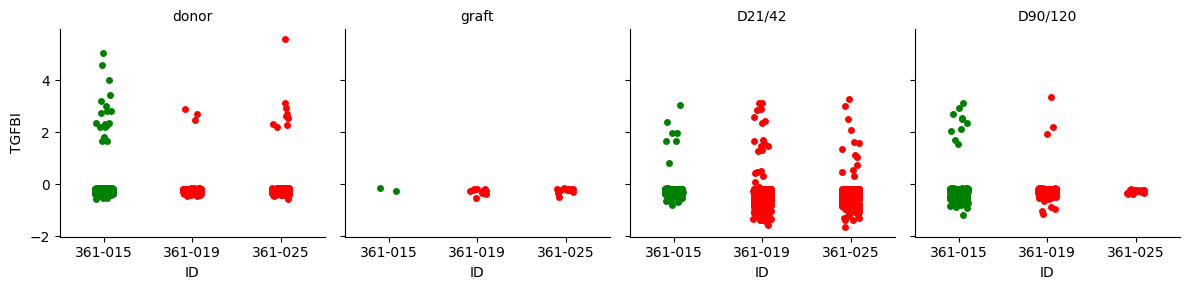

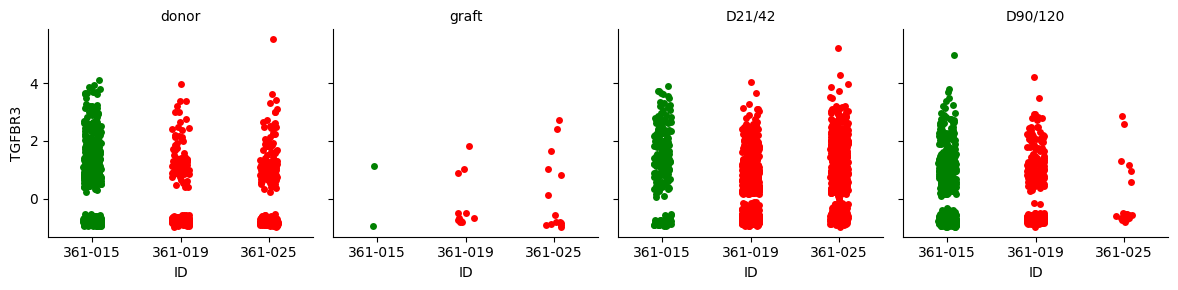

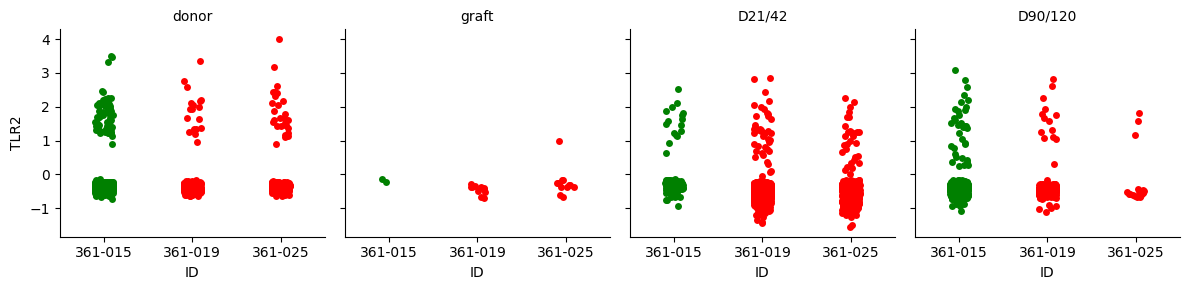

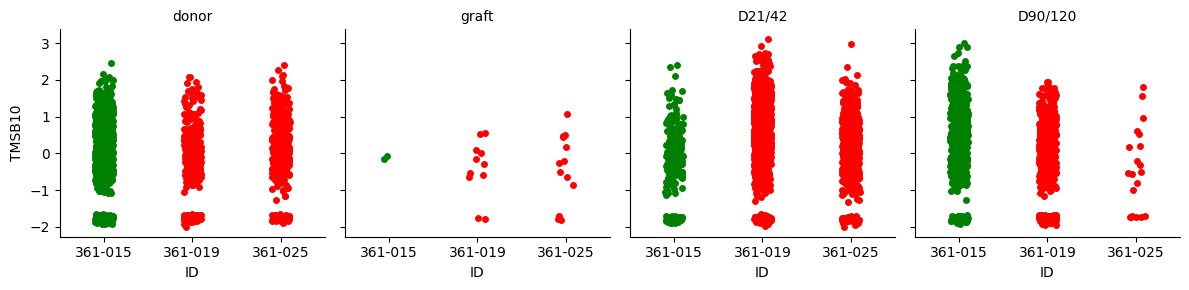

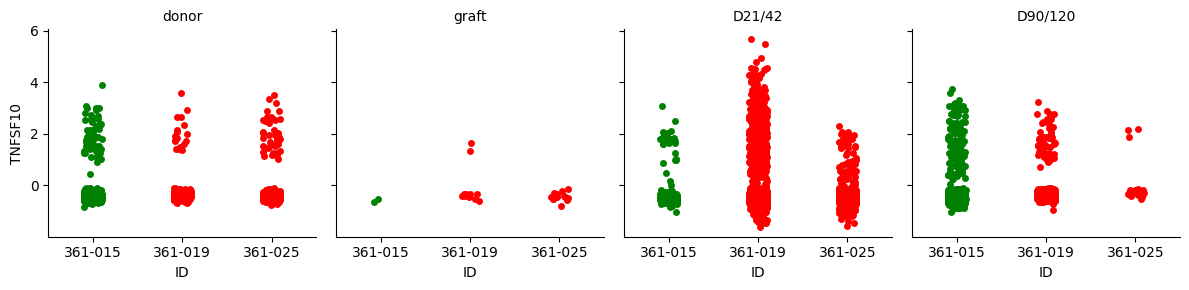

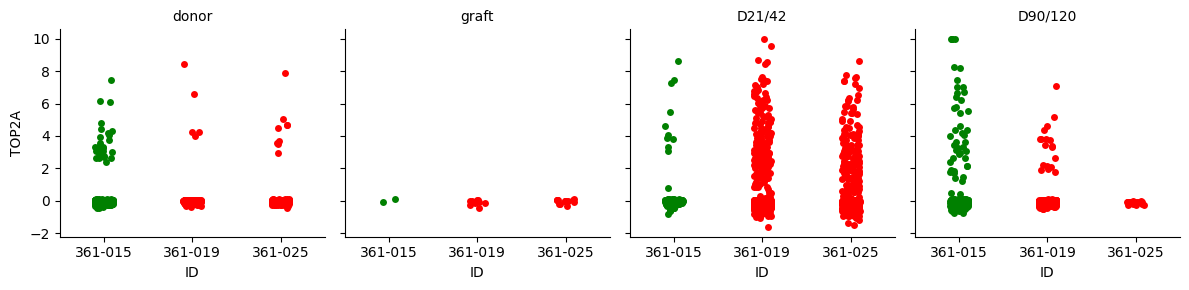

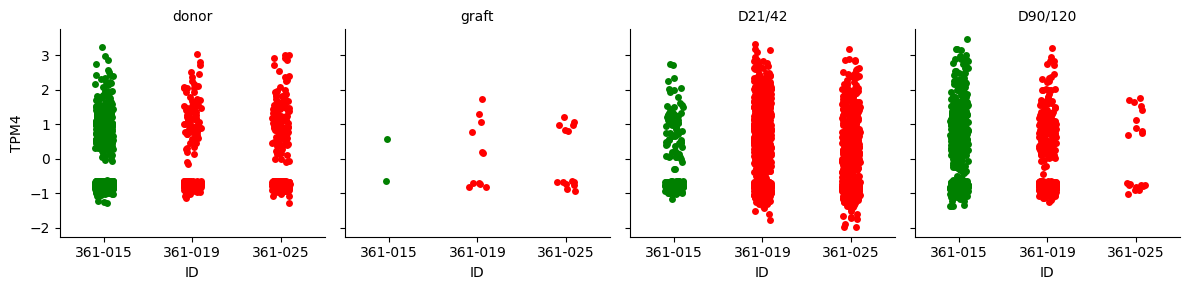

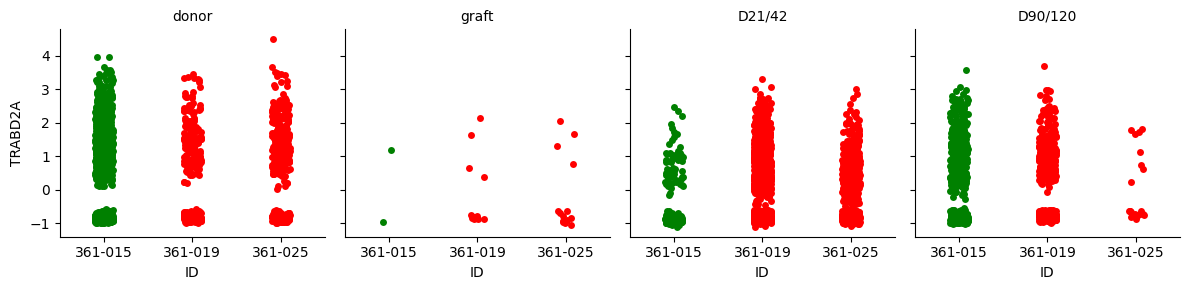

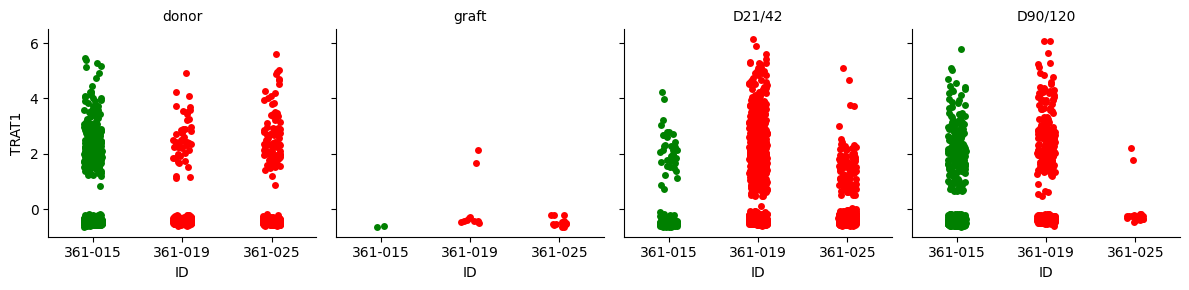

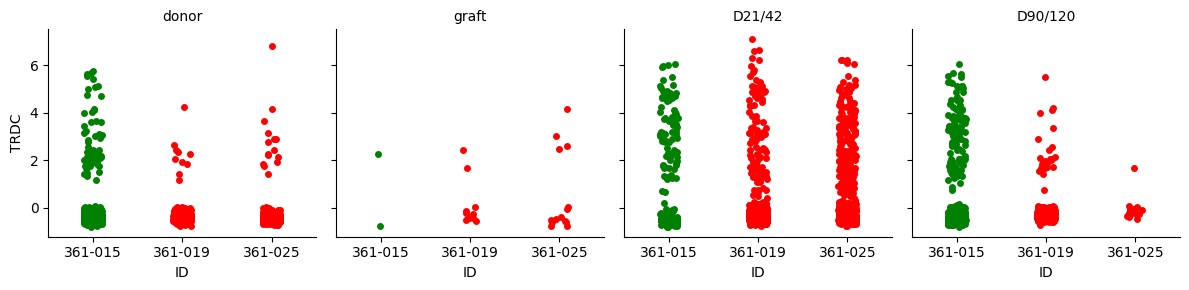

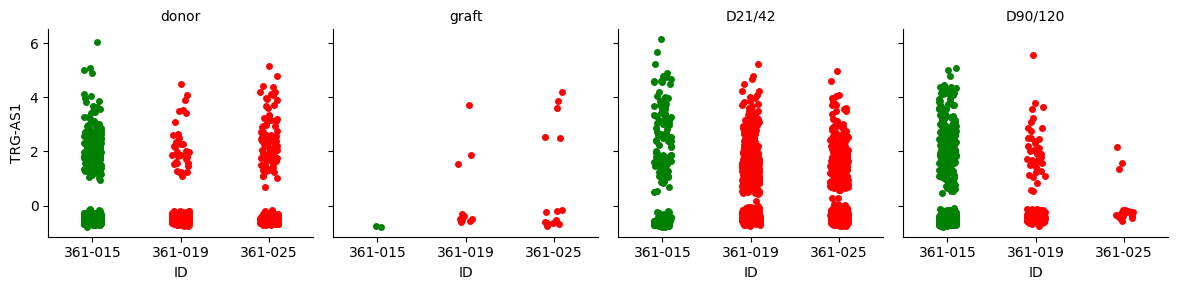

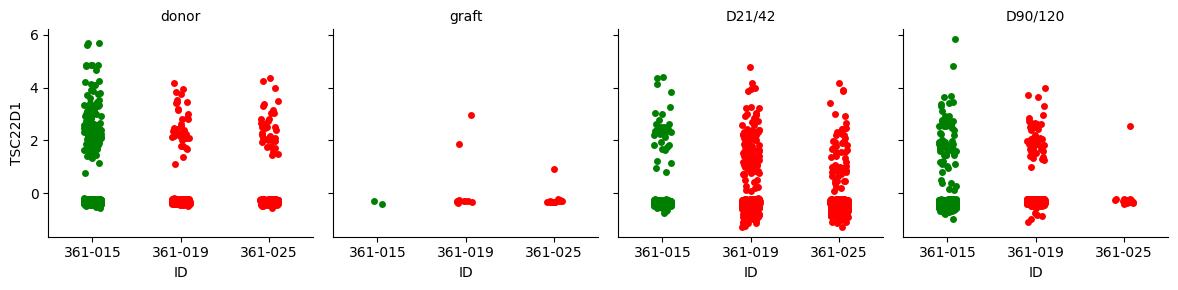

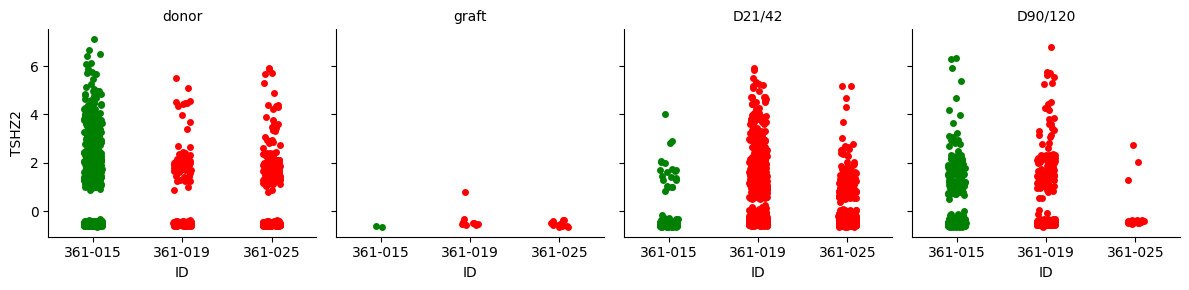

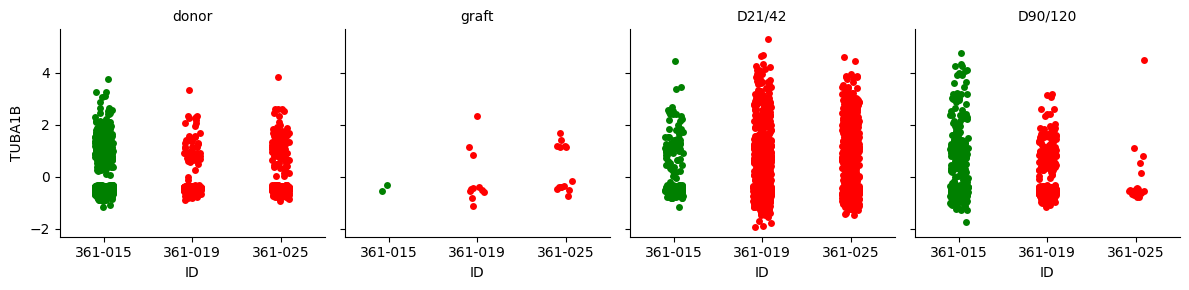

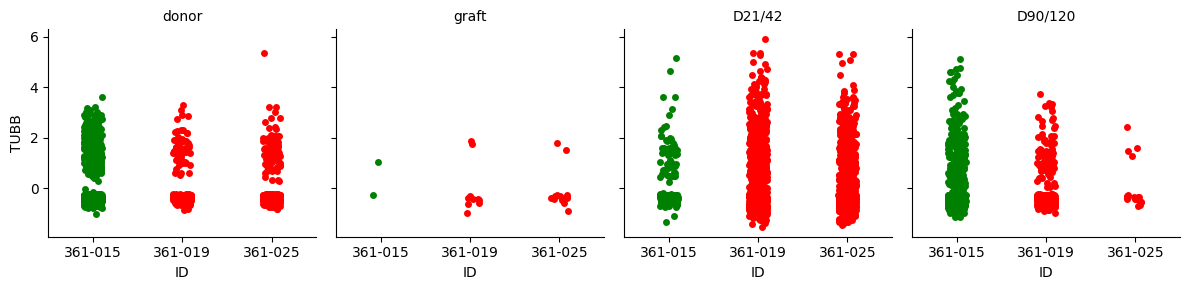

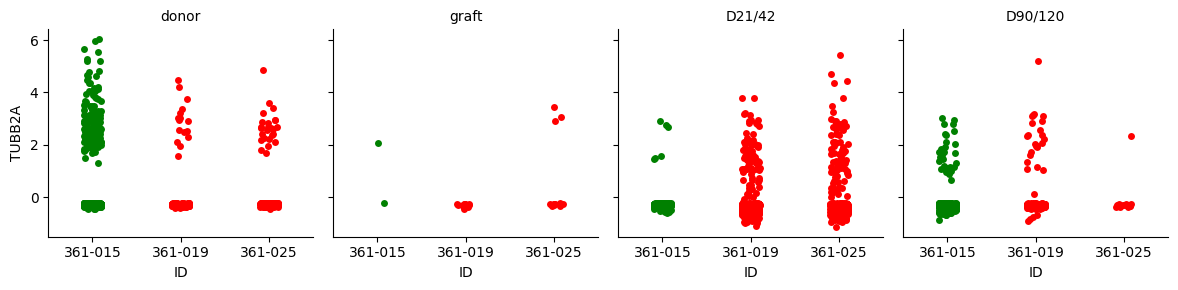

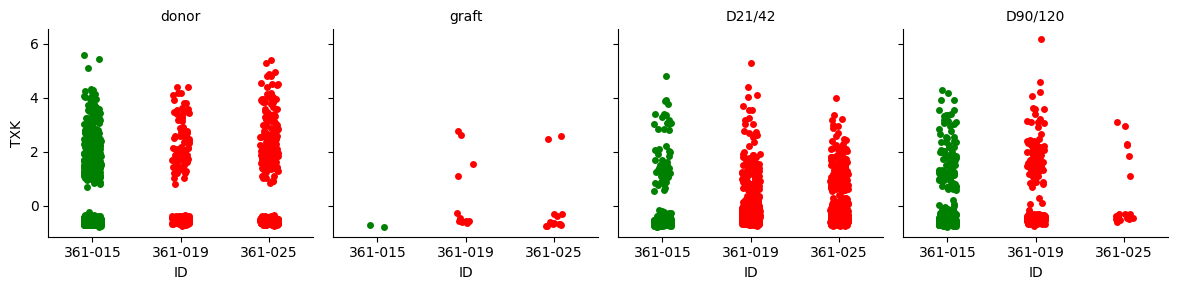

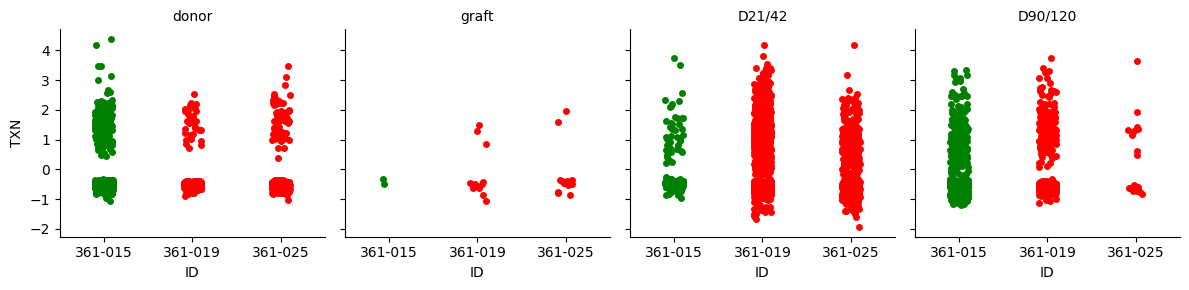

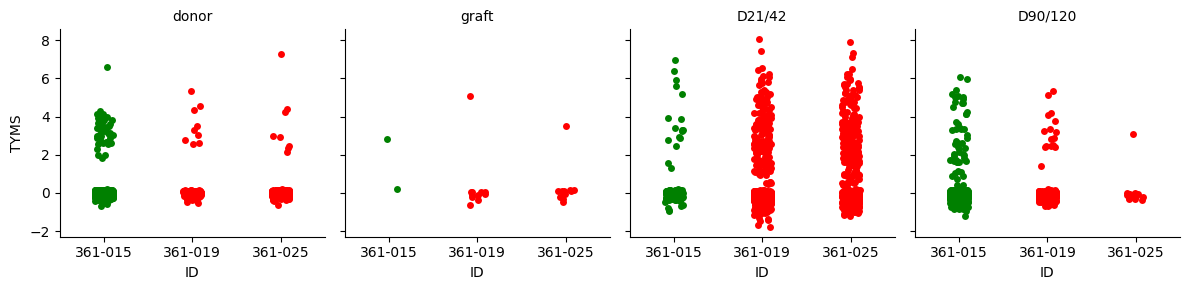

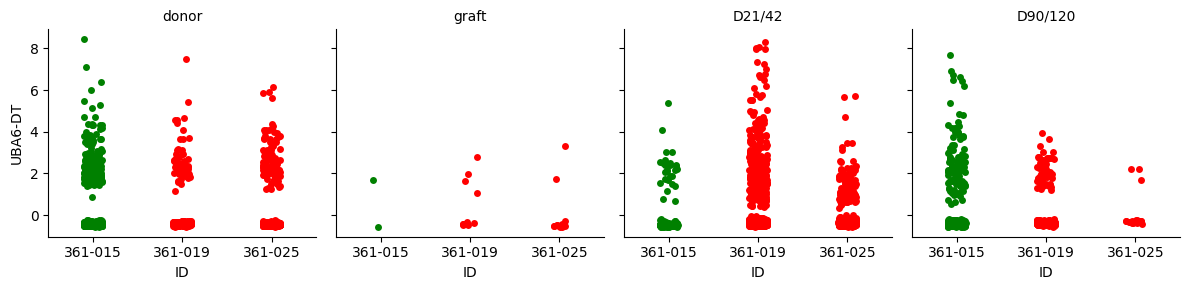

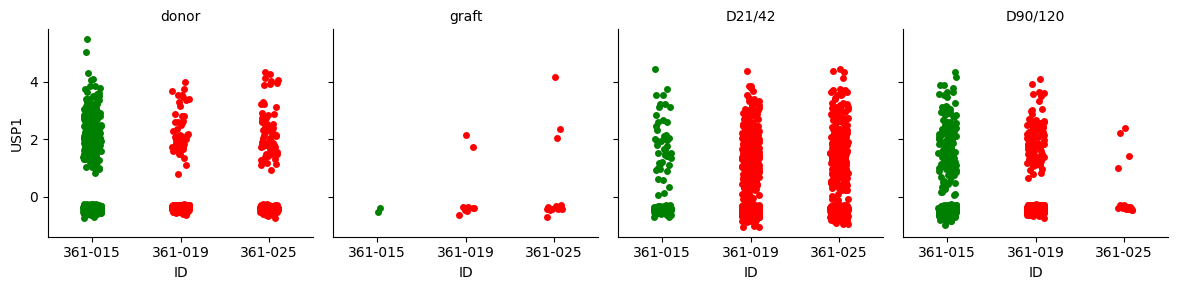

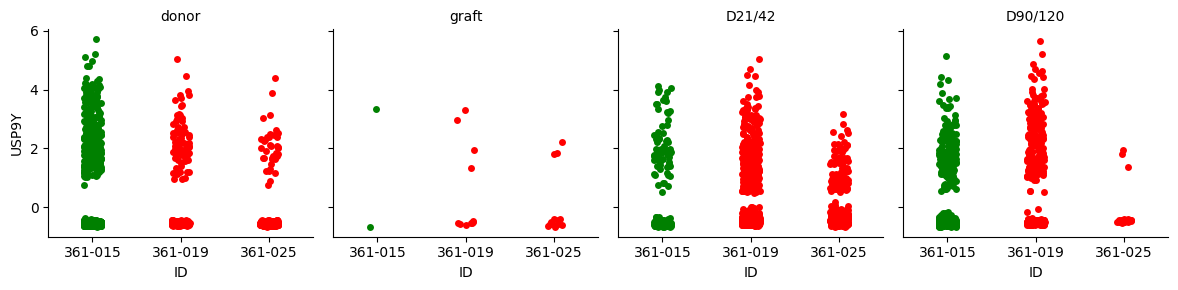

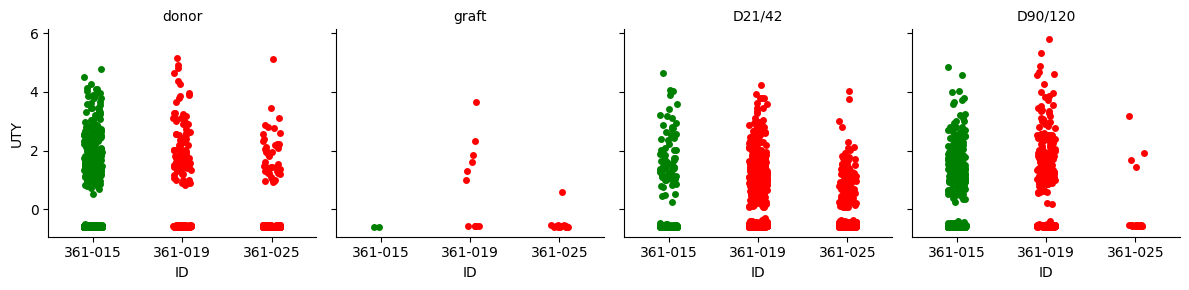

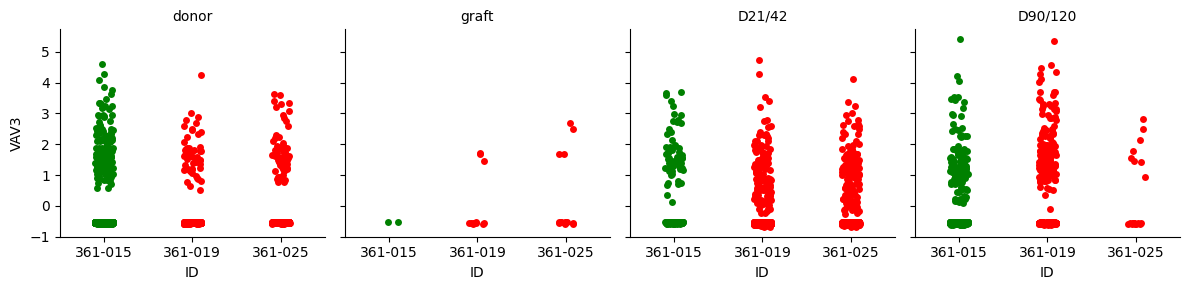

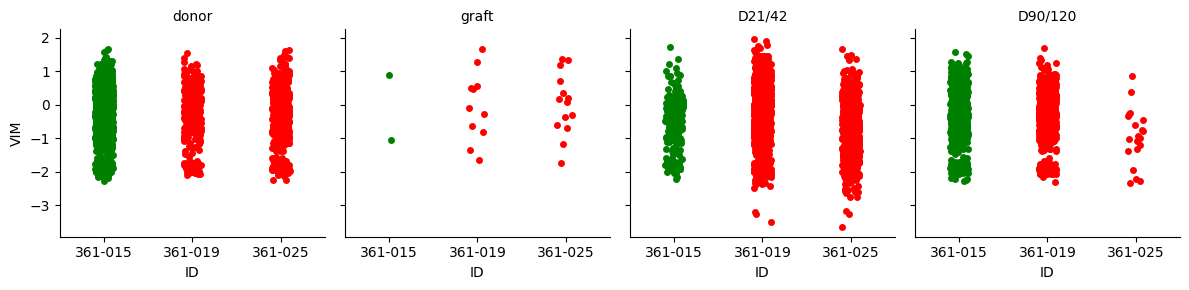

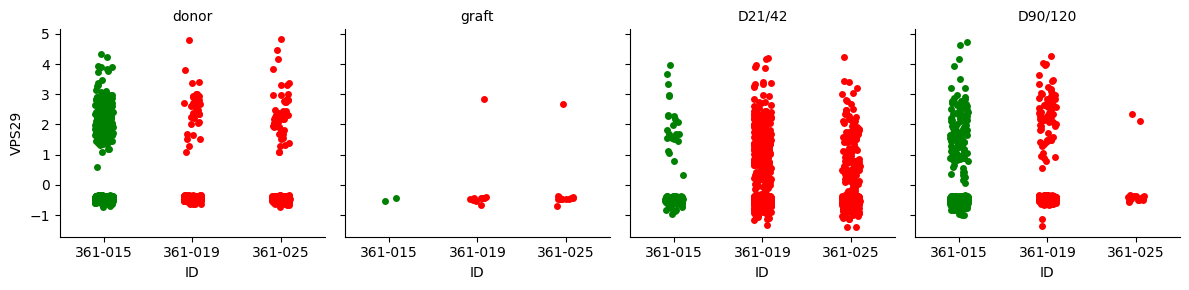

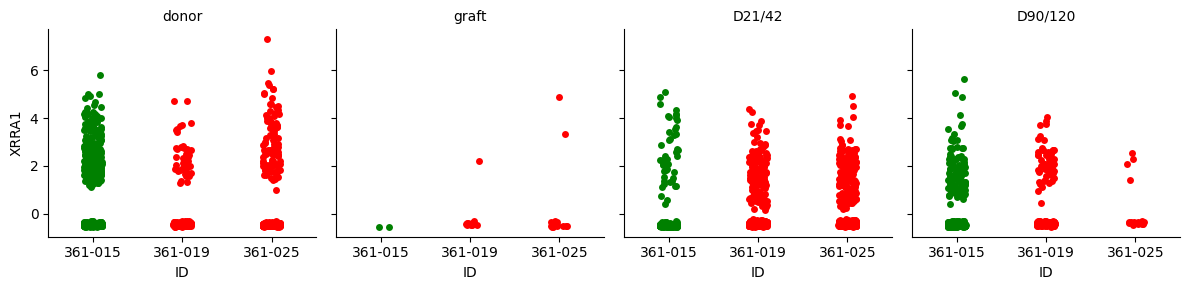

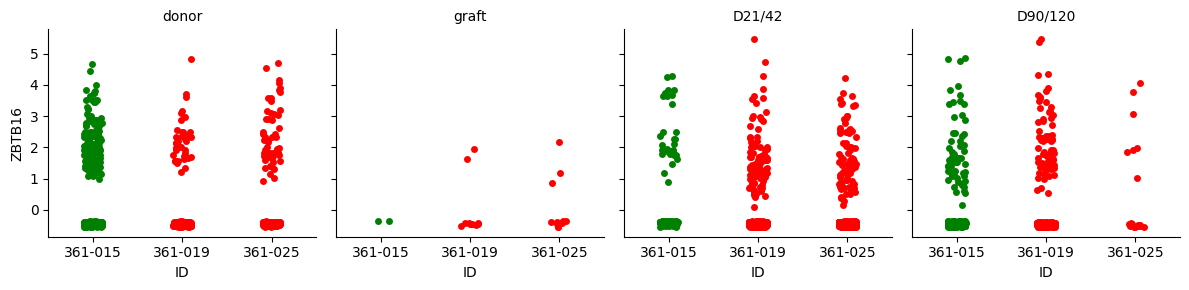

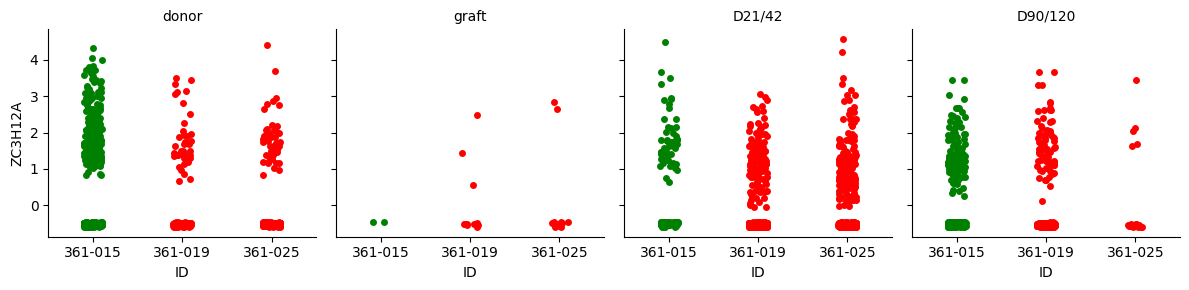

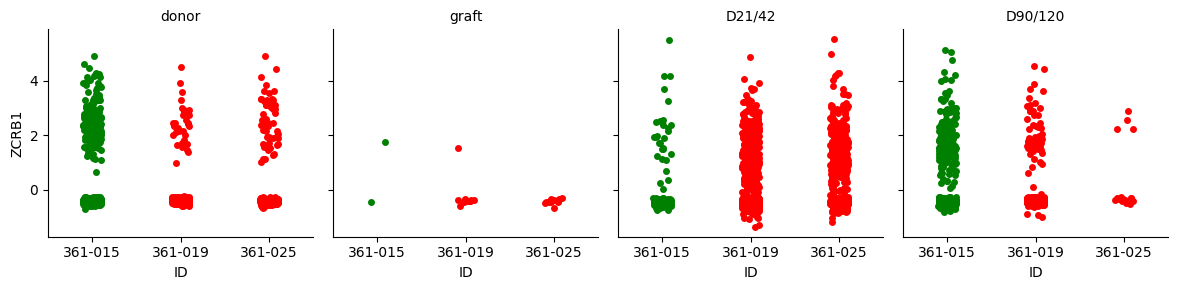

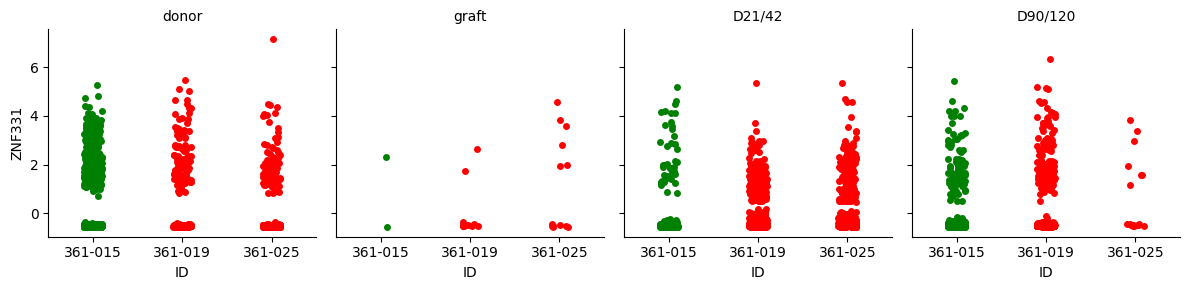

In [26]:
rows = rna_adata.obs["consensus_l2_celltype"] == "T cells"
for gene in sig_genes:
    plot_genes(rna_adata[rows],
               x_vals="ID",
               y_val=gene,
               hue="aghvd", 
               facet_cols="day_label",
               col_order=( 'donor', 'graft', 'D21/42', 'D90/120'),
               x_tick_order=('361-015', '361-019', '361-025'),
               palette={"no": "green", "yes": "red"}
              )